Experimentation on the Syntetic simmulated data and annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [5]:
X_train = np.loadtxt("../syntetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("../syntetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt("../syntetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("../syntetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2292, 2)


In [6]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2292, 2)

### Generate Annotations

In [7]:
from code.generate_data import SinteticData

In [14]:
GenerateData = SinteticData()
GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_normal.csv',file_groups ='../syntetic/simple/groups_datasim.csv')
Tmax = 100
T_data = 10 
y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)


real_conf_matrix = GenerateData.conf_matrix

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
    print("Done")
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

del GenerateData
gc.collect()

Done


159

In [ ]:


GenerateData = SinteticData()
GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_normal.csv',file_groups ='../syntetic/simple/groups_datasim.csv')
Tmax = 100
T_data = 10 

real_conf_matrix = GenerateData.conf_matrix.copy()

for i in range(20): #repetitions
    print("New Synthetic data is being generated...",flush=True,end='')
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)
    print("Done! ")
    
    if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
        groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
        print("Done")
    confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]]


    N,T = y_obs.shape
    K = np.max(y_obs)+1 # asumiendo que estan ordenadas
    print("Shape (data,annotators): ",(N,T))
    print("Classes: ",K)
    
    #execute all algorithms.. measure metrics and save it
    
del GenerateData
gc.collect()

#plot measures

In [5]:
#opt = "datasim_normal"
#opt = "datasim_normal_badMV"
#opt = "datasim_normal_soft" 
#opt = "datasim_manyAnnot_v1" #npy
opt = "datasim_manyAnnot_v2" #npy
#opt = "datasim_manyAnnot_v1_badMV" #npy

In [7]:
#delete unlabeled data
mask_labeled = np.sum(y_obs != -1,axis=1) != 0
Xstd_train = Xstd_train[mask_labeled]
Z_train = Z_train[mask_labeled]
y_obs = y_obs[mask_labeled]
print("Shape (data,annotators): ",(y_obs.shape))

Shape (data,annotators):  (2292, 10000)


#### Delta Convergence criteria

In [3]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [9]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [11]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels = label_I.DS_labels()

num Patients: 2292
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -19542.594807259495
2 	 -18555.337901011728 	0.3085	0.223260	0.050518
3 	 -17985.348513706536 	0.1095	0.181222	0.030718
4 	 -17757.24139474997 	0.0901	0.169876	0.012683
5 	 -17699.189322640723 	0.0561	0.139910	0.003269
6 	 -17684.850677218827 	0.0301	0.111747	0.000810
7 	 -17681.25665057676 	0.0152	0.080504	0.000203
8 	 -17680.21489078275 	0.0075	0.050933	0.000059
9 	 -17679.77691666033 	0.0038	0.032519	0.000025
10 	 -17679.487514279095 	0.0019	0.023358	0.000016
11 	 -17679.28217280602 	0.0010	0.018071	0.000012
12 	 -17679.16424154792 	0.0006	0.014829	0.000007
13 	 -17679.103828816664 	0.0004	0.012526	0.000003
14 	 -17679.07120615015 	0.0002	0.010632	0.000002
15 	 -17679.051121285873 	0.0001	0.008515	0.000001
Class marginals
[0.33 0.33 0.33]
Patient classes
1 [0. 0. 1.]
2 [0.9744 0.     0.0256]
3 [0.     0.9999 0.0001]
4 [0.     0.9999 0.0001]
5 [0.    0.007 0.993]
6 [0.     0.0306 0.9694]
7 [0.007 0.    0.993]
8 [0.

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6169284467713787
ACC D&S on train: 0.9297556719022687


In [13]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

Trained model over soft-MV


In [14]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

Trained model over hard-MV


In [15]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

Trained model over D&S


In [10]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [11]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2292, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.81 sec)	logL: -36493.172	
Iter 2/50 
M step: done,  E step: done //  (in 0.75 sec)	logL: -36078.172	Tol1: 0.01137	Tol2: 0.20584	
Iter 3/50 
M step: done,  E step: done //  (in 0.67 sec)	logL: -36062.355	Tol1: 0.00044	Tol2: 0.00391	
Finished training!


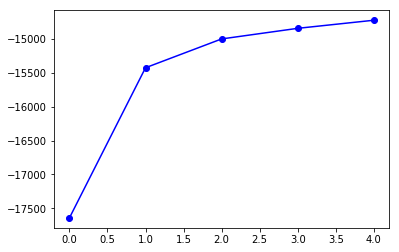

In [37]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [36]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2292, 3)
Iter 1/50 
M step: done,  E step: done //  (in 20.83 sec)	logL: -32323.252	
Iter 2/50 
M step: done,  E step: done //  (in 0.65 sec)	logL: -31587.340	Tol1: 0.02277	Tol2: 0.29136	
Iter 3/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -31546.770	Tol1: 0.00128	Tol2: 0.01912	
Iter 4/50 
M step: done,  E step: done //  (in 0.59 sec)	logL: -31510.746	Tol1: 0.00114	Tol2: 0.00712	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2292, 3)
Iter 1/50 
M step: done,  E step: done //  (in 21.83 sec)	logL: -32696.684	
Iter 2/50 
M step: done,  E step: done //  (in 0.60 sec)	logL: -31991.016	Tol1: 0.02158	Tol2: 0.29269	
Iter 3/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -31913.748	Tol1: 0.00242	Tol2: 0.01982	
Iter 4/50 
M step: done,  E step: done //  (in 0.59 sec)	logL: -31843.320	Tol1: 0.00221	Tol2: 0.00811	
Finished traini

### Our Proposed

In [12]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 0  1 39]
 [19  0 14]
 [20 14 16]
 ...
 [27  0 11]
 [17 17 12]
 [ 0  1 37]]
shape: (2292, 3)


In [13]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
M_ffff,annotators_pca = project_and_cluster(y_obs_categorical,return_projected=True,DTYPE_OP=DTYPE_OP)
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Bayesian gaussian mixture say is 10 clusters 


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 6 clusters
Annotators PCA of annotations shape:  (10000, 4)
Normalized entropy (0-1) of repeats annotations: 0.5484609227990507
CPU times: user 2min 27s, sys: 13.3 s, total: 2min 40s
Wall time: 2min 31s


In [14]:
M_seted = 3

In [15]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2292, 3)
Betas:  (3, 3, 3)
Q estimate:  (2292, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.16 sec)	logL: -88797.448	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -87577.533	Tol1: 0.01374	Tol2: 0.12372	Tol3: 0.00163	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -86421.875	Tol1: 0.01320	Tol2: 0.12218	Tol3: 0.00152	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -85249.367	Tol1: 0.01357	Tol2: 0.13159	Tol3: 0.00157	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -84008.934	Tol1: 0.01455	Tol2: 0.14278	Tol3: 0.00159	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -82702.110	Tol1: 0.01556	Tol2: 0.15381	Tol3: 0.00152	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -81347.264	Tol1: 0.01638	Tol2: 0.16056	Tol3: 0.00152	
I

In [16]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.3732767  0.86770135 0.9239188 ]
Alphas:  (3,)
MV init:  (2292, 3)
Betas:  (3, 3, 3)
Q estimate:  (2292, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -87019.421	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -84949.481	Tol1: 0.02379	Tol2: 0.15858	Tol3: 0.00619	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -83254.897	Tol1: 0.01995	Tol2: 0.14626	Tol3: 0.00786	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -81936.590	Tol1: 0.01583	Tol2: 0.14736	Tol3: 0.00706	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -80890.080	Tol1: 0.01277	Tol2: 0.14513	Tol3: 0.00648	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -80067.991	Tol1: 0.01016	Tol2: 0.14537	Tol3: 0.00701	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -79350.917	Tol1: 0.00896	Tol2: 

In [17]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs...

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.6960655  0.10380924 0.34229547]
Alphas:  (3,)
MV init:  (2292, 3)
Betas:  (3, 3, 3)
Q estimate:  (2292, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.42 sec)	logL: -85483.934	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -82444.887	Tol1: 0.03555	Tol2: 0.23850	Tol3: 0.04329	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -80749.145	Tol1: 0.02057	Tol2: 0.15209	Tol3: 0.01574	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -79285.211	Tol1: 0.01813	Tol2: 0.14126	Tol3: 0.01101	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -77977.144	Tol1: 0.01650	Tol2: 0.13875	Tol3: 0.00928	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -76788.180	Tol1: 0.01525	Tol2: 0.13163	Tol3: 0.00817	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -75707.034	Tol1: 0.01408	Tol2: 0.12103	Tol3: 0.00731	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -74753.581	Tol1: 0.01259	To

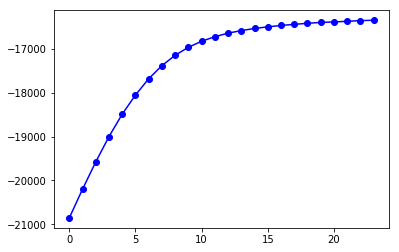

In [23]:
plt.plot(range(len(logL_hists[i])),logL_hists[i],'bo-')
plt.show()

### Compare trained models

In [18]:
#Import it:
from code.evaluation import Evaluation_metrics

In [11]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.942408 |     0.942408 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.941176 |     0.941176 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [19]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7905759162303665


In [30]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.679319 |     0.679319 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.67451 |      0.67451 |
+----+--------+------------+--------------+


In [31]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.712042 |     0.712042 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.721569 |     0.721569 |
+----+--------+------------+--------------+


In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.942845 |     0.942845 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.941176 |     0.941176 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


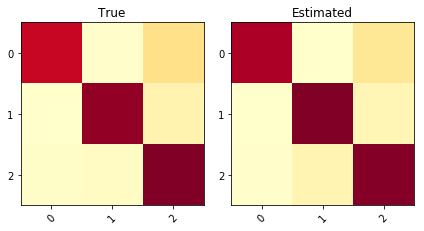

KL divergence: 0.0167	Pearson Correlation between diagonals: 0.9152


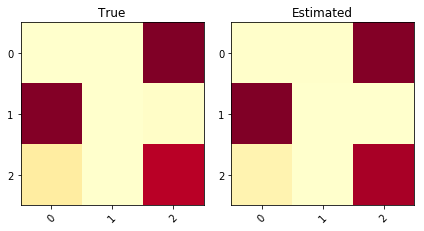

KL divergence: 0.0160	Pearson Correlation between diagonals: 1.0000


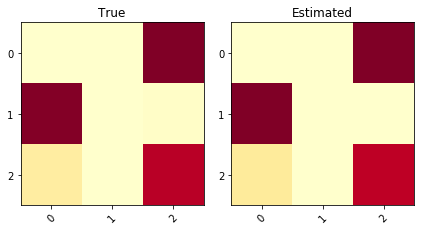

KL divergence: 0.0171	Pearson Correlation between diagonals: 1.0000


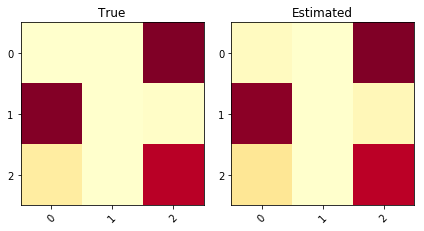

KL divergence: 0.0362	Pearson Correlation between diagonals: 0.9996


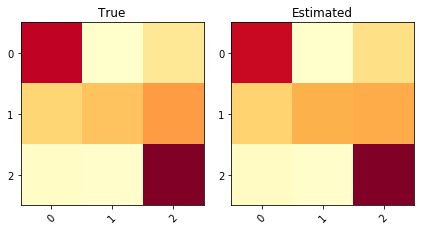

KL divergence: 0.0187	Pearson Correlation between diagonals: 0.9977


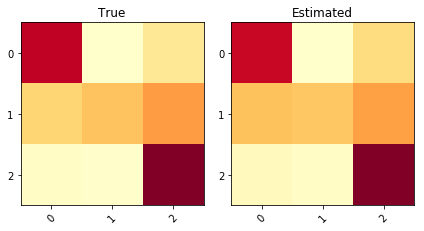

KL divergence: 0.0212	Pearson Correlation between diagonals: 0.9994


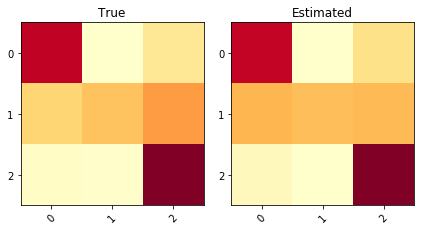

KL divergence: 0.0223	Pearson Correlation between diagonals: 0.9998


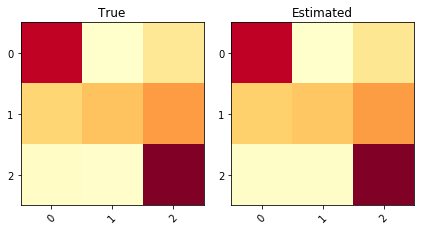

KL divergence: 0.0104	Pearson Correlation between diagonals: 1.0000


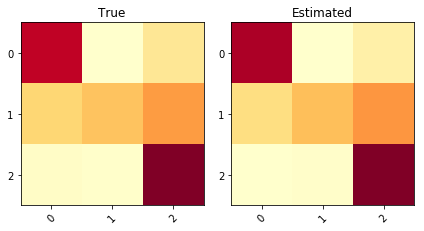

KL divergence: 0.0128	Pearson Correlation between diagonals: 0.9980


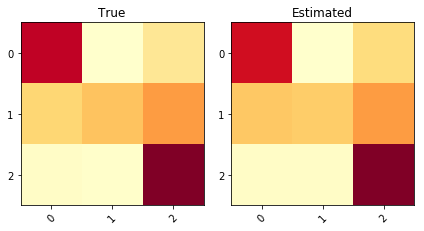

KL divergence: 0.0187	Pearson Correlation between diagonals: 0.9978


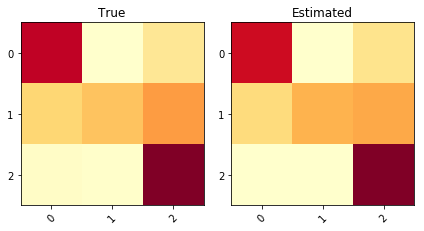

KL divergence: 0.0095	Pearson Correlation between diagonals: 0.9957


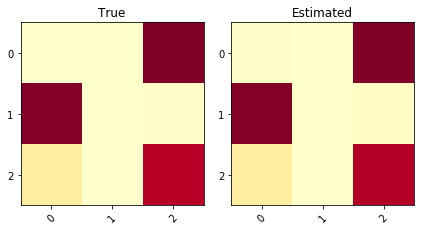

KL divergence: 0.0211	Pearson Correlation between diagonals: 0.9999


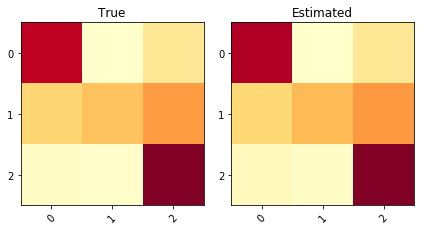

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9991


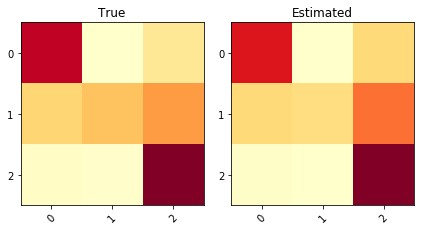

KL divergence: 0.0241	Pearson Correlation between diagonals: 0.9956


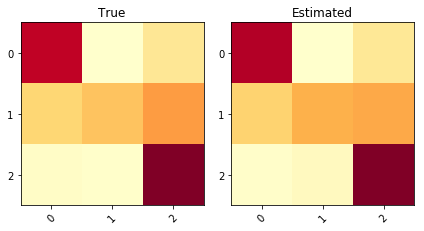

KL divergence: 0.0191	Pearson Correlation between diagonals: 0.9996
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.902705 |     0.902705 |    0.0172518 |              0.992205 |       0.134915 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.734951 |                          0.736316 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [23]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


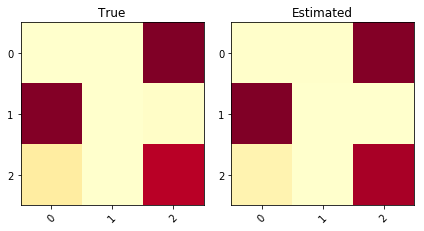

KL divergence: 0.0161	Pearson Correlation between diagonals: 1.0000


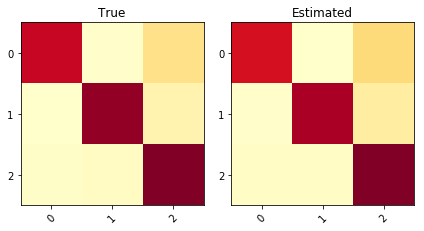

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9818


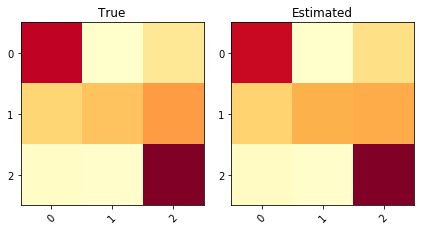

KL divergence: 0.0184	Pearson Correlation between diagonals: 0.9976


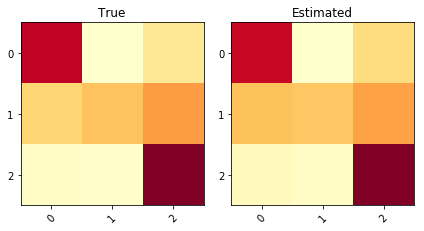

KL divergence: 0.0213	Pearson Correlation between diagonals: 0.9994


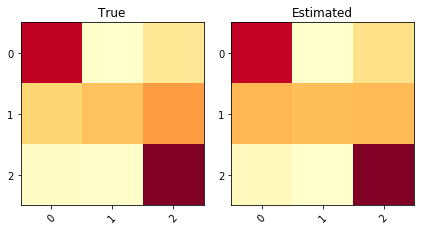

KL divergence: 0.0213	Pearson Correlation between diagonals: 0.9998


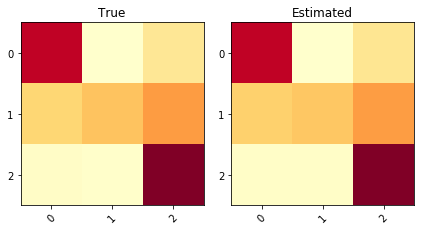

KL divergence: 0.0105	Pearson Correlation between diagonals: 1.0000


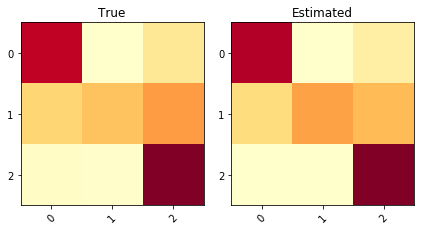

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9999


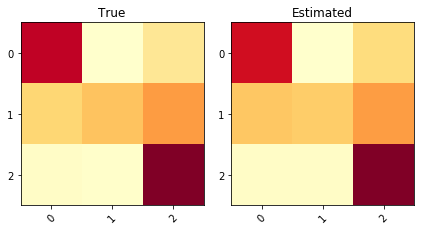

KL divergence: 0.0184	Pearson Correlation between diagonals: 0.9976


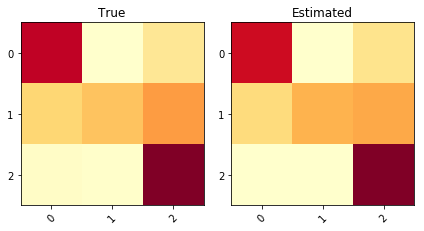

KL divergence: 0.0095	Pearson Correlation between diagonals: 0.9957


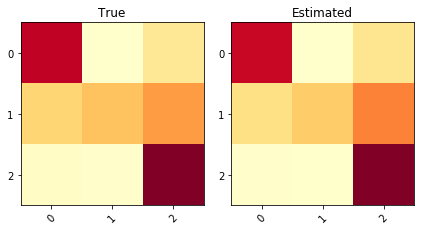

KL divergence: 0.0094	Pearson Correlation between diagonals: 0.9997


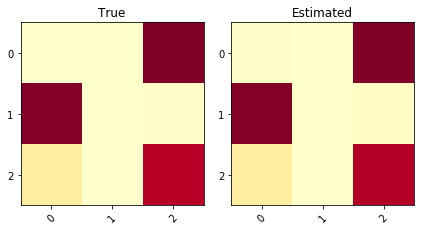

KL divergence: 0.0211	Pearson Correlation between diagonals: 0.9999


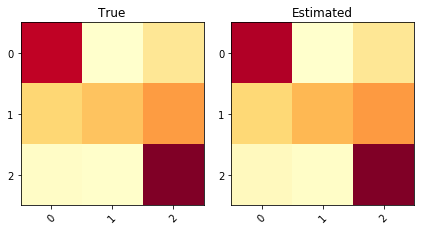

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9991


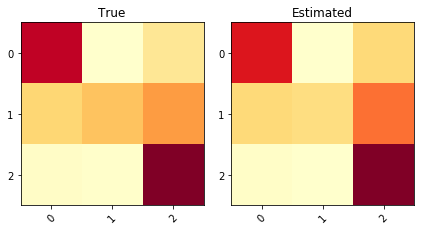

KL divergence: 0.0240	Pearson Correlation between diagonals: 0.9956


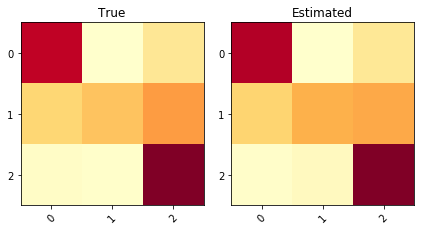

KL divergence: 0.0191	Pearson Correlation between diagonals: 0.9996


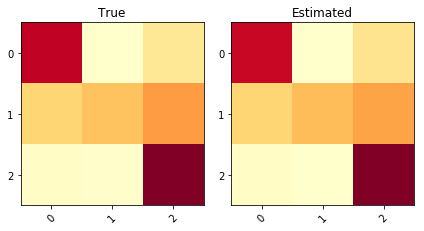

KL divergence: 0.0074	Pearson Correlation between diagonals: 0.9989
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.895288 |     0.895288 |    0.0172657 |              0.992196 |       0.132332 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.756944 |                          0.687978 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [33]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


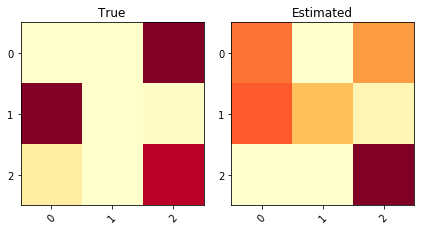

KL divergence: 0.5127	Pearson Correlation between diagonals: 0.9478


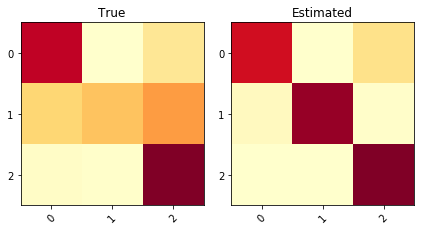

KL divergence: 0.5795	Pearson Correlation between diagonals: -0.0896


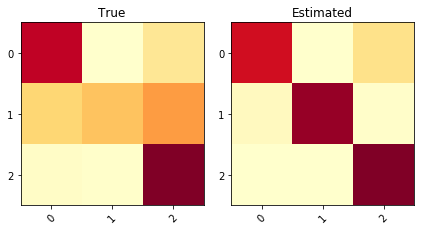

KL divergence: 0.5793	Pearson Correlation between diagonals: -0.0893


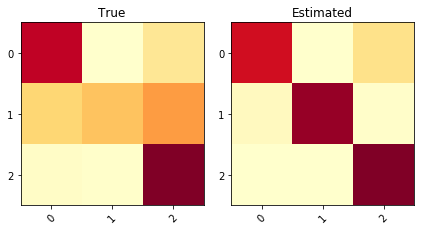

KL divergence: 0.5786	Pearson Correlation between diagonals: -0.0883


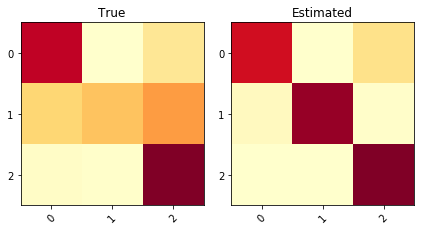

KL divergence: 0.5795	Pearson Correlation between diagonals: -0.0897


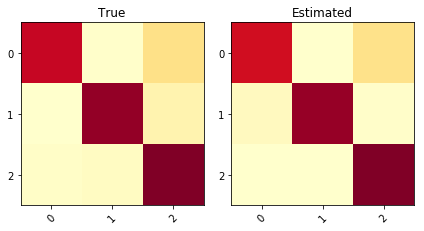

KL divergence: 0.0689	Pearson Correlation between diagonals: 0.9999


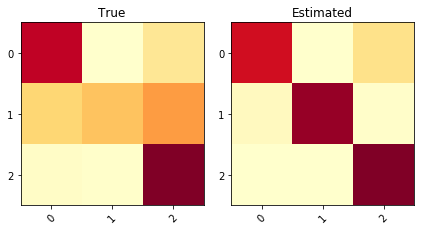

KL divergence: 0.5796	Pearson Correlation between diagonals: -0.0898


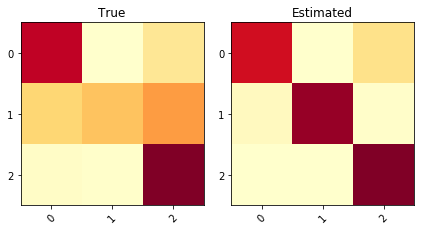

KL divergence: 0.5798	Pearson Correlation between diagonals: -0.0901


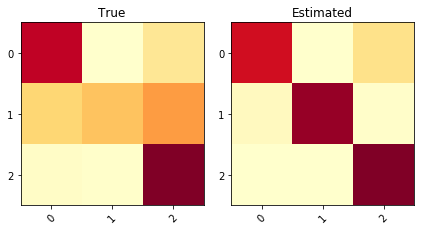

KL divergence: 0.5784	Pearson Correlation between diagonals: -0.0879


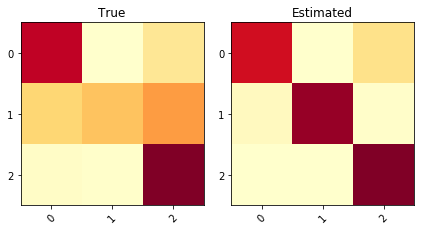

KL divergence: 0.5794	Pearson Correlation between diagonals: -0.0894


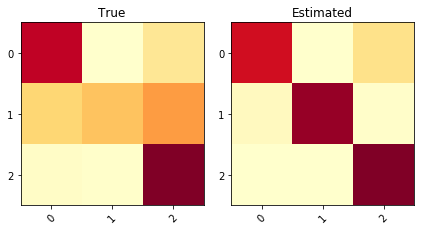

KL divergence: 0.5793	Pearson Correlation between diagonals: -0.0894


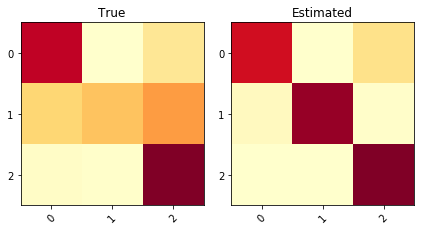

KL divergence: 0.5799	Pearson Correlation between diagonals: -0.0901


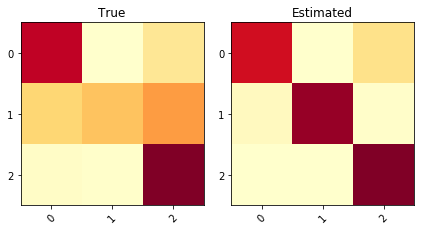

KL divergence: 0.5793	Pearson Correlation between diagonals: -0.0894


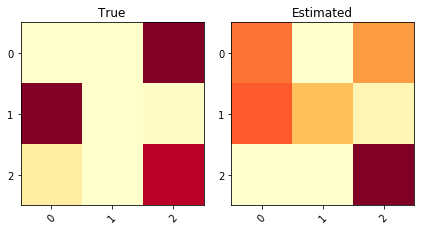

KL divergence: 0.5127	Pearson Correlation between diagonals: 0.9478


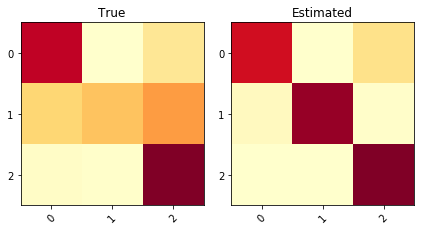

KL divergence: 0.5799	Pearson Correlation between diagonals: -0.0902
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.889616 |     0.889616 |     0.466835 |              0.294222 |      0.0956004 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.693154 |               0.654502 |
+----+-------------------------+------------------------+
Test


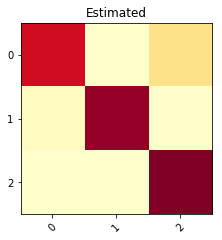

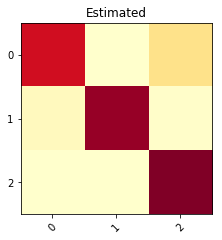

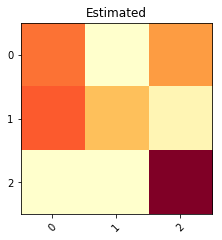

Inertia: 0.06887788977473974
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.242529 |    0.919457 | 0.0880122 |           0.957128 |   0.811765 |     0.811765 |
|  1 |        1 |  0.252344 |    0.917869 | 0.0895521 |           0.956349 |   0.811765 |     0.811765 |
|  2 |        2 |  0.547832 |    0.623329 | 0.571695  |           0.753322 |   0.427451 |     0.427451 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.884967 |     0.884967 |
+----+--------+------------+------------

In [19]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


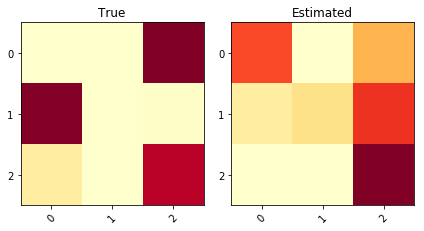

KL divergence: 1.1224	Pearson Correlation between diagonals: 0.8390


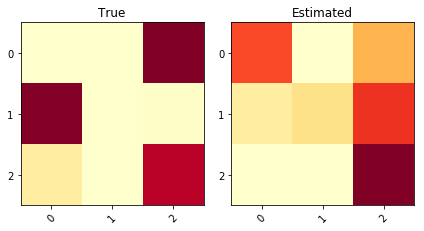

KL divergence: 1.1224	Pearson Correlation between diagonals: 0.8390


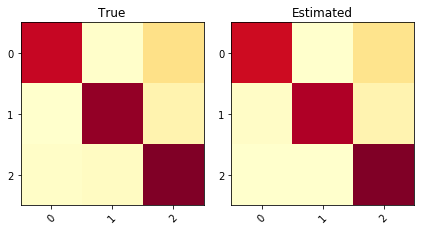

KL divergence: 0.0440	Pearson Correlation between diagonals: 0.9529


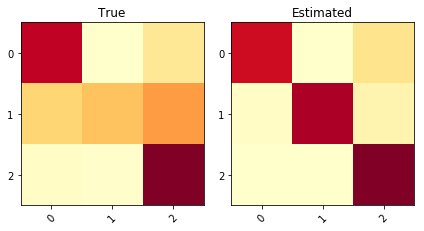

KL divergence: 0.3691	Pearson Correlation between diagonals: 0.2314


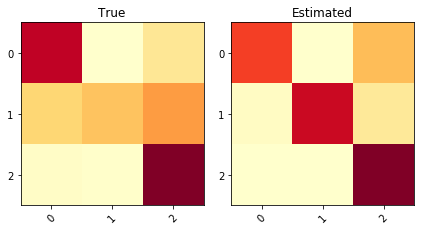

KL divergence: 0.2958	Pearson Correlation between diagonals: 0.1912


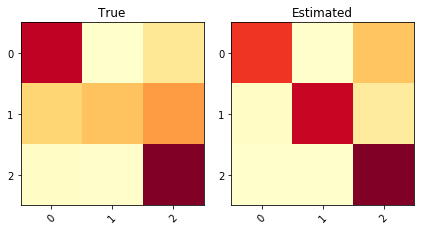

KL divergence: 0.3014	Pearson Correlation between diagonals: 0.1941


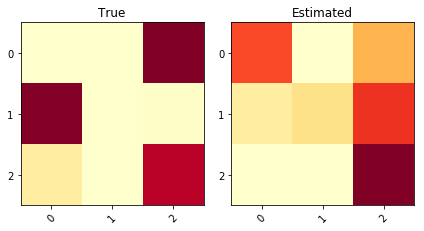

KL divergence: 1.1224	Pearson Correlation between diagonals: 0.8390


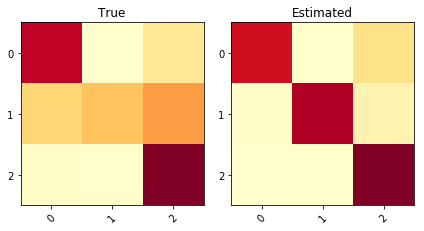

KL divergence: 0.3582	Pearson Correlation between diagonals: 0.2251


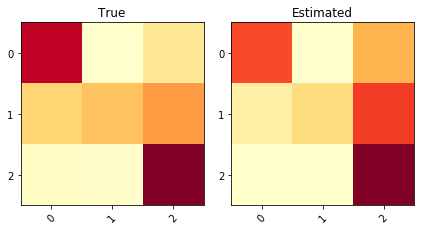

KL divergence: 0.0824	Pearson Correlation between diagonals: 0.9576


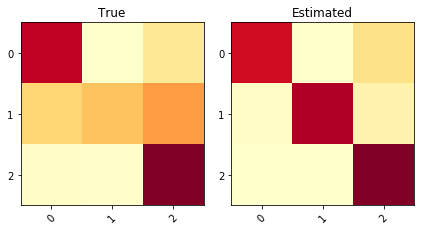

KL divergence: 0.3606	Pearson Correlation between diagonals: 0.2265


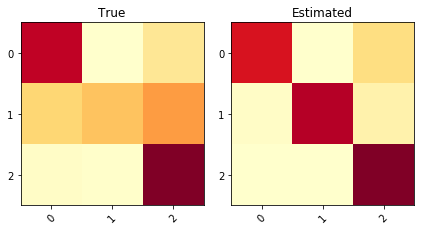

KL divergence: 0.3458	Pearson Correlation between diagonals: 0.2182


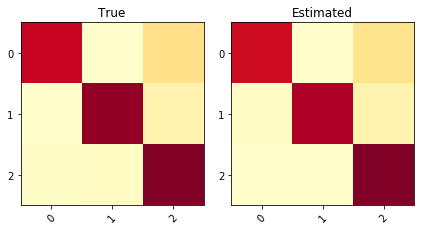

KL divergence: 0.0440	Pearson Correlation between diagonals: 0.9527


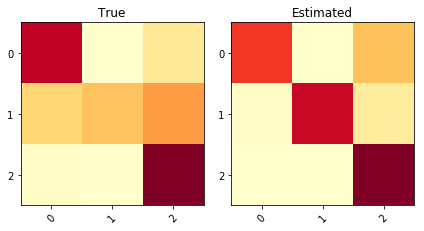

KL divergence: 0.2990	Pearson Correlation between diagonals: 0.1927


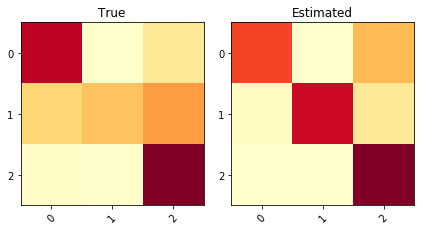

KL divergence: 0.2935	Pearson Correlation between diagonals: 0.1890


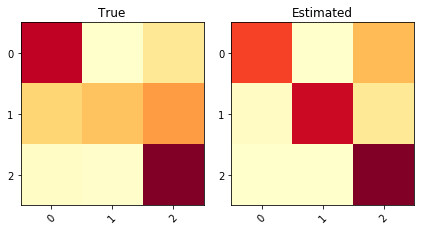

KL divergence: 0.2940	Pearson Correlation between diagonals: 0.1894
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.896597 |     0.896597 |     0.390277 |              0.482194 |       0.042371 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.66464 |               0.678071 |
+----+-------------------------+------------------------+
Test


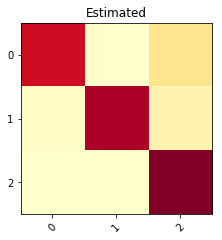

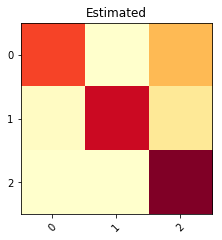

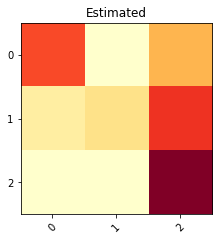

Inertia: 0.06449716188944876
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.285473 |    0.90655  |  0.101399 |           0.950495 |   0.877124 |     0.877124 |
|  1 |        1 |  0.399035 |    0.824705 |  0.207945 |           0.90136  |   0.807843 |     0.807843 |
|  2 |        2 |  0.509679 |    0.608345 |  0.698066 |           0.72292  |   0.614379 |     0.614379 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.898039 |     0.898039 |
+----+--------+------------+------------

In [22]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


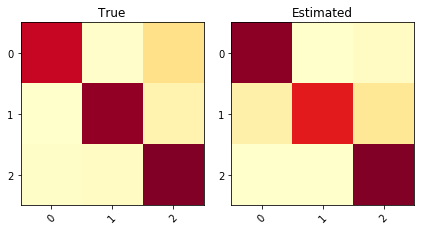

KL divergence: 0.1440	Pearson Correlation between diagonals: -0.1600


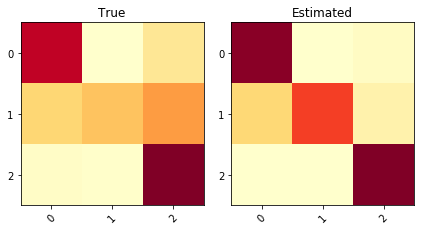

KL divergence: 0.2096	Pearson Correlation between diagonals: 0.9913


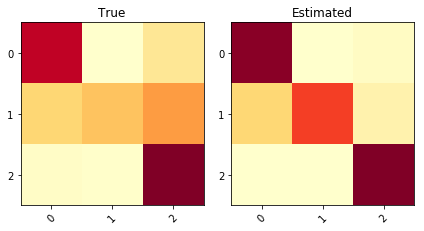

KL divergence: 0.2118	Pearson Correlation between diagonals: 0.9912


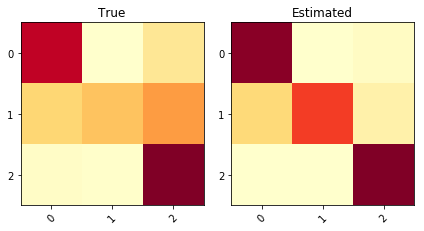

KL divergence: 0.2059	Pearson Correlation between diagonals: 0.9916


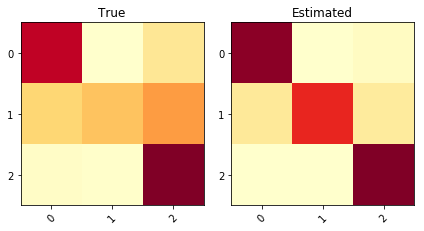

KL divergence: 0.1828	Pearson Correlation between diagonals: 0.9946


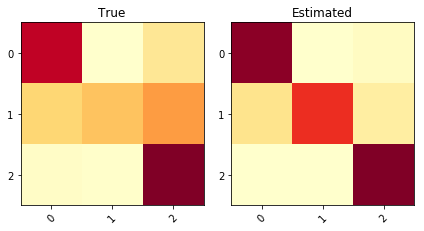

KL divergence: 0.1865	Pearson Correlation between diagonals: 0.9935


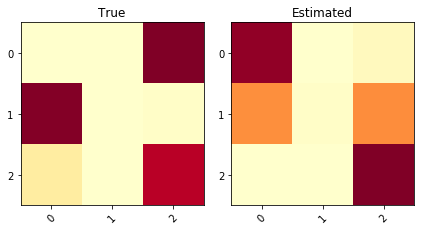

KL divergence: 1.3588	Pearson Correlation between diagonals: 0.5331


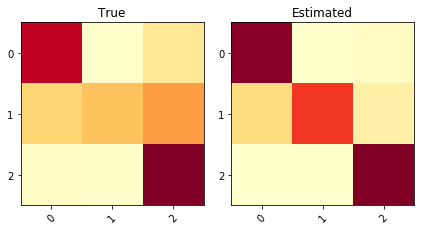

KL divergence: 0.1977	Pearson Correlation between diagonals: 0.9922


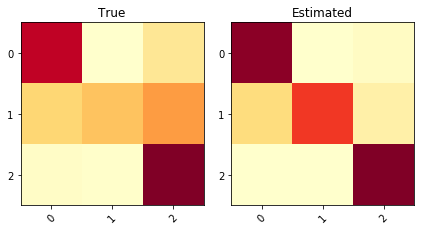

KL divergence: 0.1985	Pearson Correlation between diagonals: 0.9921


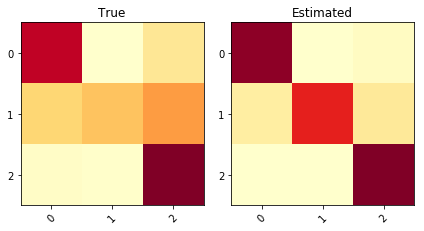

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.9957


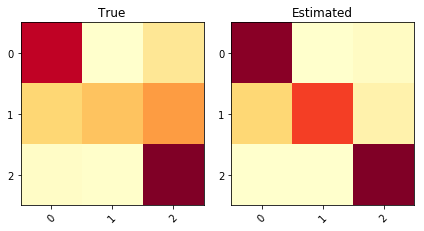

KL divergence: 0.2105	Pearson Correlation between diagonals: 0.9913


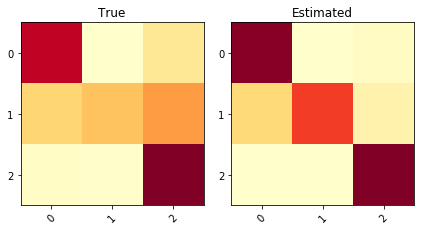

KL divergence: 0.2071	Pearson Correlation between diagonals: 0.9915


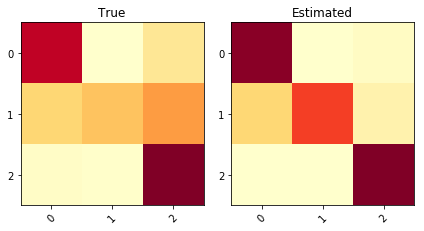

KL divergence: 0.2111	Pearson Correlation between diagonals: 0.9912


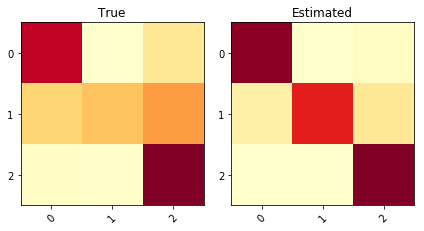

KL divergence: 0.1874	Pearson Correlation between diagonals: 0.9962


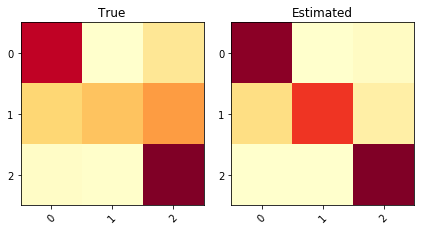

KL divergence: 0.1936	Pearson Correlation between diagonals: 0.9926
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.936736 |     0.936736 |     0.370716 |              0.688981 |      0.0528811 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.668251 |                0.69475 |
+----+-------------------------+------------------------+
Test


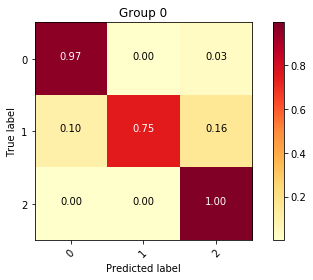

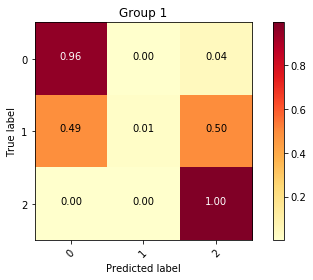

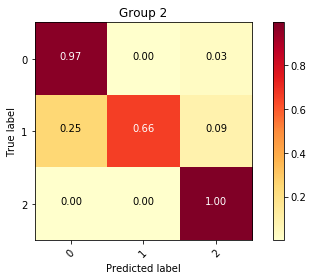

Inertia: 0.08106997329741716
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.302278 |    0.903248 |  0.110042 |           0.947068 |   0.915033 |     0.915033 |
|  1 |        1 |  0.321652 |    0.655811 |  1.43281  |           0.676771 |   0.616993 |     0.616993 |
|  2 |        2 |  0.33149  |    0.875725 |  0.149862 |           0.929293 |   0.91634  |     0.91634  |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.930719 |     0.930719 |
+----+--------+------------+------------

In [16]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [19]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6208551483420593


In [20]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.462042 |     0.462042 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.453595 |     0.453595 |
+----+--------+------------+--------------+


In [21]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.572426 |     0.572426 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.573856 |     0.573856 |
+----+--------+------------+--------------+


In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.945462 |     0.945462 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.945098 |     0.945098 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


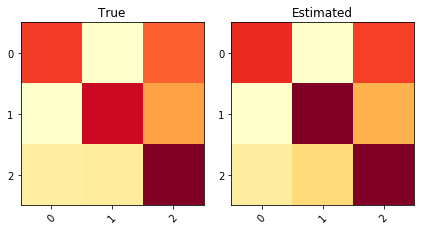

KL divergence: 0.0199	Pearson Correlation between diagonals: 0.8477


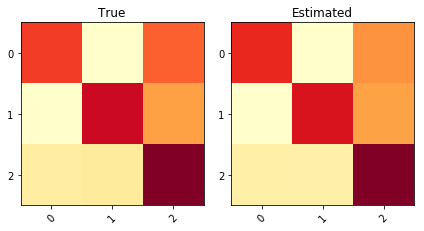

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9588


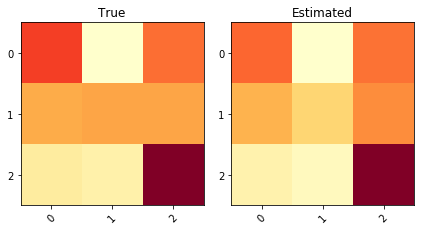

KL divergence: 0.0191	Pearson Correlation between diagonals: 1.0000


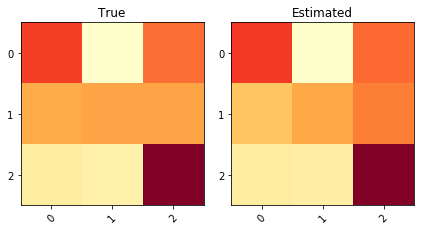

KL divergence: 0.0129	Pearson Correlation between diagonals: 0.9991


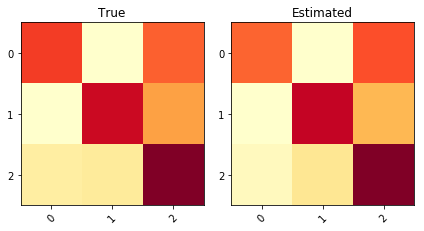

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9815


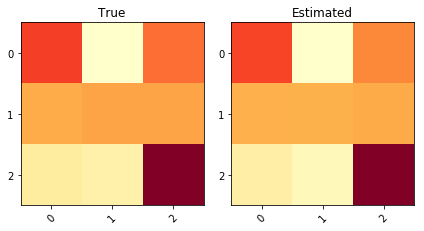

KL divergence: 0.0065	Pearson Correlation between diagonals: 0.9999


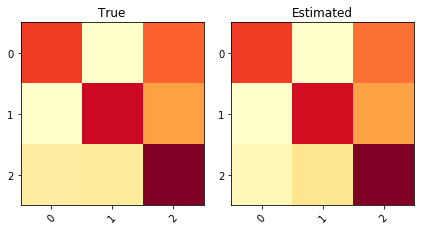

KL divergence: 0.0156	Pearson Correlation between diagonals: 0.9969


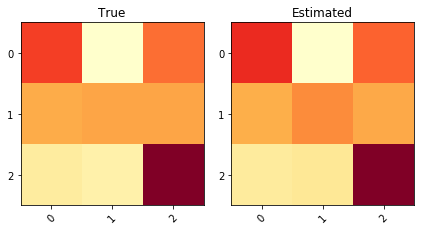

KL divergence: 0.0124	Pearson Correlation between diagonals: 1.0000


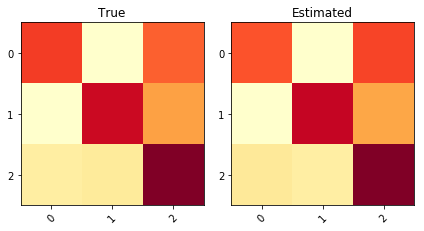

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9889


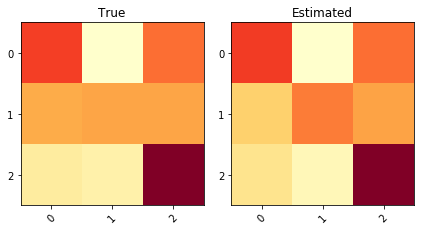

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9904


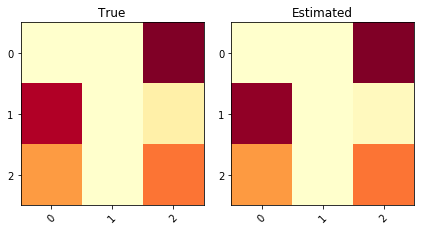

KL divergence: 0.0236	Pearson Correlation between diagonals: 1.0000


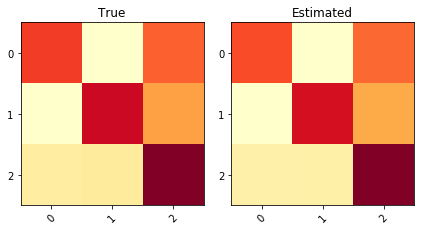

KL divergence: 0.0096	Pearson Correlation between diagonals: 0.9998


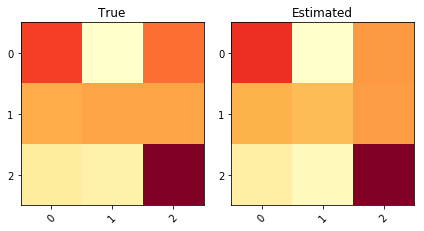

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9901


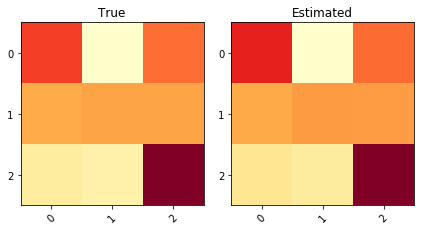

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9945


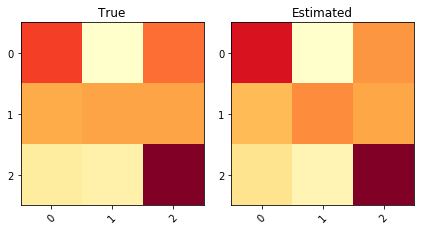

KL divergence: 0.0139	Pearson Correlation between diagonals: 0.9852
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.904014 |     0.904014 |    0.0172159 |              0.978584 |       0.138445 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.571256 |                          0.845189 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


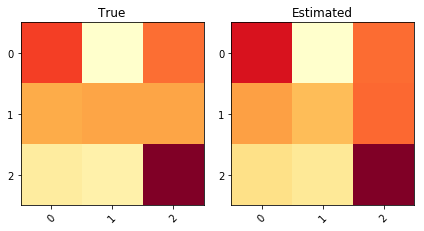

KL divergence: 0.0208	Pearson Correlation between diagonals: 0.9592


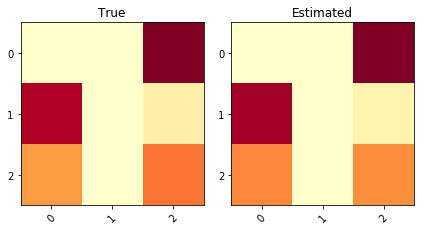

KL divergence: 0.0210	Pearson Correlation between diagonals: 1.0000


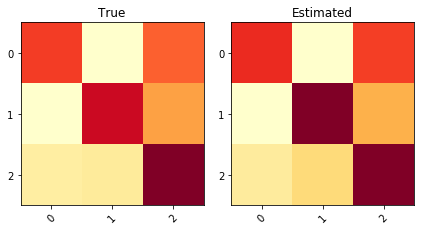

KL divergence: 0.0191	Pearson Correlation between diagonals: 0.8566


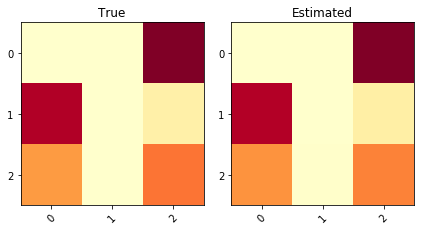

KL divergence: 0.0182	Pearson Correlation between diagonals: 1.0000


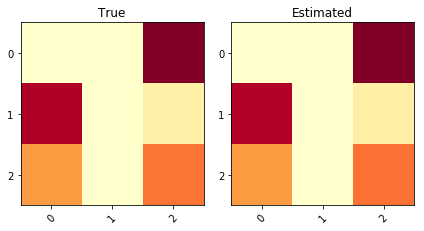

KL divergence: 0.0164	Pearson Correlation between diagonals: 1.0000


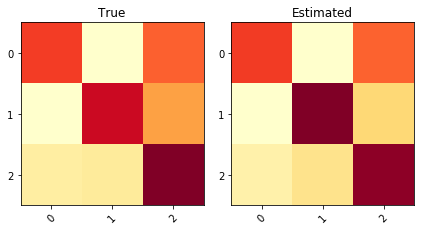

KL divergence: 0.0278	Pearson Correlation between diagonals: 0.8053


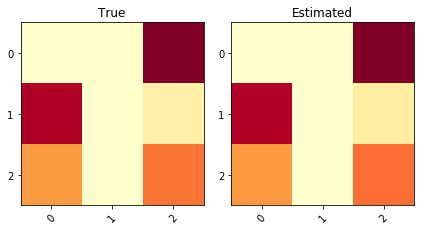

KL divergence: 0.0208	Pearson Correlation between diagonals: 0.9999


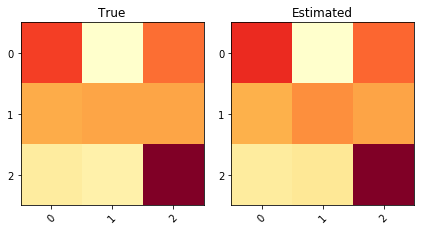

KL divergence: 0.0117	Pearson Correlation between diagonals: 0.9999


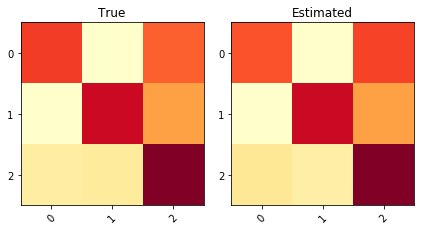

KL divergence: 0.0128	Pearson Correlation between diagonals: 0.9950


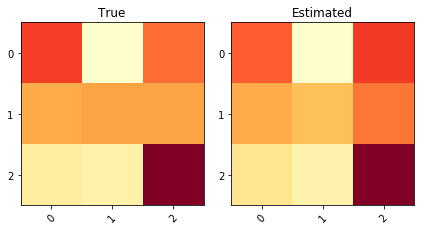

KL divergence: 0.0177	Pearson Correlation between diagonals: 0.9997


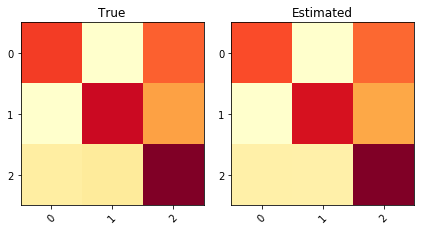

KL divergence: 0.0098	Pearson Correlation between diagonals: 0.9990


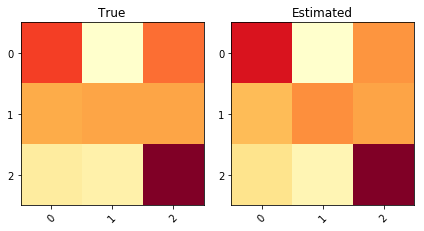

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9853


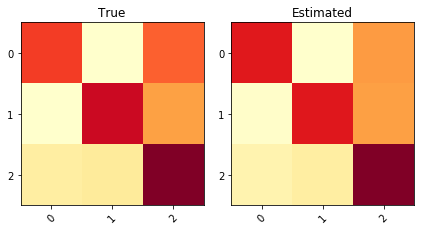

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.8884


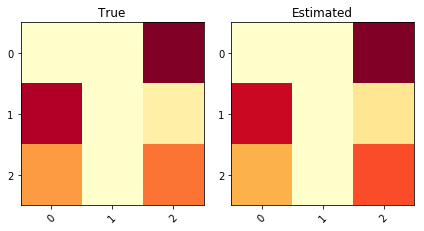

KL divergence: 0.0270	Pearson Correlation between diagonals: 1.0000


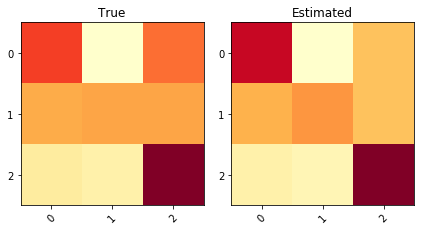

KL divergence: 0.0323	Pearson Correlation between diagonals: 0.9497
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.937609 |     0.937609 |    0.0171666 |              0.978929 |       0.130713 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.594826 |                          0.829137 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [23]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


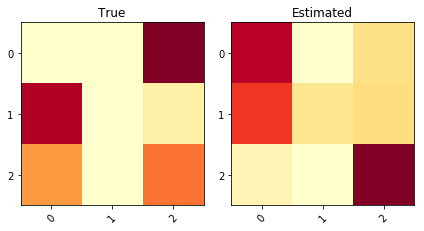

KL divergence: 0.8191	Pearson Correlation between diagonals: 0.6187


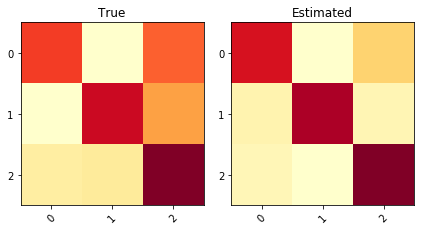

KL divergence: 0.3089	Pearson Correlation between diagonals: 0.9952


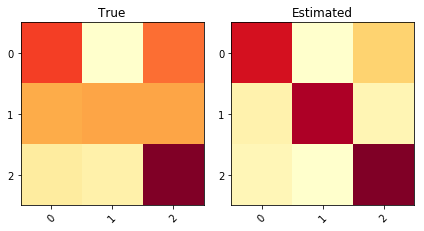

KL divergence: 0.3527	Pearson Correlation between diagonals: 0.5437


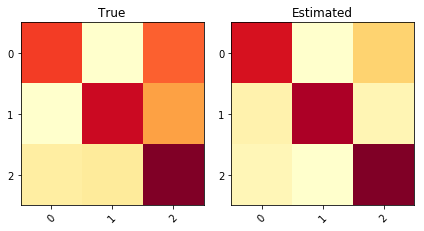

KL divergence: 0.3092	Pearson Correlation between diagonals: 0.9958


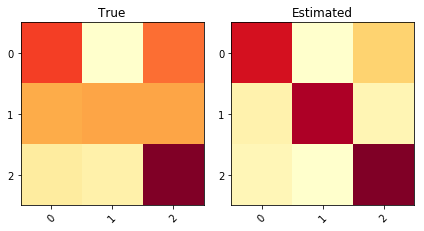

KL divergence: 0.3530	Pearson Correlation between diagonals: 0.5418


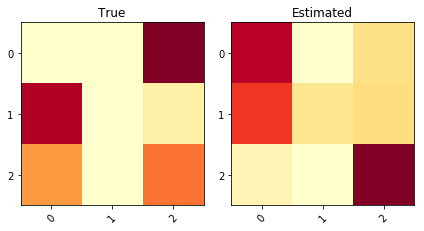

KL divergence: 0.8191	Pearson Correlation between diagonals: 0.6187


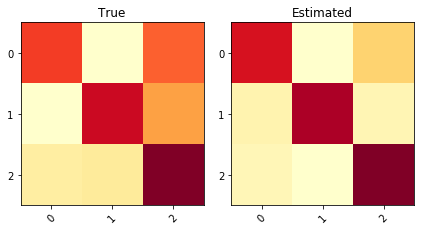

KL divergence: 0.3089	Pearson Correlation between diagonals: 0.9952


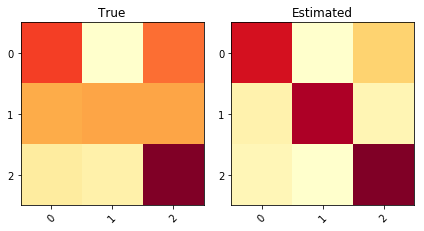

KL divergence: 0.3526	Pearson Correlation between diagonals: 0.5450


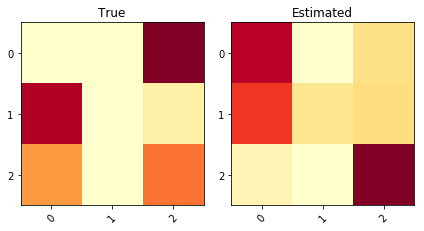

KL divergence: 0.8191	Pearson Correlation between diagonals: 0.6187


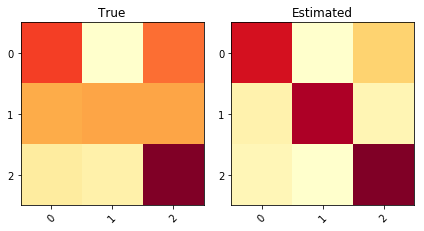

KL divergence: 0.3535	Pearson Correlation between diagonals: 0.5375


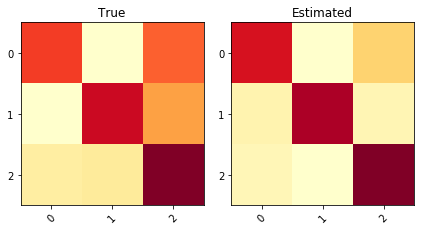

KL divergence: 0.3091	Pearson Correlation between diagonals: 0.9956


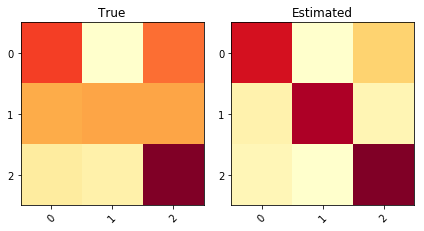

KL divergence: 0.3533	Pearson Correlation between diagonals: 0.5391


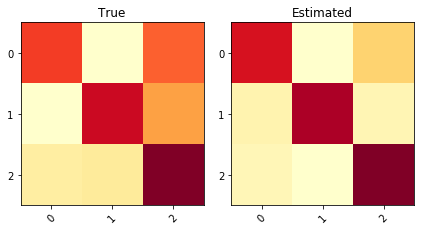

KL divergence: 0.3090	Pearson Correlation between diagonals: 0.9955


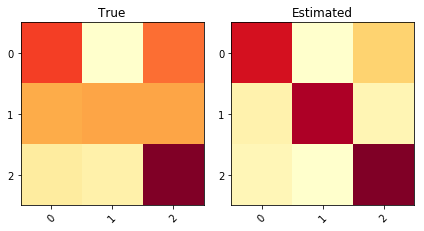

KL divergence: 0.3528	Pearson Correlation between diagonals: 0.5434


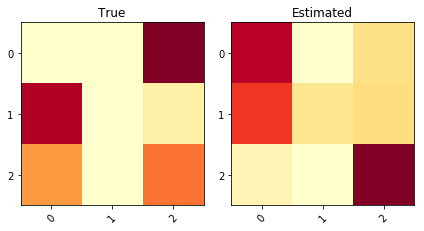

KL divergence: 0.8191	Pearson Correlation between diagonals: 0.6187
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.811518 |     0.811518 |     0.406222 |              0.676317 |       0.116598 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.581522 |               0.816666 |
+----+-------------------------+------------------------+
Test


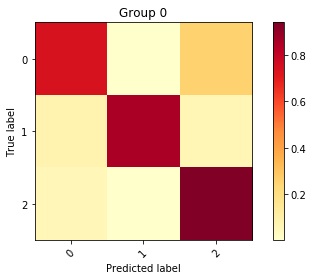

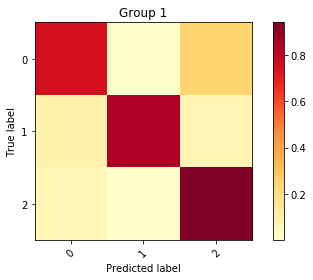

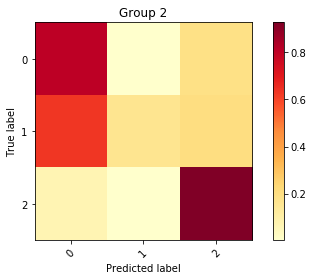

Inertia: 0.06470905197784305
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.436847 |    0.847319 |  0.170389 |           0.917554 |   0.545098 |     0.545098 |
|  1 |        1 |  0.44411  |    0.846018 |  0.171337 |           0.917012 |   0.545098 |     0.545098 |
|  2 |        2 |  0.563047 |    0.632923 |  0.699663 |           0.733364 |   0.363399 |     0.363399 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.792157 |     0.792157 |
+----+--------+------------+------------

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


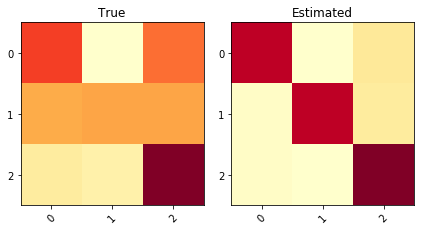

KL divergence: 0.5447	Pearson Correlation between diagonals: 0.9140


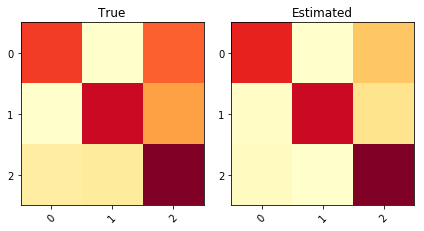

KL divergence: 0.2189	Pearson Correlation between diagonals: 0.9945


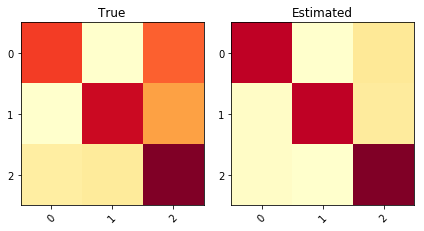

KL divergence: 0.3358	Pearson Correlation between diagonals: 0.8816


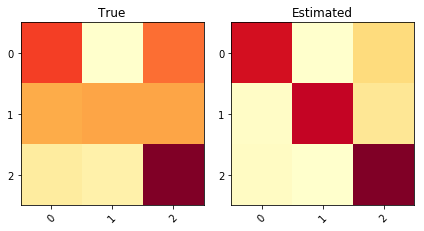

KL divergence: 0.4667	Pearson Correlation between diagonals: 0.7768


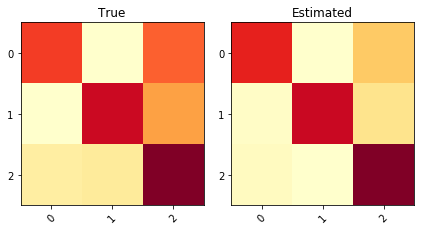

KL divergence: 0.2225	Pearson Correlation between diagonals: 0.9934


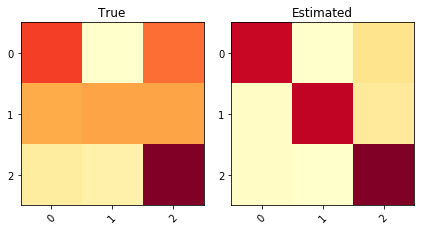

KL divergence: 0.5051	Pearson Correlation between diagonals: 0.8487


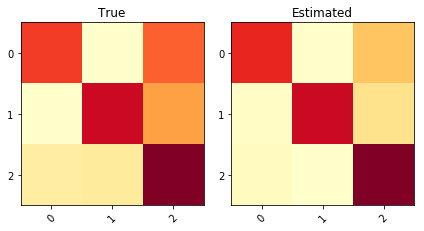

KL divergence: 0.2151	Pearson Correlation between diagonals: 0.9956


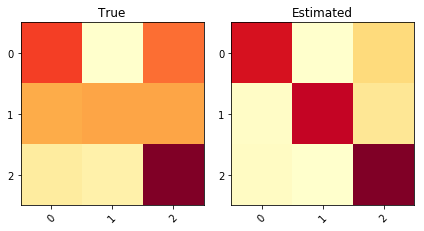

KL divergence: 0.4623	Pearson Correlation between diagonals: 0.7682


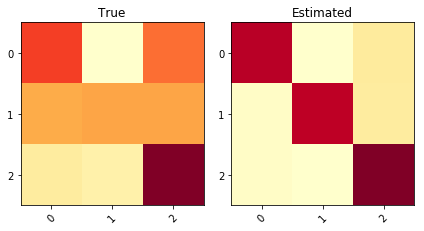

KL divergence: 0.5613	Pearson Correlation between diagonals: 0.9370


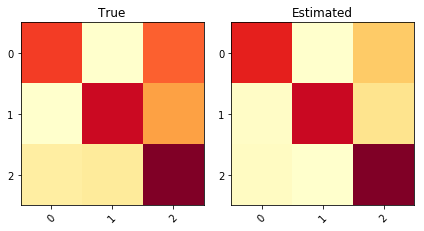

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9928


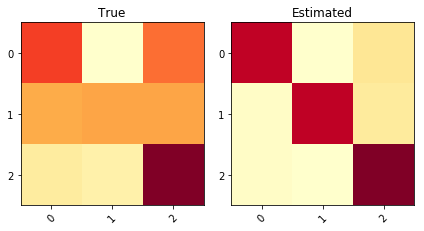

KL divergence: 0.5340	Pearson Correlation between diagonals: 0.8977


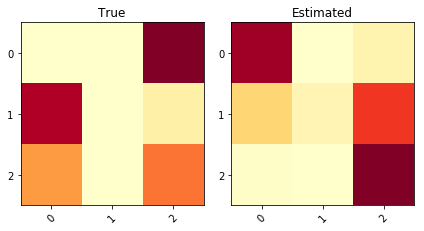

KL divergence: 1.5246	Pearson Correlation between diagonals: 0.5547


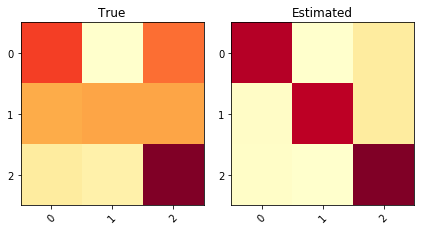

KL divergence: 0.5719	Pearson Correlation between diagonals: 0.9500


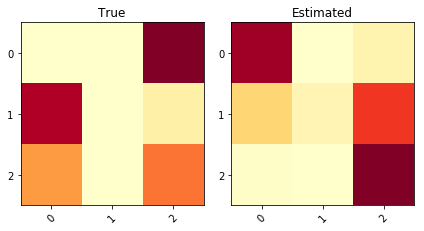

KL divergence: 1.5246	Pearson Correlation between diagonals: 0.5547


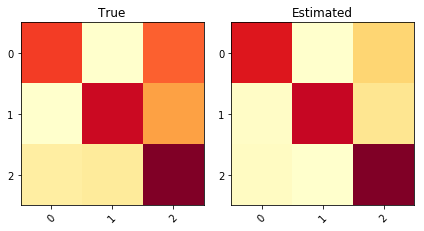

KL divergence: 0.2431	Pearson Correlation between diagonals: 0.9845
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.842932 |     0.842932 |     0.575574 |              0.834427 |      0.0706584 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.542183 |               0.824472 |
+----+-------------------------+------------------------+
Test


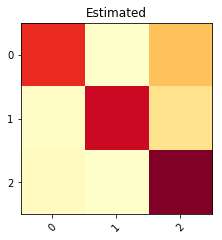

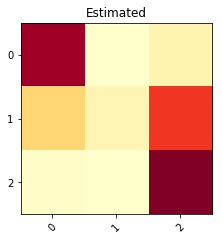

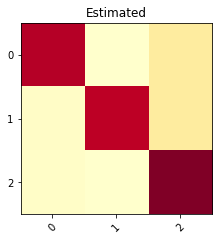

Inertia: 0.09083747211843729
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.446232 |    0.818332 |  0.210108 |           0.899486 |   0.500654 |     0.500654 |
|  1 |        1 |  0.404119 |    0.656614 |  0.905881 |           0.713379 |   0.452288 |     0.452288 |
|  2 |        2 |  0.309366 |    0.905541 |  0.101072 |           0.950443 |   0.640523 |     0.640523 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.822222 |     0.822222 |
+----+--------+------------+------------

In [34]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


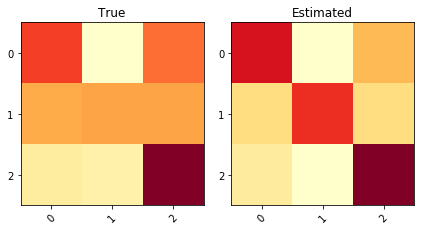

KL divergence: 0.1336	Pearson Correlation between diagonals: 0.9889


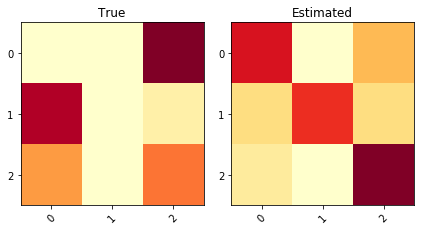

KL divergence: 0.9438	Pearson Correlation between diagonals: 0.9603


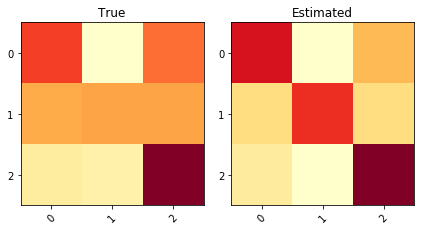

KL divergence: 0.1336	Pearson Correlation between diagonals: 0.9889


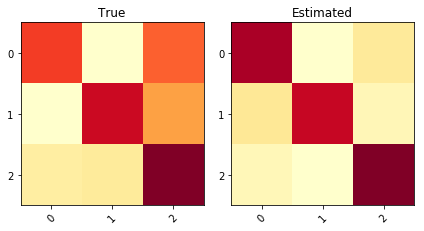

KL divergence: 0.4336	Pearson Correlation between diagonals: 0.5777


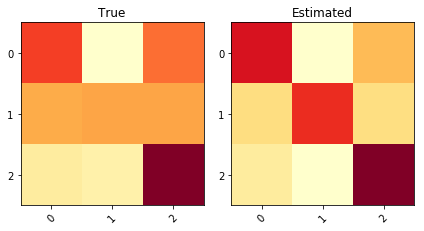

KL divergence: 0.1364	Pearson Correlation between diagonals: 0.9892


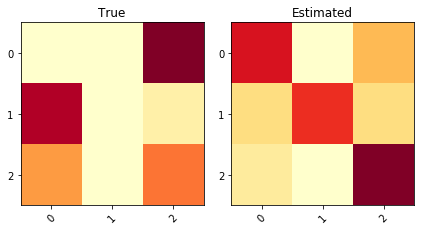

KL divergence: 0.9431	Pearson Correlation between diagonals: 0.9604


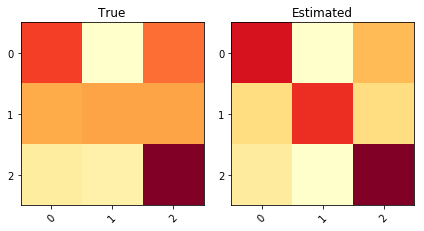

KL divergence: 0.1351	Pearson Correlation between diagonals: 0.9891


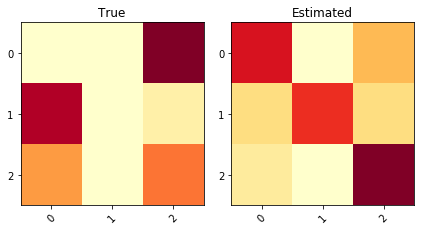

KL divergence: 0.9431	Pearson Correlation between diagonals: 0.9604


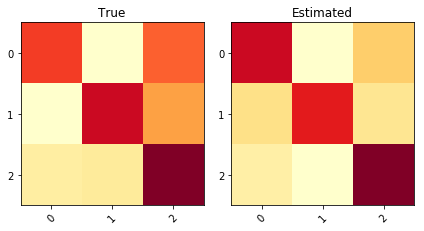

KL divergence: 0.2393	Pearson Correlation between diagonals: 0.6886


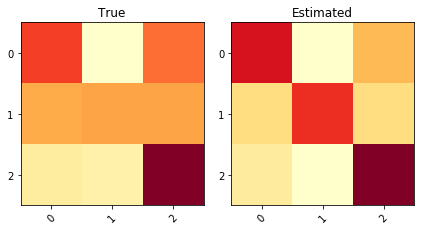

KL divergence: 0.1338	Pearson Correlation between diagonals: 0.9889


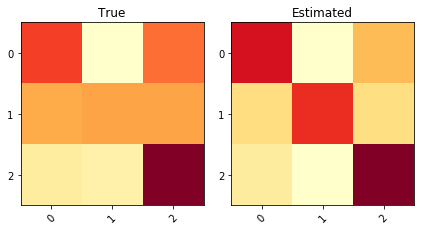

KL divergence: 0.1372	Pearson Correlation between diagonals: 0.9893


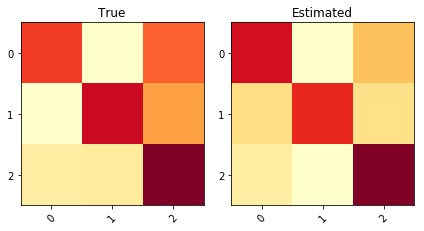

KL divergence: 0.2162	Pearson Correlation between diagonals: 0.7046


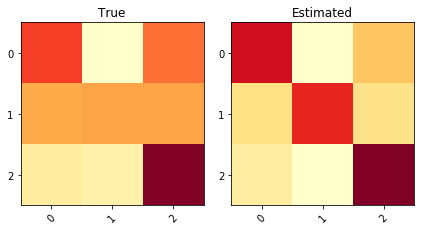

KL divergence: 0.1566	Pearson Correlation between diagonals: 0.9913


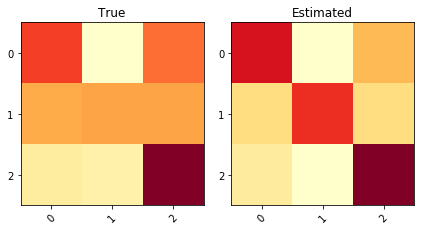

KL divergence: 0.1336	Pearson Correlation between diagonals: 0.9889


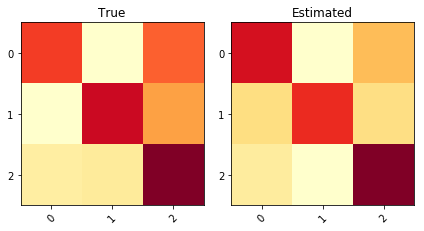

KL divergence: 0.2096	Pearson Correlation between diagonals: 0.7096
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.906195 |     0.906195 |     0.294791 |               0.89651 |        0.12239 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.558361 |               0.856256 |
+----+-------------------------+------------------------+
Test


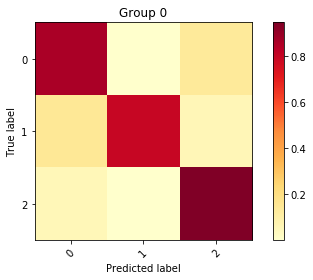

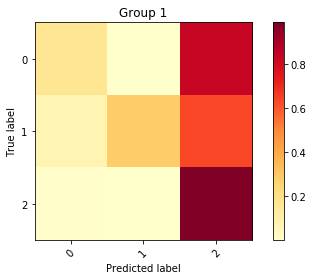

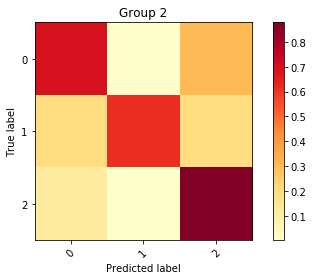

Inertia: 0.097741017350927
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.411819 |    0.869491 |  0.142274 |           0.930643 |   0.738562 |     0.738562 |
|  1 |        1 |  0.454669 |    0.481844 |  1.01388  |           0.611729 |   0.322876 |     0.322876 |
|  2 |        2 |  0.648664 |    0.728034 |  0.32858  |           0.845097 |   0.449673 |     0.449673 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.882353 |     0.882353 |
+----+--------+------------+--------------

In [24]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [45]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.81282722513089


In [46]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.725131 |     0.725131 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.71634 |      0.71634 |
+----+--------+------------+--------------+


In [47]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.808464 |     0.808464 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.80915 |      0.80915 |
+----+--------+------------+--------------+


In [48]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.946335 |     0.946335 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.942484 |     0.942484 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


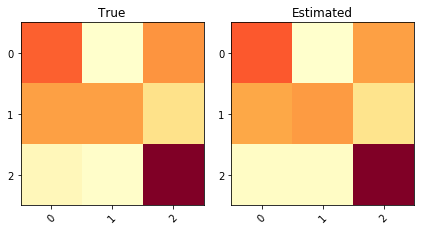

KL divergence: 0.0206	Pearson Correlation between diagonals: 0.9999


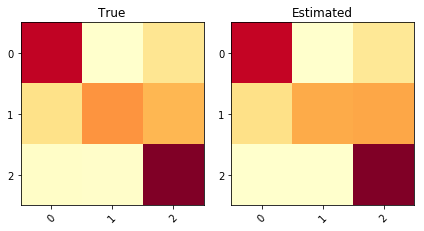

KL divergence: 0.0071	Pearson Correlation between diagonals: 0.9997


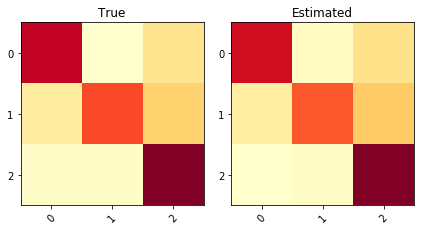

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9957


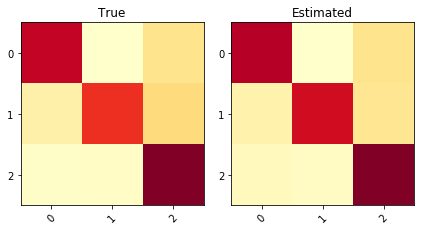

KL divergence: 0.0183	Pearson Correlation between diagonals: 0.9916


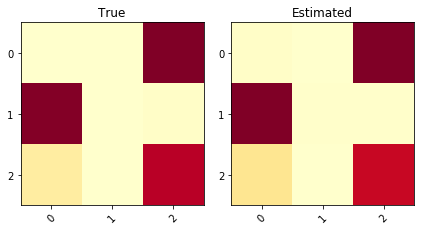

KL divergence: 0.0221	Pearson Correlation between diagonals: 1.0000


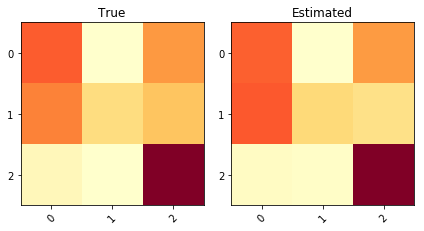

KL divergence: 0.0206	Pearson Correlation between diagonals: 0.9996


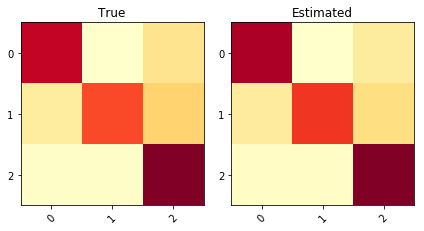

KL divergence: 0.0084	Pearson Correlation between diagonals: 0.9935


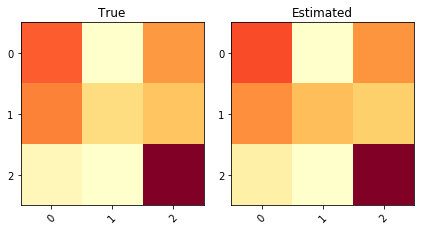

KL divergence: 0.0197	Pearson Correlation between diagonals: 0.9992


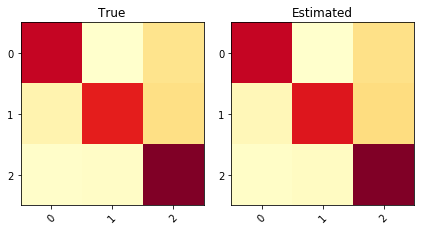

KL divergence: 0.0066	Pearson Correlation between diagonals: 0.9975


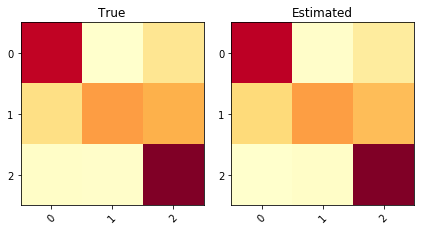

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9997


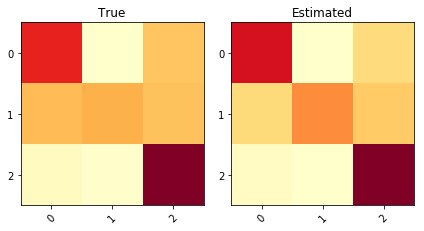

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9997


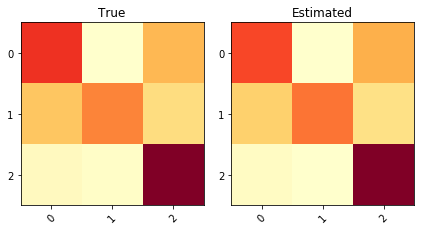

KL divergence: 0.0052	Pearson Correlation between diagonals: 0.9840


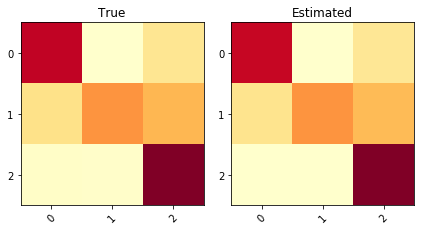

KL divergence: 0.0038	Pearson Correlation between diagonals: 0.9996


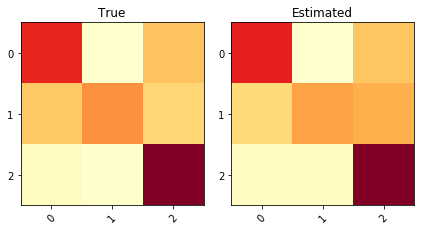

KL divergence: 0.0170	Pearson Correlation between diagonals: 0.9964


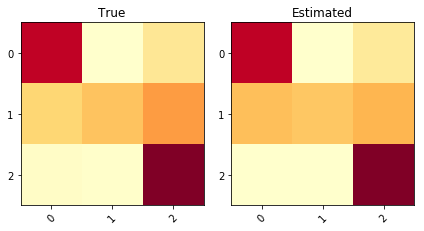

KL divergence: 0.0113	Pearson Correlation between diagonals: 1.0000
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.927574 |     0.927574 |    0.0134671 |              0.993623 |      0.0812075 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.666435 |                          0.791672 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [49]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


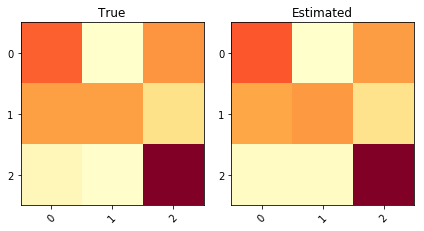

KL divergence: 0.0195	Pearson Correlation between diagonals: 0.9999


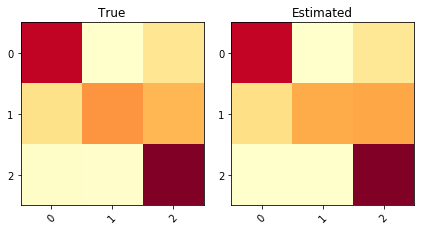

KL divergence: 0.0074	Pearson Correlation between diagonals: 0.9995


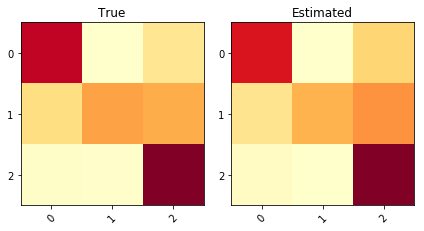

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9923


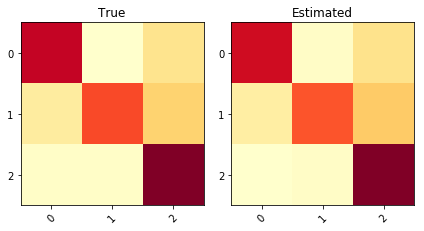

KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9968


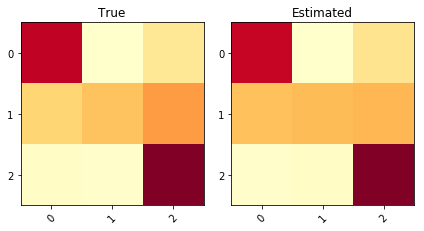

KL divergence: 0.0176	Pearson Correlation between diagonals: 0.9995


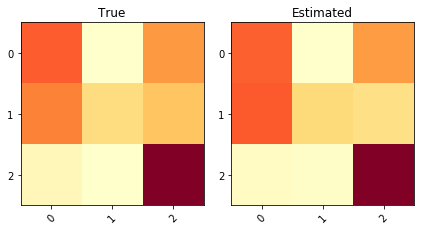

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9997


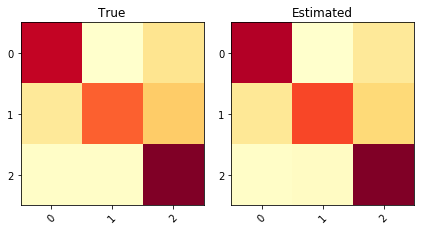

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9980


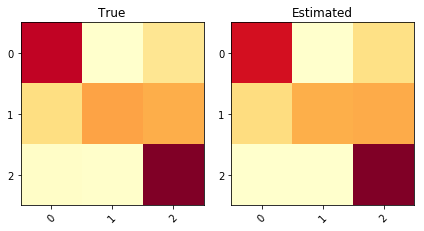

KL divergence: 0.0072	Pearson Correlation between diagonals: 0.9958


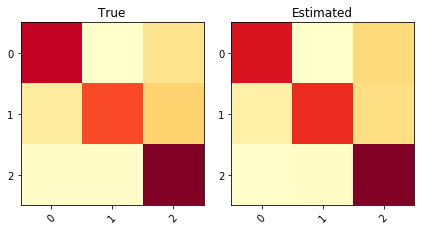

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9271


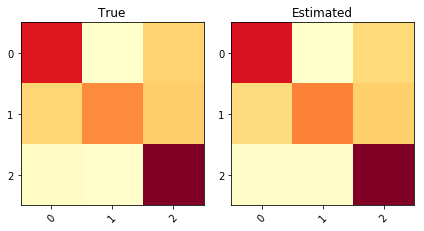

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9999


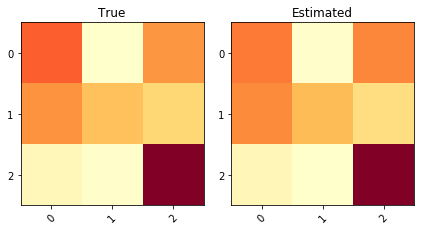

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9939


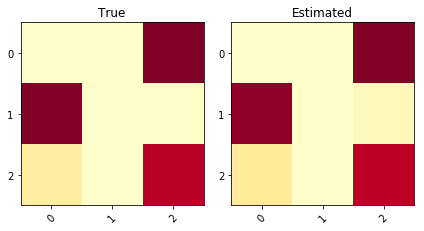

KL divergence: 0.0235	Pearson Correlation between diagonals: 1.0000


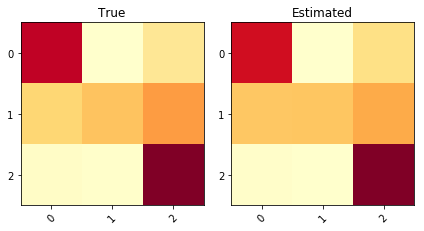

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9973


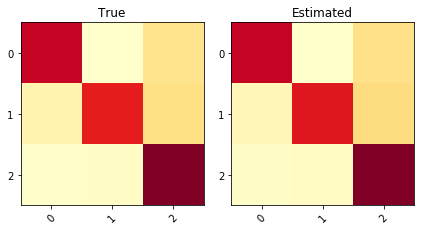

KL divergence: 0.0065	Pearson Correlation between diagonals: 0.9978


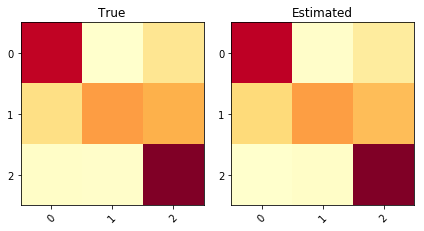

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9996
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.922339 |     0.922339 |    0.0131962 |              0.993913 |      0.0946202 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.664752 |                          0.798222 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [51]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


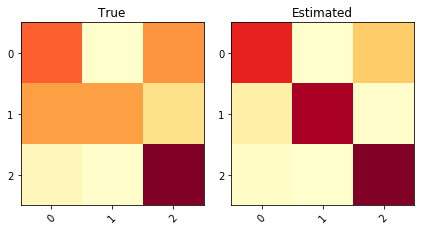

KL divergence: 0.3082	Pearson Correlation between diagonals: 0.5562


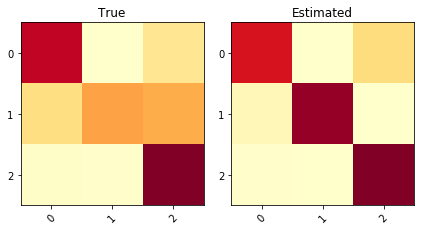

KL divergence: 0.6010	Pearson Correlation between diagonals: -0.0748


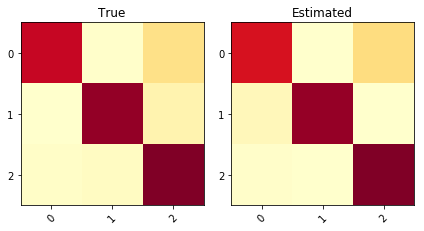

KL divergence: 0.1025	Pearson Correlation between diagonals: 0.9984


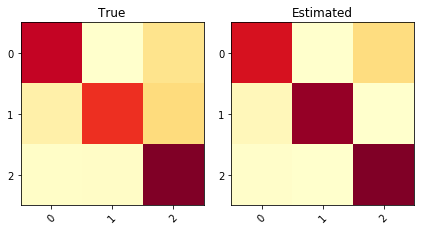

KL divergence: 0.2892	Pearson Correlation between diagonals: 0.1997


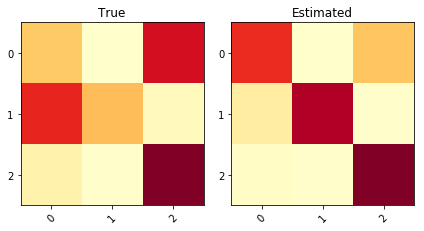

KL divergence: 0.4342	Pearson Correlation between diagonals: 0.7988


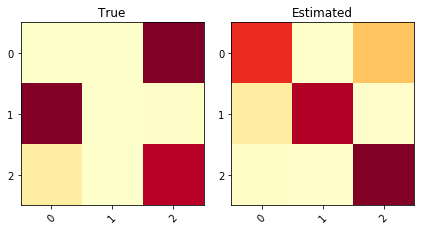

KL divergence: 1.1285	Pearson Correlation between diagonals: 0.7658


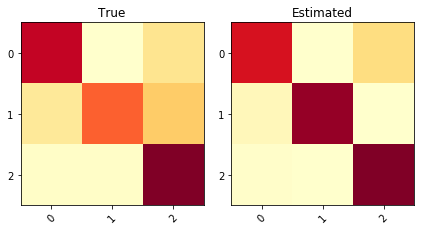

KL divergence: 0.4090	Pearson Correlation between diagonals: 0.0350


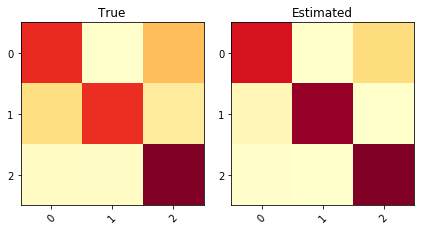

KL divergence: 0.1941	Pearson Correlation between diagonals: 0.6416


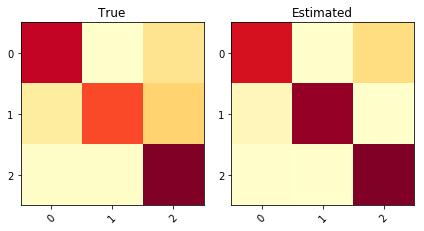

KL divergence: 0.3571	Pearson Correlation between diagonals: 0.0912


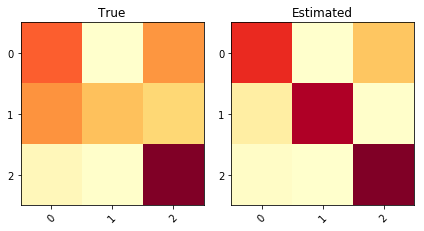

KL divergence: 0.3965	Pearson Correlation between diagonals: 0.4538


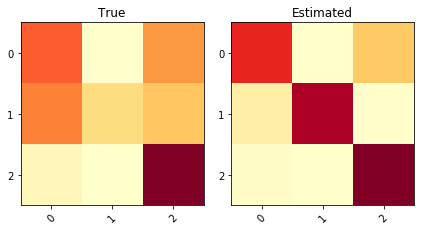

KL divergence: 0.5501	Pearson Correlation between diagonals: 0.3472


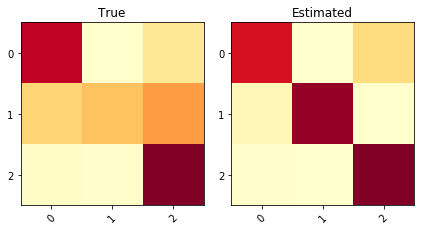

KL divergence: 0.7558	Pearson Correlation between diagonals: -0.1224


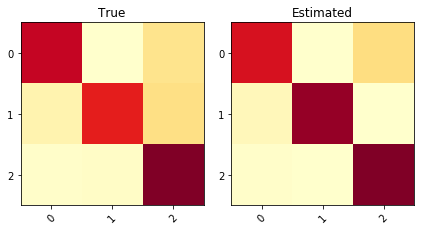

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.2969


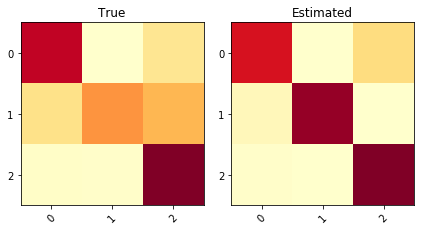

KL divergence: 0.5466	Pearson Correlation between diagonals: -0.0570


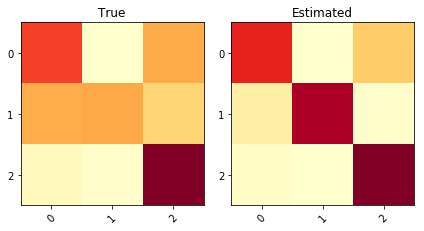

KL divergence: 0.3536	Pearson Correlation between diagonals: 0.4044
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.89267 |      0.89267 |       0.5065 |              0.235142 |       0.044841 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.657884 |               0.697329 |
+----+-------------------------+------------------------+
Test


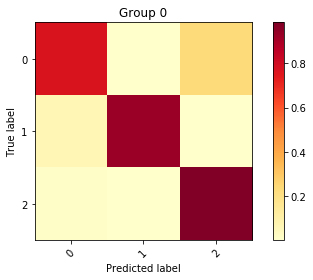

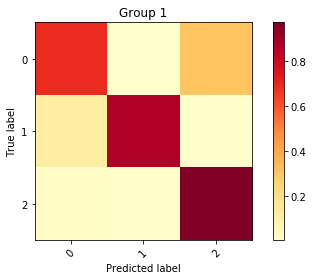

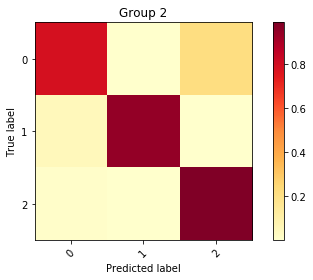

Inertia: 0.00285352435457753
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.305345 |    0.892468 |  0.119342 |           0.942156 |   0.860131 |     0.860131 |
|  1 |        1 |  0.390524 |    0.846823 |  0.176214 |           0.915582 |   0.606536 |     0.606536 |
|  2 |        2 |  0.269038 |    0.907335 |  0.102107 |           0.950395 |   0.866667 |     0.866667 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.895425 |     0.895425 |
+----+--------+------------+------------

In [16]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


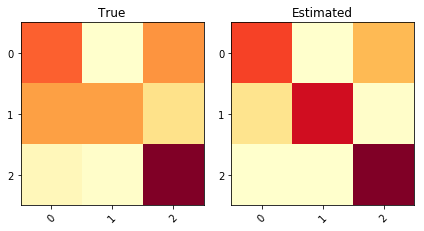

KL divergence: 0.2391	Pearson Correlation between diagonals: 0.7401


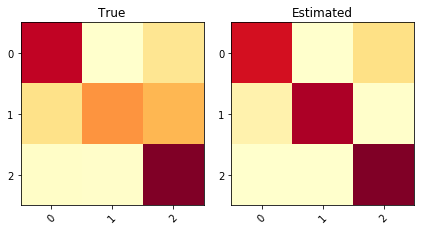

KL divergence: 0.4105	Pearson Correlation between diagonals: 0.2201


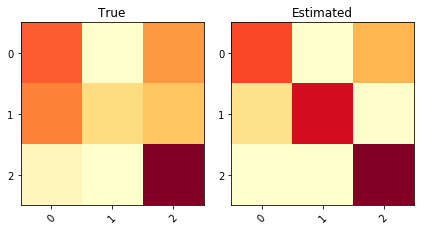

KL divergence: 0.4400	Pearson Correlation between diagonals: 0.5581


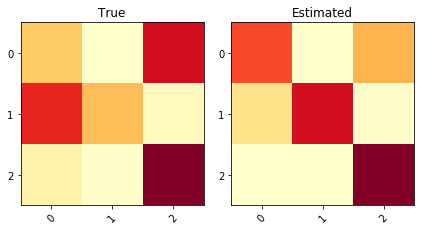

KL divergence: 0.3701	Pearson Correlation between diagonals: 0.9111


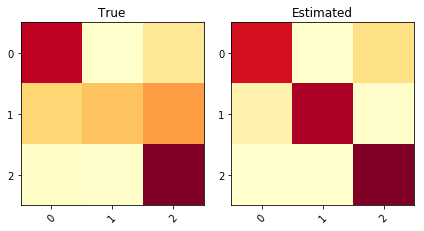

KL divergence: 0.5899	Pearson Correlation between diagonals: 0.1490


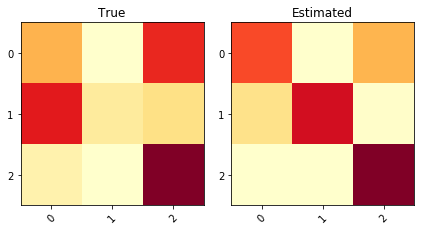

KL divergence: 0.5330	Pearson Correlation between diagonals: 0.7387


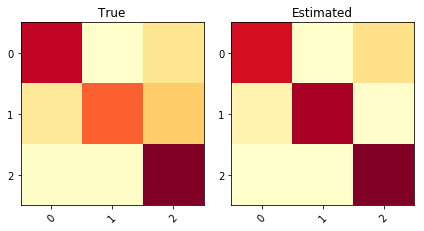

KL divergence: 0.3076	Pearson Correlation between diagonals: 0.2981


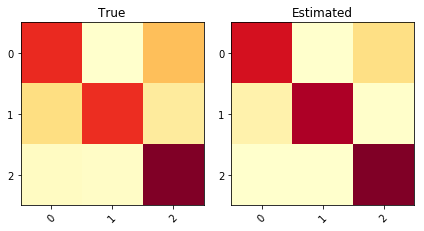

KL divergence: 0.1544	Pearson Correlation between diagonals: 0.8249


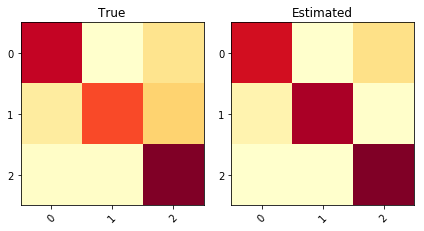

KL divergence: 0.2659	Pearson Correlation between diagonals: 0.3555


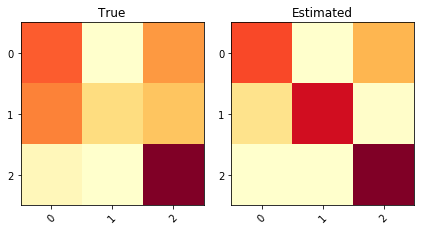

KL divergence: 0.4418	Pearson Correlation between diagonals: 0.5578


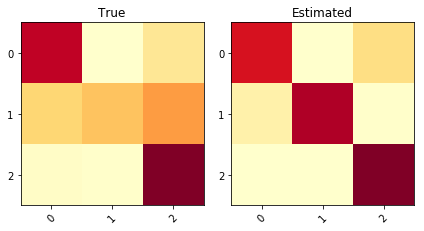

KL divergence: 0.5744	Pearson Correlation between diagonals: 0.1683


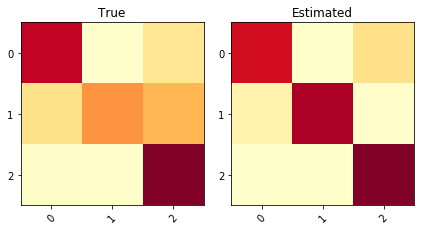

KL divergence: 0.4136	Pearson Correlation between diagonals: 0.2152


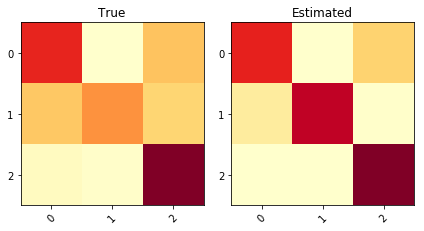

KL divergence: 0.2787	Pearson Correlation between diagonals: 0.5538


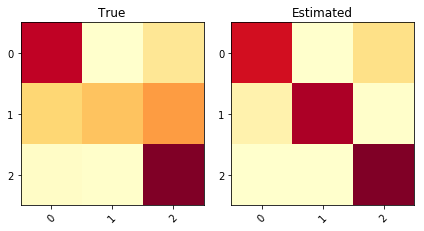

KL divergence: 0.5941	Pearson Correlation between diagonals: 0.1438


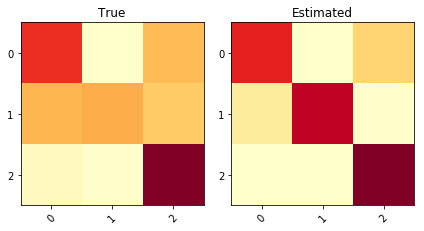

KL divergence: 0.3605	Pearson Correlation between diagonals: 0.5104
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.903141 |     0.903141 |     0.391811 |              0.469568 |      0.0406863 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.657838 |               0.688176 |
+----+-------------------------+------------------------+
Test


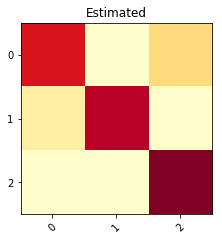

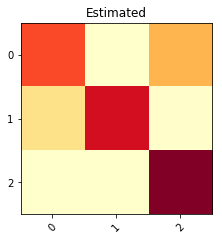

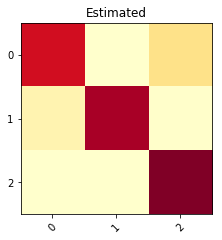

Inertia: 0.005769655283074826
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.328478 |    0.881282 |  0.131811 |           0.936105 |   0.84183  |     0.84183  |
|  1 |        1 |  0.410847 |    0.810386 |  0.227167 |           0.892596 |   0.720261 |     0.720261 |
|  2 |        2 |  0.281032 |    0.904995 |  0.103624 |           0.949492 |   0.864052 |     0.864052 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.903268 |     0.903268 |
+----+--------+------------+-----------

In [47]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


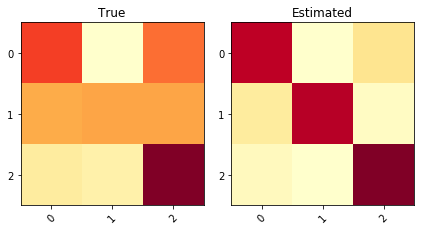

KL divergence: 0.4492	Pearson Correlation between diagonals: 0.8463


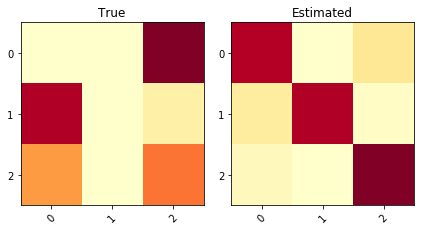

KL divergence: 1.5327	Pearson Correlation between diagonals: 0.9983


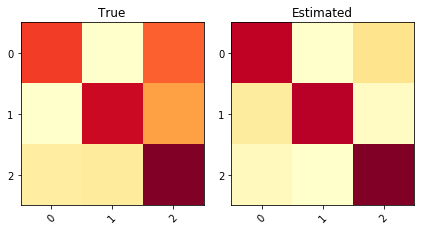

KL divergence: 0.4352	Pearson Correlation between diagonals: 0.9419


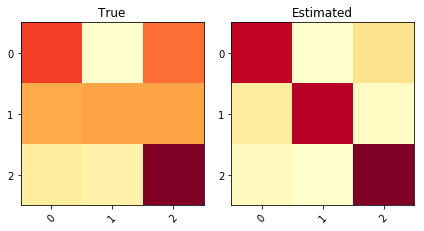

KL divergence: 0.4265	Pearson Correlation between diagonals: 0.8263


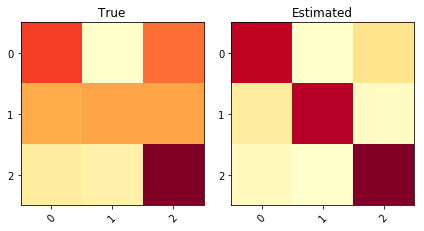

KL divergence: 0.4340	Pearson Correlation between diagonals: 0.8328


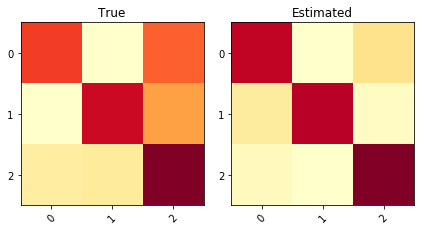

KL divergence: 0.4291	Pearson Correlation between diagonals: 0.9453


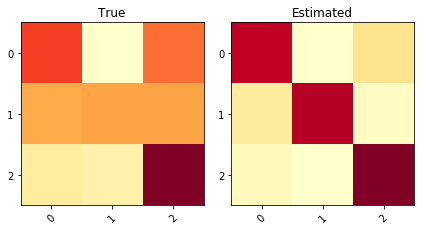

KL divergence: 0.4425	Pearson Correlation between diagonals: 0.8403


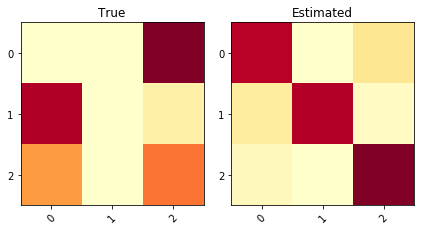

KL divergence: 1.5157	Pearson Correlation between diagonals: 0.9965


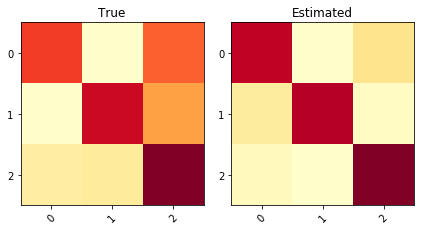

KL divergence: 0.4380	Pearson Correlation between diagonals: 0.9403


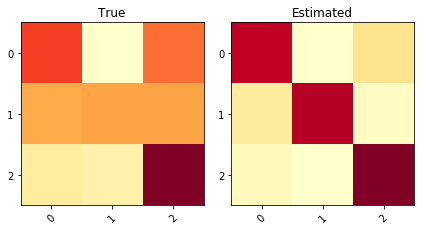

KL divergence: 0.4431	Pearson Correlation between diagonals: 0.8408


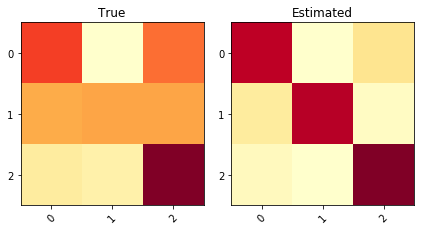

KL divergence: 0.4502	Pearson Correlation between diagonals: 0.8472


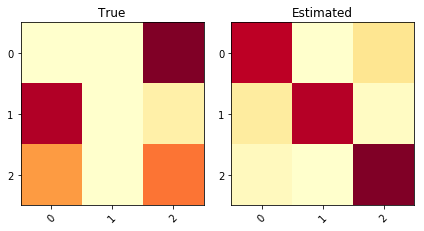

KL divergence: 1.4929	Pearson Correlation between diagonals: 0.9932


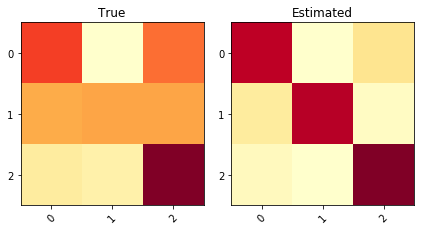

KL divergence: 0.4511	Pearson Correlation between diagonals: 0.8479


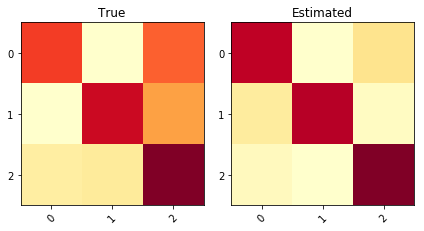

KL divergence: 0.4430	Pearson Correlation between diagonals: 0.9374


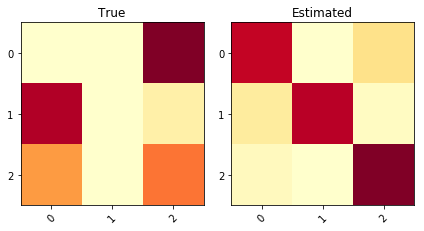

KL divergence: 1.4535	Pearson Correlation between diagonals: 0.9860
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.883072 |     0.883072 |     0.591899 |              0.890642 |      0.0642503 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.547132 |               0.862627 |
+----+-------------------------+------------------------+
Test


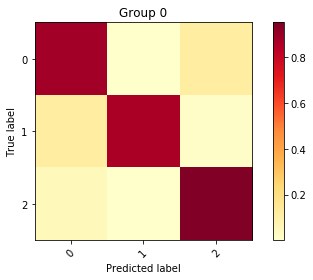

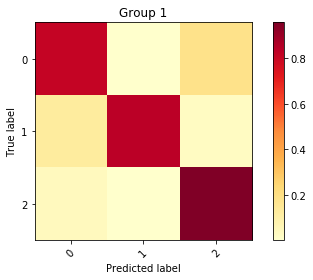

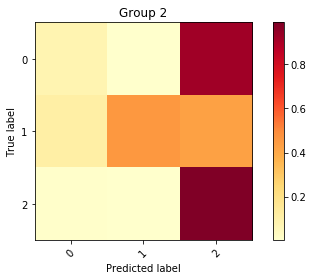

Inertia: 0.12279508542269468
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.329843 |    0.902199 |  0.103719 |           0.949011 |   0.746405 |     0.746405 |
|  1 |        1 |  0.394027 |    0.871747 |  0.139701 |           0.931875 |   0.688889 |     0.688889 |
|  2 |        2 |  0.433454 |    0.508892 |  1.11847  |           0.616762 |   0.322876 |     0.322876 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.860131 |     0.860131 |
+----+--------+------------+------------

In [22]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [112]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8538394415357766


In [113]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.79014 |      0.79014 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.786928 |     0.786928 |
+----+--------+------------+--------------+


In [114]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.888307 |     0.888307 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.888889 |     0.888889 |
+----+--------+------------+--------------+


In [115]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.933682 |     0.933682 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.933333 |     0.933333 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


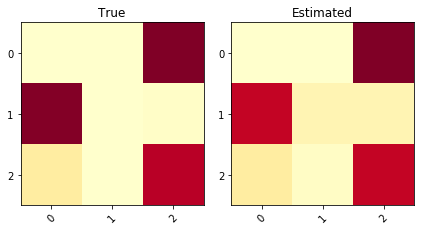

KL divergence: 0.1547	Pearson Correlation between diagonals: 0.9967


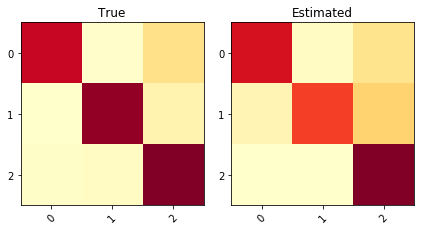

KL divergence: 0.1802	Pearson Correlation between diagonals: 0.3776


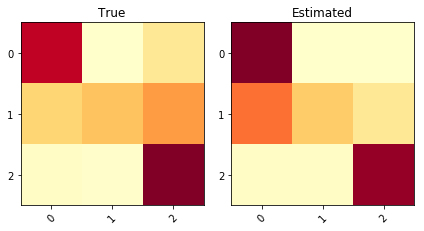

KL divergence: 0.1491	Pearson Correlation between diagonals: 0.9695


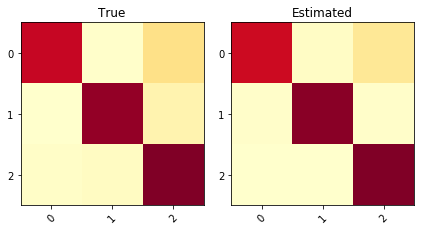

KL divergence: 0.0901	Pearson Correlation between diagonals: 0.9884


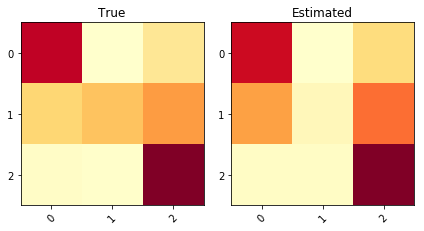

KL divergence: 0.1242	Pearson Correlation between diagonals: 0.9999


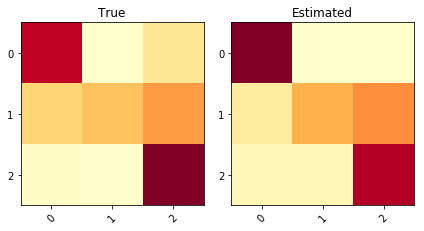

KL divergence: 0.1128	Pearson Correlation between diagonals: 0.9363


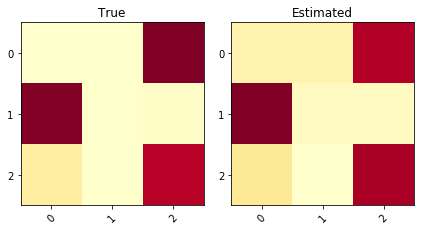

KL divergence: 0.1614	Pearson Correlation between diagonals: 0.9987


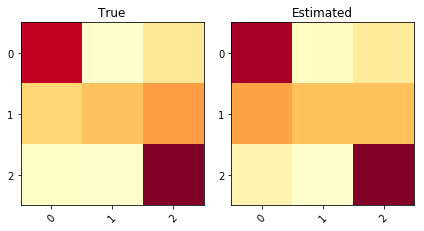

KL divergence: 0.0935	Pearson Correlation between diagonals: 0.9969


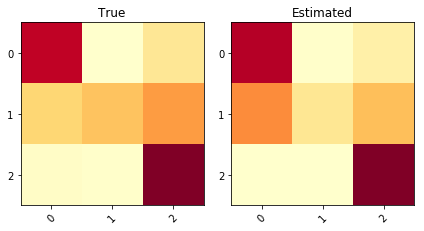

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9977


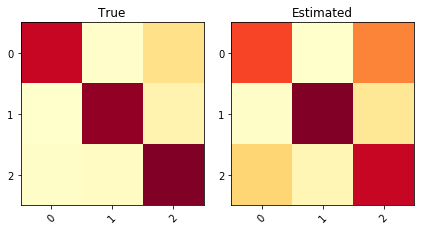

KL divergence: 0.2355	Pearson Correlation between diagonals: 0.7503


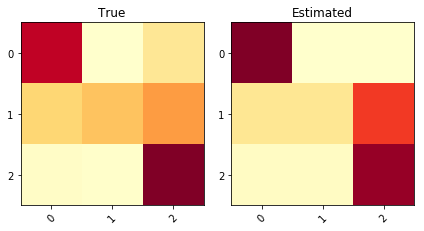

KL divergence: 0.1001	Pearson Correlation between diagonals: 0.9702


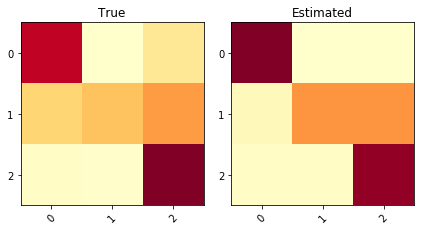

KL divergence: 0.1290	Pearson Correlation between diagonals: 0.9655


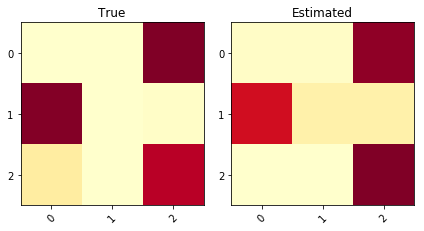

KL divergence: 0.2289	Pearson Correlation between diagonals: 0.9971


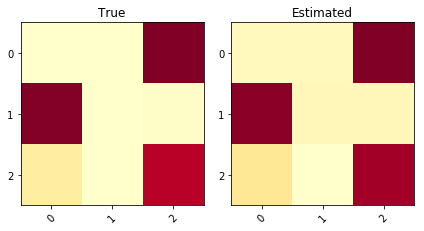

KL divergence: 0.1453	Pearson Correlation between diagonals: 0.9999


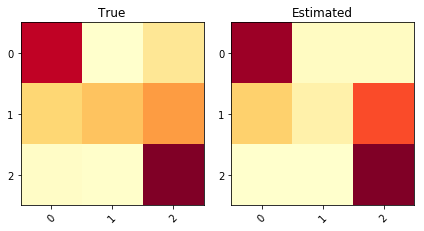

KL divergence: 0.0964	Pearson Correlation between diagonals: 0.9913
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.38918 |      0.38918 |     0.147233 |              0.857617 |       0.295673 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.483967 |                          0.934478 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [116]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


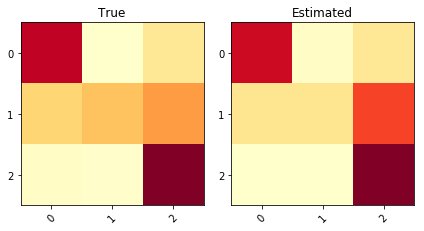

KL divergence: 0.0928	Pearson Correlation between diagonals: 0.9999


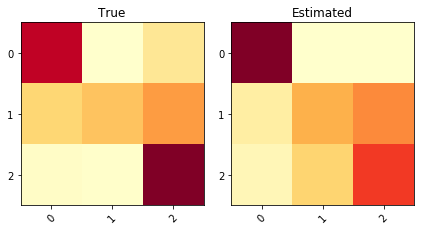

KL divergence: 0.2019	Pearson Correlation between diagonals: 0.7364


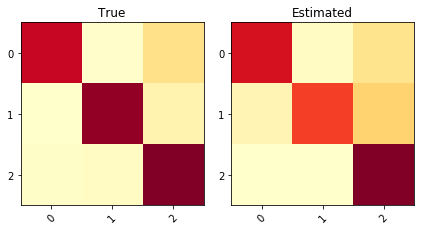

KL divergence: 0.1802	Pearson Correlation between diagonals: 0.3775


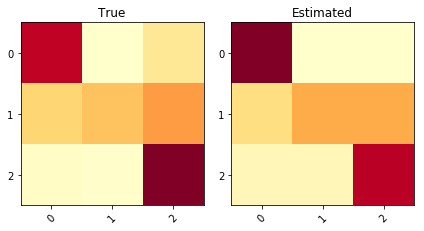

KL divergence: 0.1284	Pearson Correlation between diagonals: 0.9271


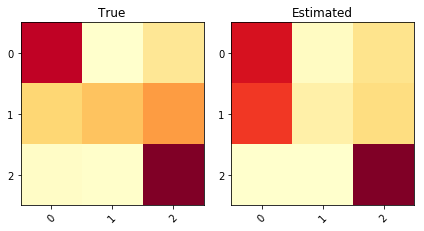

KL divergence: 0.1700	Pearson Correlation between diagonals: 0.9995


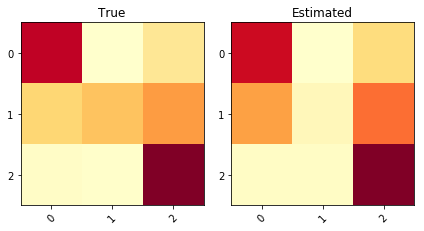

KL divergence: 0.1242	Pearson Correlation between diagonals: 0.9999


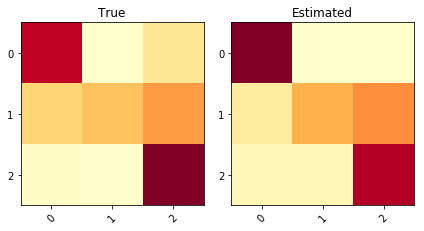

KL divergence: 0.1128	Pearson Correlation between diagonals: 0.9363


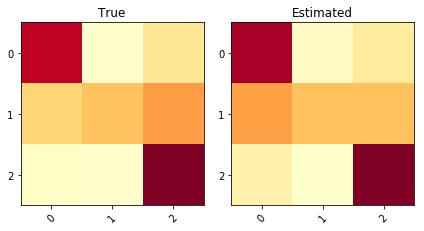

KL divergence: 0.0941	Pearson Correlation between diagonals: 0.9968


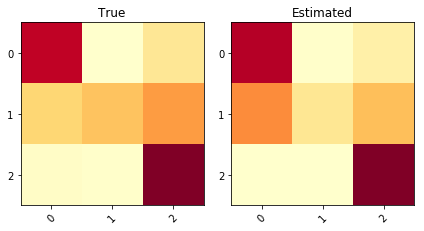

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9977


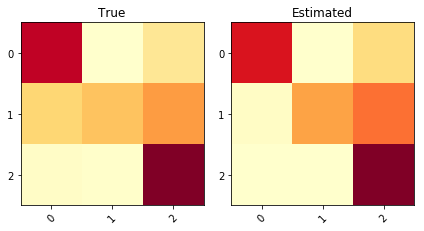

KL divergence: 0.1132	Pearson Correlation between diagonals: 0.9802


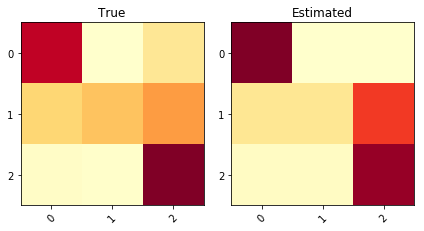

KL divergence: 0.1001	Pearson Correlation between diagonals: 0.9702


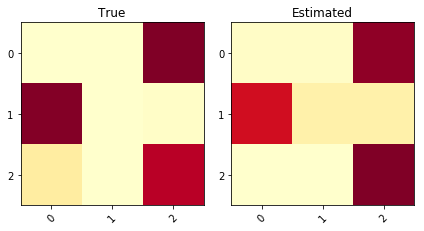

KL divergence: 0.2289	Pearson Correlation between diagonals: 0.9971


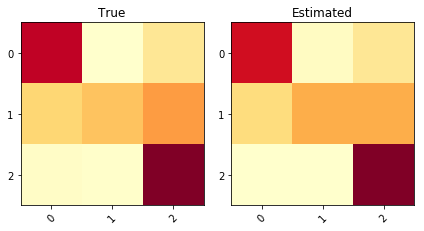

KL divergence: 0.0789	Pearson Correlation between diagonals: 0.9933


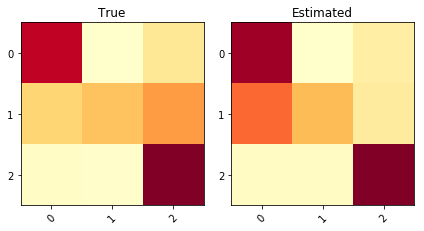

KL divergence: 0.1519	Pearson Correlation between diagonals: 0.9948


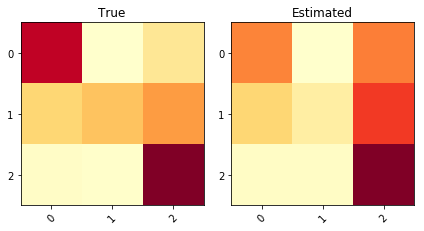

KL divergence: 0.2164	Pearson Correlation between diagonals: 0.9268
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.822426 |     0.822426 |     0.147153 |              0.857683 |       0.208163 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                      0.68203 |                          0.792556 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [118]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


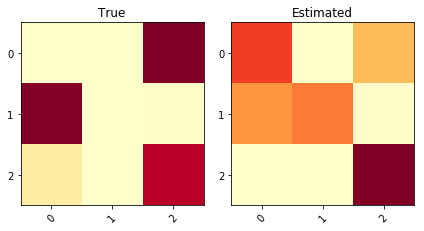

KL divergence: 0.7561	Pearson Correlation between diagonals: 0.9623


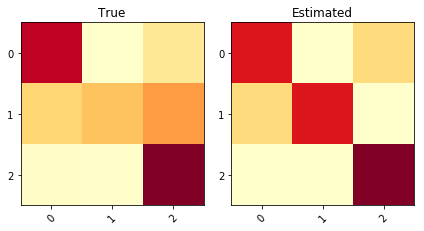

KL divergence: 0.6163	Pearson Correlation between diagonals: 0.6581


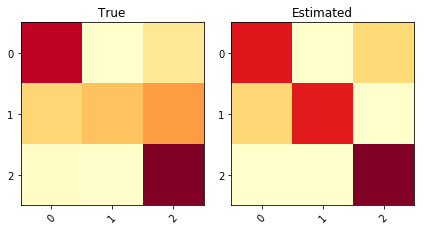

KL divergence: 0.6075	Pearson Correlation between diagonals: 0.6924


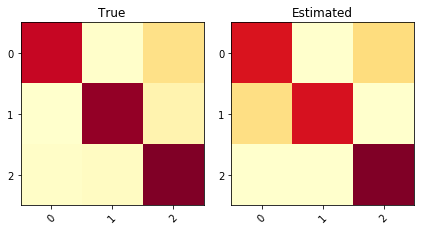

KL divergence: 0.1494	Pearson Correlation between diagonals: 0.7350


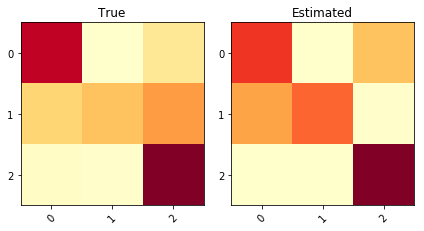

KL divergence: 0.5830	Pearson Correlation between diagonals: 0.8212


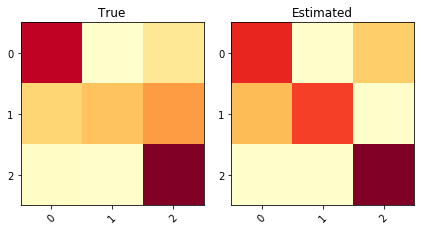

KL divergence: 0.5882	Pearson Correlation between diagonals: 0.7776


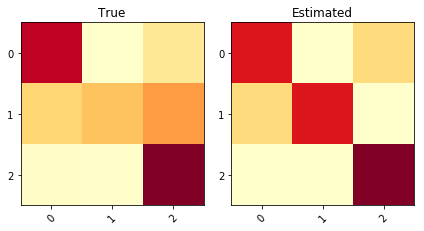

KL divergence: 0.6164	Pearson Correlation between diagonals: 0.6587


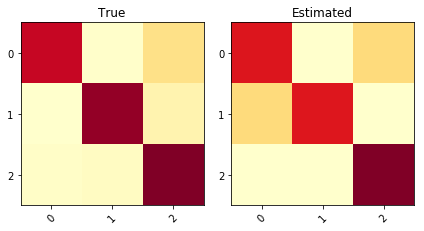

KL divergence: 0.1579	Pearson Correlation between diagonals: 0.6938


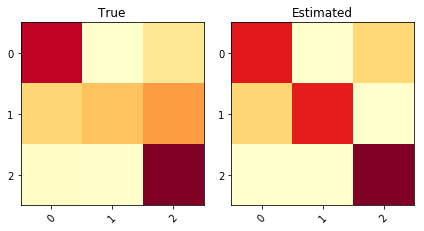

KL divergence: 0.6050	Pearson Correlation between diagonals: 0.7034


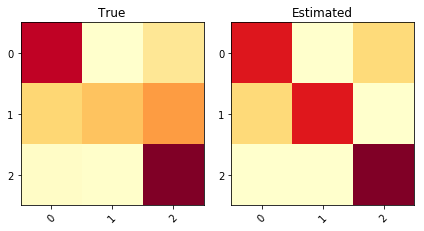

KL divergence: 0.6128	Pearson Correlation between diagonals: 0.6739


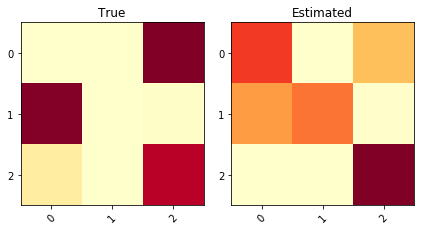

KL divergence: 0.7763	Pearson Correlation between diagonals: 0.9653


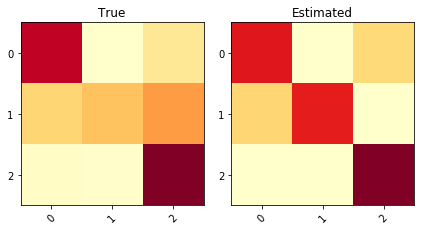

KL divergence: 0.6047	Pearson Correlation between diagonals: 0.7010


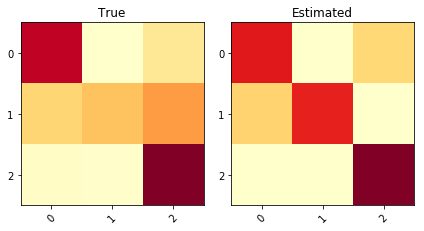

KL divergence: 0.6030	Pearson Correlation between diagonals: 0.7097


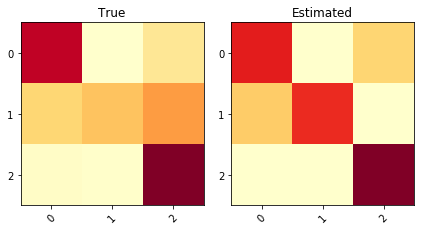

KL divergence: 0.5973	Pearson Correlation between diagonals: 0.7362


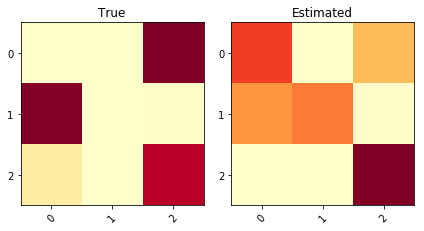

KL divergence: 0.7579	Pearson Correlation between diagonals: 0.9626
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.921466 |     0.921466 |     0.514718 |              0.762218 |      0.0919809 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.688129 |               0.652776 |
+----+-------------------------+------------------------+
Test


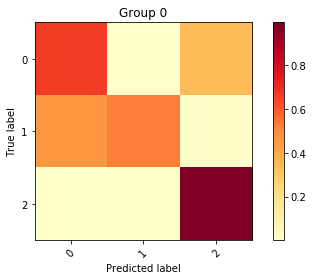

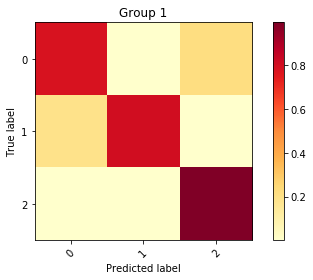

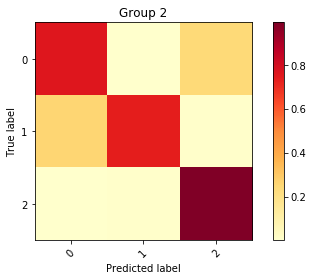

Inertia: 0.009807251335587353
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.464797 |    0.728612 |  0.351644 |           0.838201 |   0.620915 |     0.620915 |
|  1 |        1 |  0.354827 |    0.861781 |  0.154598 |           0.925215 |   0.869281 |     0.869281 |
|  2 |        2 |  0.403172 |    0.828732 |  0.197224 |           0.905472 |   0.843137 |     0.843137 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.920261 |     0.920261 |
+----+--------+------------+-----------

In [20]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


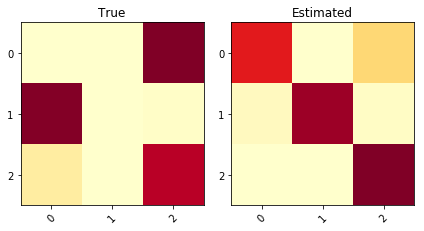

KL divergence: 1.6851	Pearson Correlation between diagonals: 0.6812


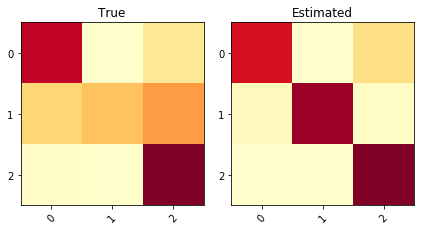

KL divergence: 0.4902	Pearson Correlation between diagonals: -0.0420


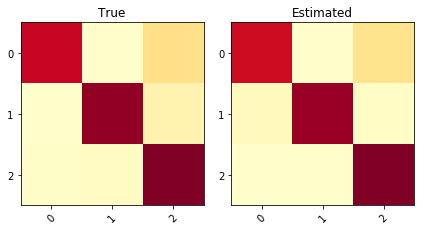

KL divergence: 0.0532	Pearson Correlation between diagonals: 0.9979


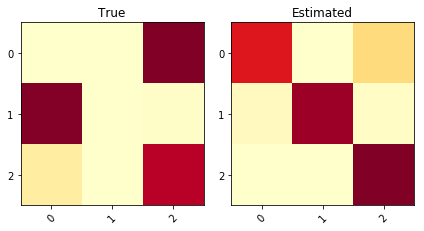

KL divergence: 1.7017	Pearson Correlation between diagonals: 0.6978


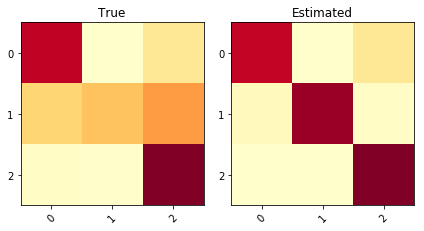

KL divergence: 0.5056	Pearson Correlation between diagonals: 0.0495


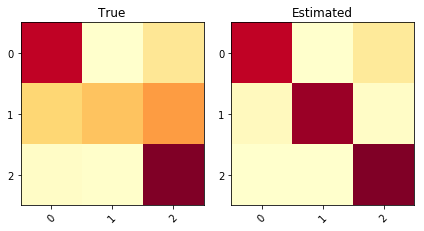

KL divergence: 0.5100	Pearson Correlation between diagonals: 0.0787


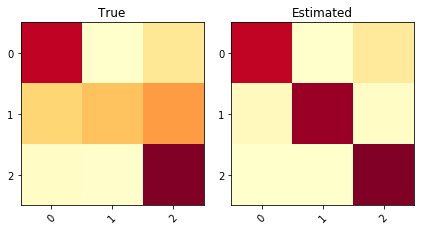

KL divergence: 0.5095	Pearson Correlation between diagonals: 0.0725


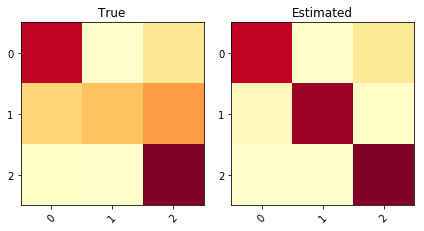

KL divergence: 0.5085	Pearson Correlation between diagonals: 0.0689


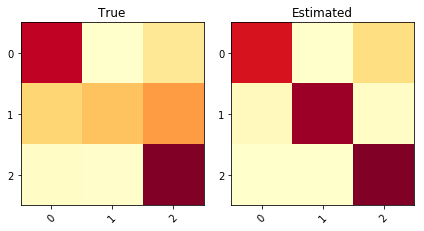

KL divergence: 0.4884	Pearson Correlation between diagonals: -0.0587


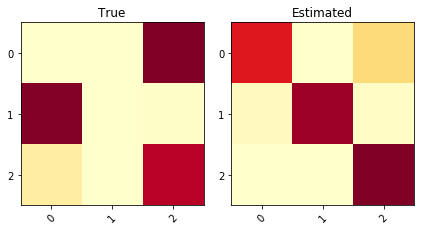

KL divergence: 1.6957	Pearson Correlation between diagonals: 0.6928


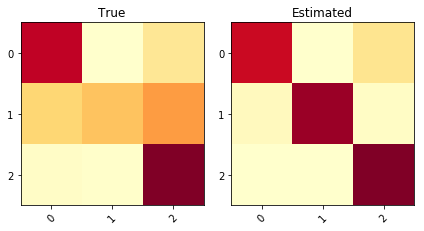

KL divergence: 0.4980	Pearson Correlation between diagonals: 0.0050


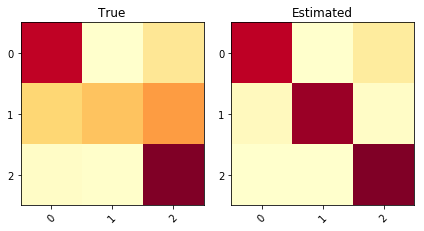

KL divergence: 0.5148	Pearson Correlation between diagonals: 0.1062


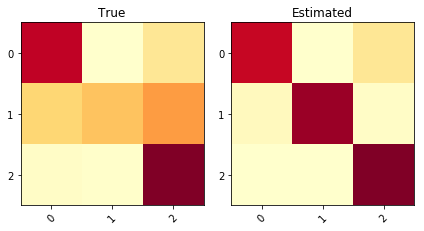

KL divergence: 0.5028	Pearson Correlation between diagonals: 0.0342


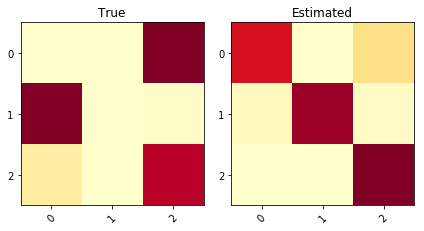

KL divergence: 1.7424	Pearson Correlation between diagonals: 0.7246


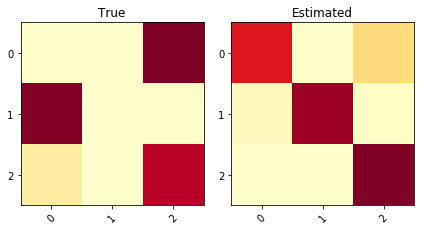

KL divergence: 1.6995	Pearson Correlation between diagonals: 0.6975
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.880454 |     0.880454 |     0.575932 |              0.359152 |      0.0778175 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.661815 |                0.68421 |
+----+-------------------------+------------------------+
Test


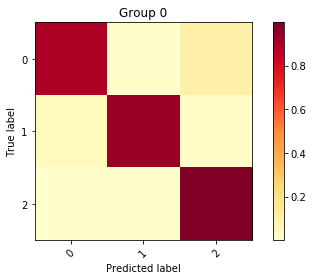

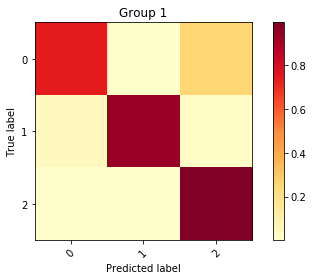

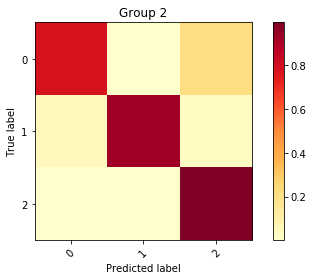

Inertia: 0.004195076442556456
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.200926 |    0.946471 | 0.0559347 |           0.972382 |   0.847059 |     0.847059 |
|  1 |        1 |  0.289992 |    0.89202  | 0.122364  |           0.941079 |   0.779085 |     0.779085 |
|  2 |        2 |  0.288891 |    0.902538 | 0.107521  |           0.947782 |   0.793464 |     0.793464 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.878431 |     0.878431 |
+----+--------+------------+-----------

In [21]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


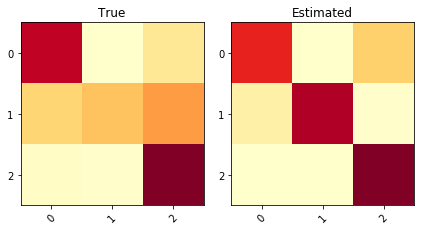

KL divergence: 0.5981	Pearson Correlation between diagonals: 0.0618


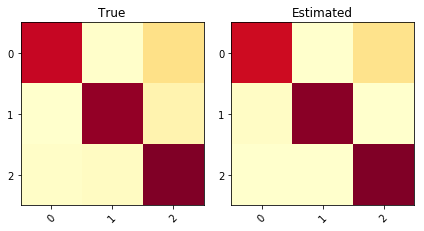

KL divergence: 0.0794	Pearson Correlation between diagonals: 0.9902


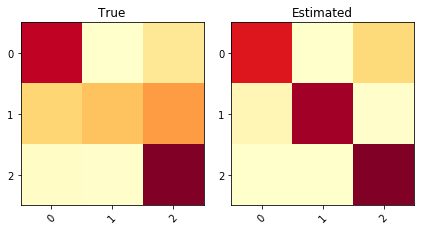

KL divergence: 0.6424	Pearson Correlation between diagonals: -0.0310


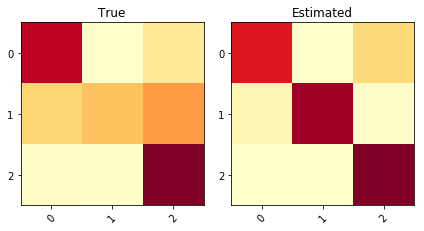

KL divergence: 0.6441	Pearson Correlation between diagonals: -0.0347


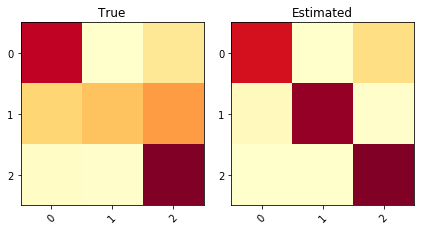

KL divergence: 0.6978	Pearson Correlation between diagonals: -0.1290


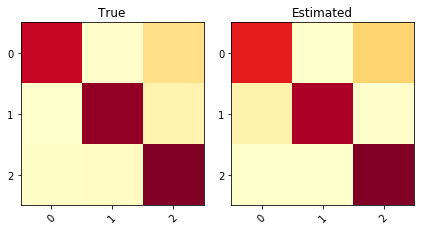

KL divergence: 0.0982	Pearson Correlation between diagonals: 0.9941


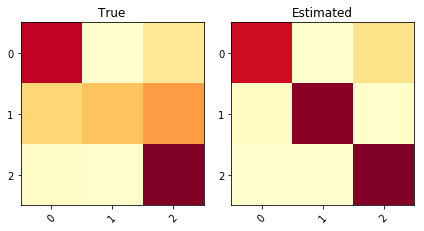

KL divergence: 0.7452	Pearson Correlation between diagonals: -0.1942


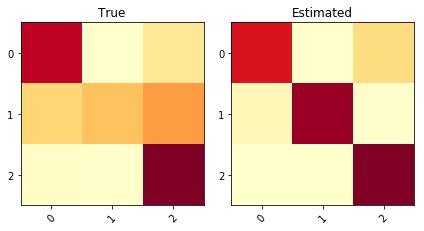

KL divergence: 0.6677	Pearson Correlation between diagonals: -0.0789


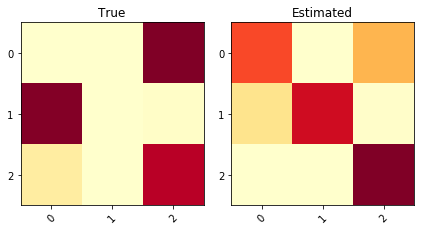

KL divergence: 1.0584	Pearson Correlation between diagonals: 0.8729


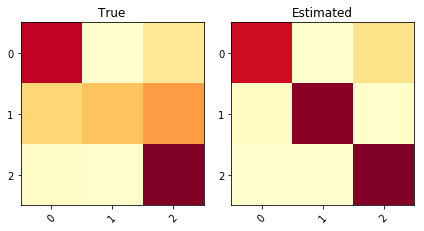

KL divergence: 0.7476	Pearson Correlation between diagonals: -0.1970


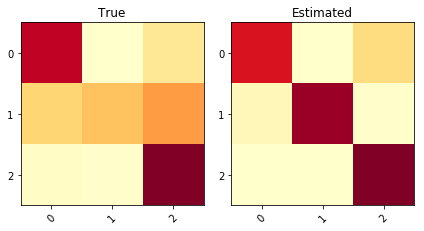

KL divergence: 0.6702	Pearson Correlation between diagonals: -0.0830


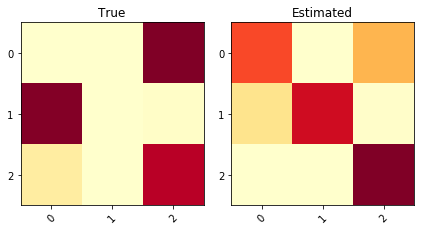

KL divergence: 1.0546	Pearson Correlation between diagonals: 0.8739


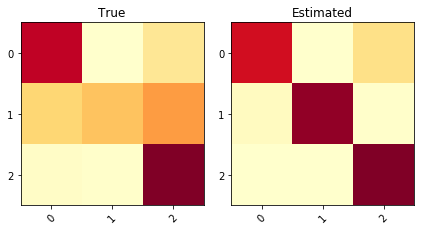

KL divergence: 0.7186	Pearson Correlation between diagonals: -0.1597


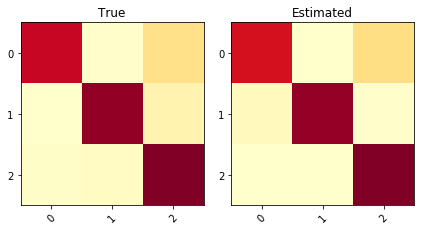

KL divergence: 0.0830	Pearson Correlation between diagonals: 0.9985


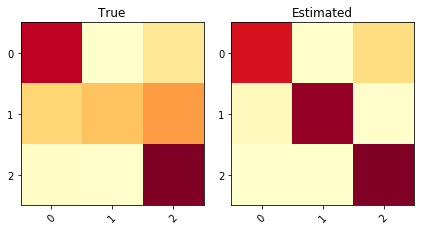

KL divergence: 0.6819	Pearson Correlation between diagonals: -0.1033
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.883508 |     0.883508 |      0.58468 |              0.337614 |      0.0695661 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.671146 |               0.665688 |
+----+-------------------------+------------------------+
Test


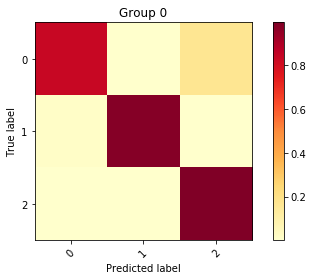

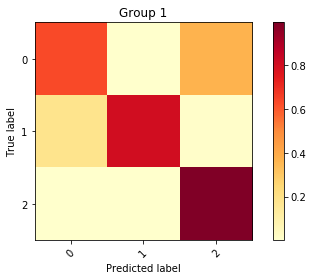

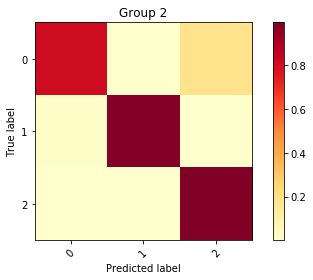

Inertia: 0.017402511090040207
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.194189 |    0.93742  | 0.0677826 |           0.96689  |   0.879739 |     0.879739 |
|  1 |        1 |  0.40521  |    0.812372 | 0.224733  |           0.893745 |   0.679739 |     0.679739 |
|  2 |        2 |  0.210053 |    0.929269 | 0.0774615 |           0.962291 |   0.877124 |     0.877124 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.88366 |      0.88366 |
+----+--------+------------+-----------

In [22]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{max}$ = 40 )

In [98]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.9101221640488656


In [99]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.821117 |     0.821117 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.820915 |     0.820915 |
+----+--------+------------+--------------+


In [100]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.910995 |     0.910995 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.915033 |     0.915033 |
+----+--------+------------+--------------+


In [101]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.937609 |     0.937609 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.941176 |     0.941176 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


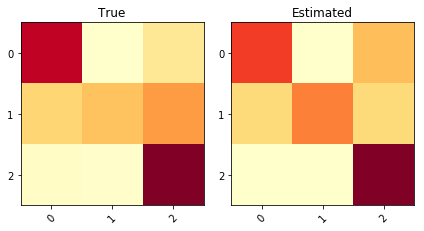

KL divergence: 0.2347	Pearson Correlation between diagonals: 0.8480


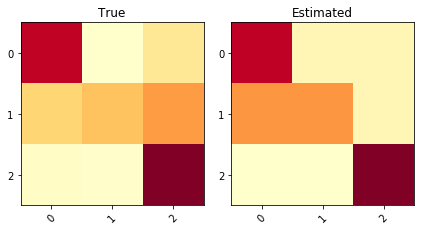

KL divergence: 0.2410	Pearson Correlation between diagonals: 0.9987


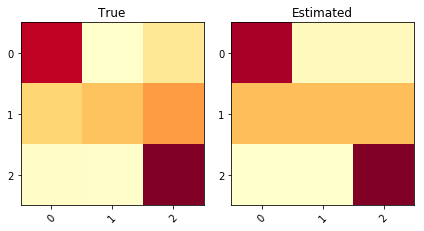

KL divergence: 0.1587	Pearson Correlation between diagonals: 0.9970


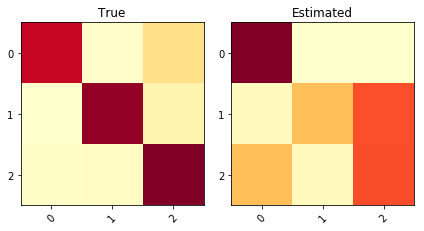

KL divergence: 0.4860	Pearson Correlation between diagonals: -0.7598


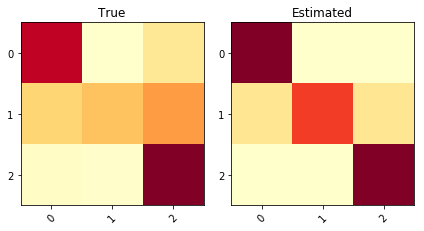

KL divergence: 0.2041	Pearson Correlation between diagonals: 0.9816


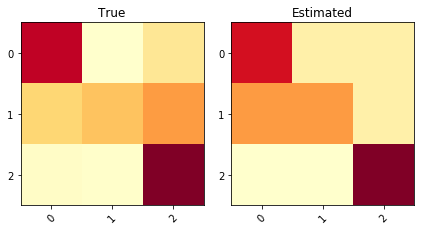

KL divergence: 0.2195	Pearson Correlation between diagonals: 0.9846


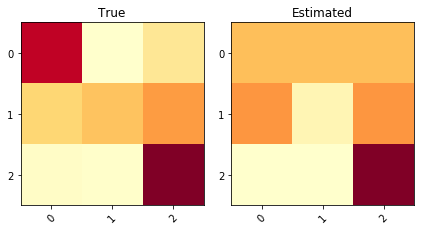

KL divergence: 0.3508	Pearson Correlation between diagonals: 0.8396


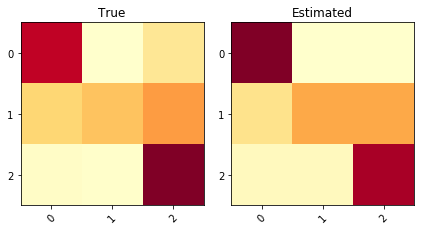

KL divergence: 0.1633	Pearson Correlation between diagonals: 0.9486


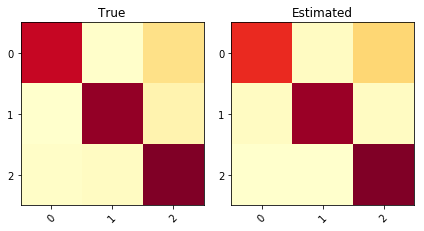

KL divergence: 0.1793	Pearson Correlation between diagonals: 0.9978


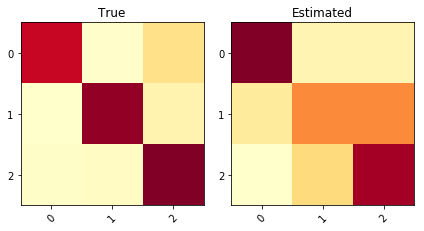

KL divergence: 0.3735	Pearson Correlation between diagonals: -0.4015


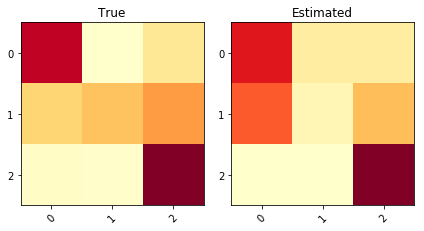

KL divergence: 0.2021	Pearson Correlation between diagonals: 0.9983


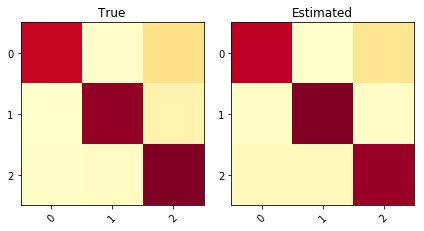

KL divergence: 0.1565	Pearson Correlation between diagonals: 0.7665


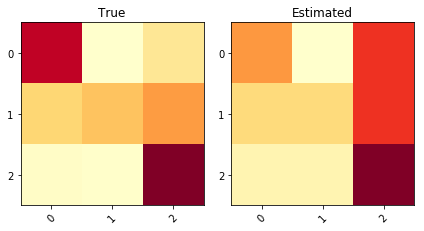

KL divergence: 0.2801	Pearson Correlation between diagonals: 0.8480


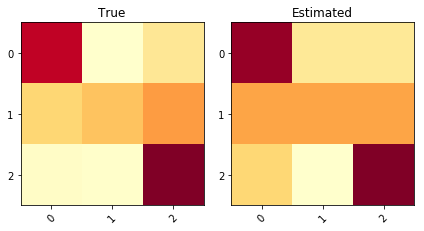

KL divergence: 0.2198	Pearson Correlation between diagonals: 0.9935


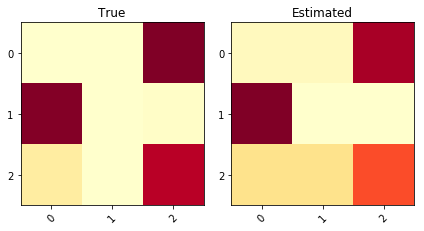

KL divergence: 0.3582	Pearson Correlation between diagonals: 0.9984


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.113874 |     0.113874 |     0.292311 |                   nan |       0.323055 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.526329 |                          0.962369 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+-

In [91]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


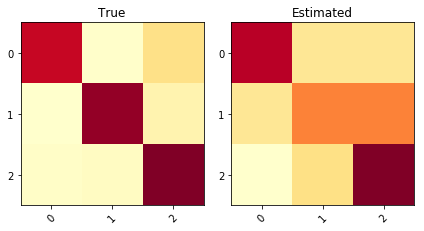

KL divergence: 0.3709	Pearson Correlation between diagonals: -0.0248


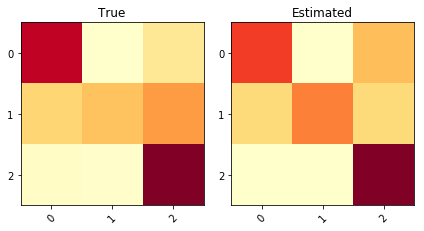

KL divergence: 0.2347	Pearson Correlation between diagonals: 0.8480


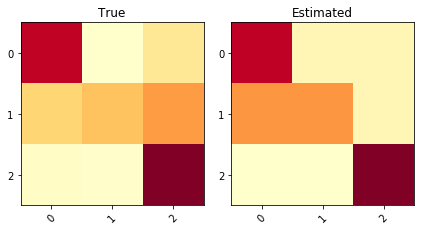

KL divergence: 0.2410	Pearson Correlation between diagonals: 0.9987


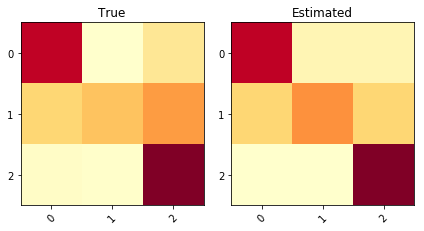

KL divergence: 0.1530	Pearson Correlation between diagonals: 0.9982


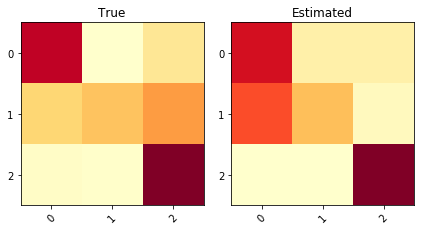

KL divergence: 0.2465	Pearson Correlation between diagonals: 0.9945


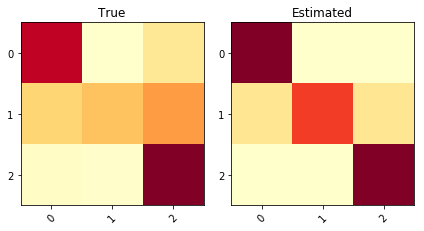

KL divergence: 0.2041	Pearson Correlation between diagonals: 0.9816


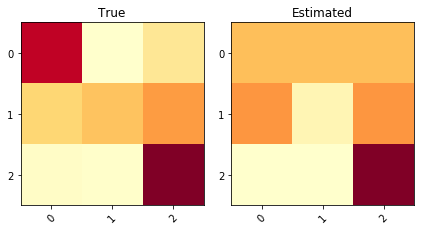

KL divergence: 0.3508	Pearson Correlation between diagonals: 0.8396


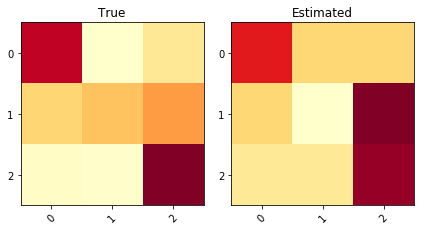

KL divergence: 0.3074	Pearson Correlation between diagonals: 1.0000


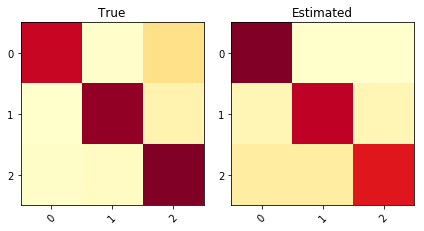

KL divergence: 0.2407	Pearson Correlation between diagonals: -0.9794


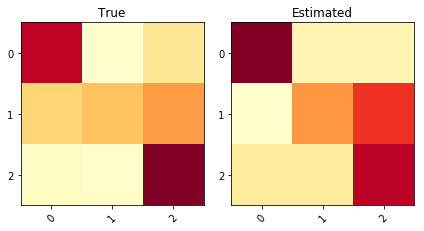

KL divergence: 0.2236	Pearson Correlation between diagonals: 0.9164


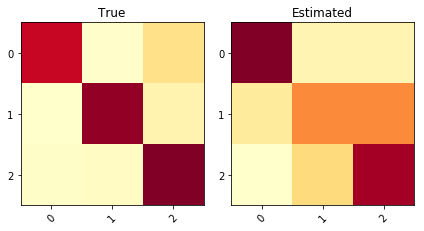

KL divergence: 0.3735	Pearson Correlation between diagonals: -0.4015


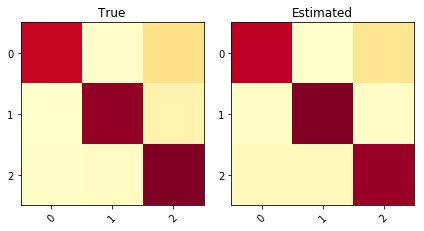

KL divergence: 0.1565	Pearson Correlation between diagonals: 0.7665


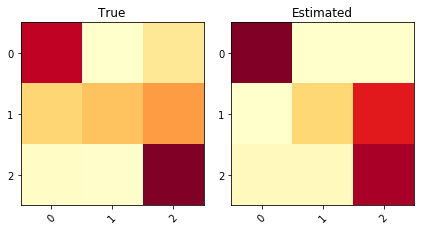

KL divergence: 0.1766	Pearson Correlation between diagonals: 0.9573


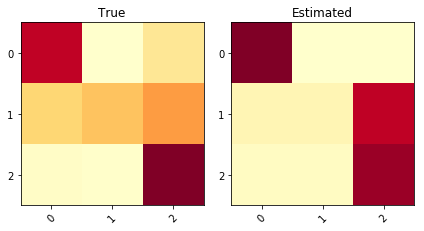

KL divergence: 0.1689	Pearson Correlation between diagonals: 0.9698


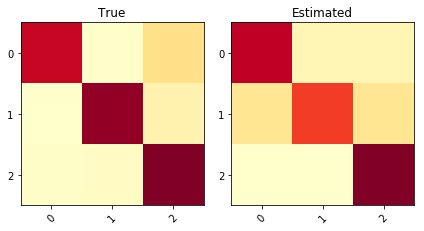

KL divergence: 0.3163	Pearson Correlation between diagonals: 0.1408


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.328098 |     0.328098 |      0.29227 |                   nan |       0.276417 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.591467 |                          0.888117 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+-

In [89]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


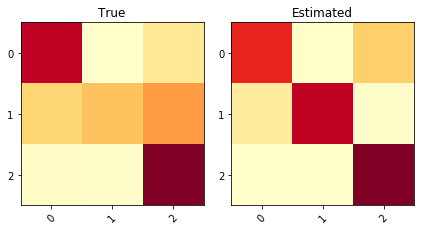

KL divergence: 0.5236	Pearson Correlation between diagonals: 0.1895


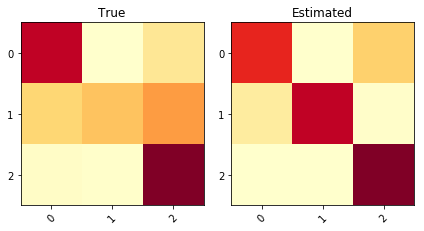

KL divergence: 0.5238	Pearson Correlation between diagonals: 0.1876


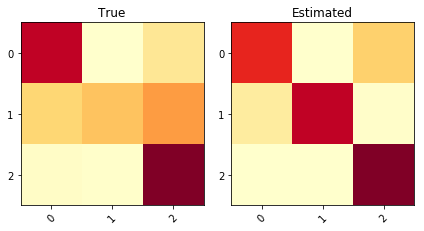

KL divergence: 0.5239	Pearson Correlation between diagonals: 0.1870


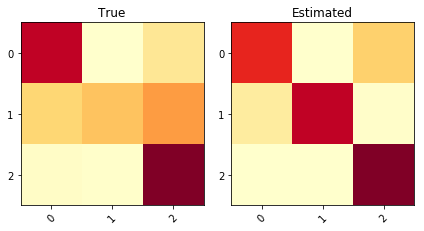

KL divergence: 0.5237	Pearson Correlation between diagonals: 0.1885


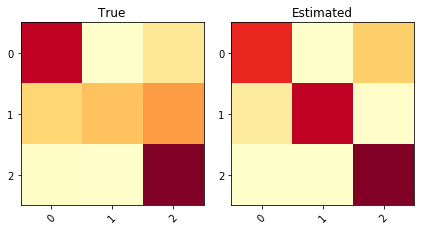

KL divergence: 0.5233	Pearson Correlation between diagonals: 0.1925


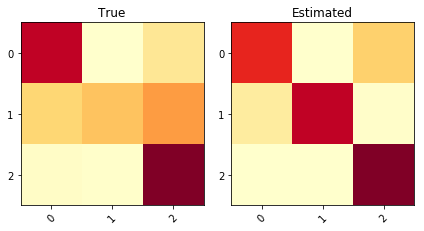

KL divergence: 0.5238	Pearson Correlation between diagonals: 0.1873


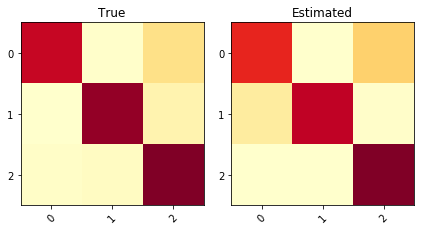

KL divergence: 0.1137	Pearson Correlation between diagonals: 0.9656


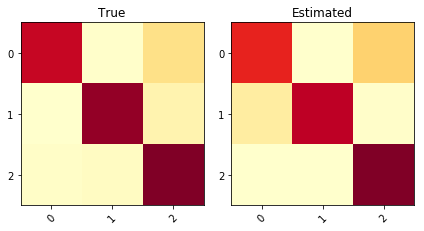

KL divergence: 0.1095	Pearson Correlation between diagonals: 0.9683


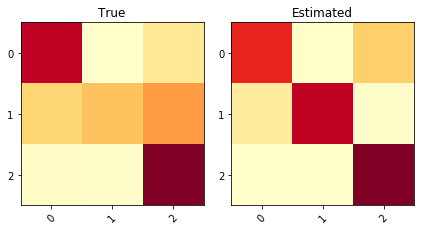

KL divergence: 0.5236	Pearson Correlation between diagonals: 0.1899


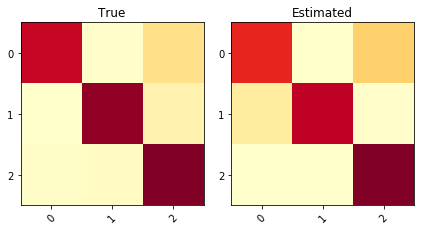

KL divergence: 0.1126	Pearson Correlation between diagonals: 0.9663


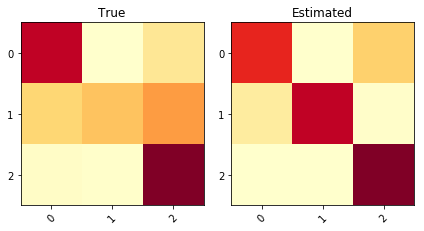

KL divergence: 0.5238	Pearson Correlation between diagonals: 0.1873


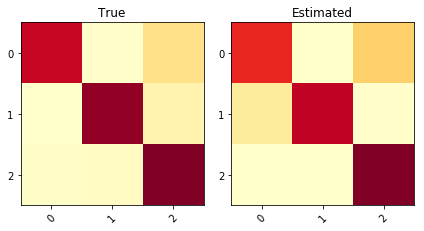

KL divergence: 0.1164	Pearson Correlation between diagonals: 0.9641


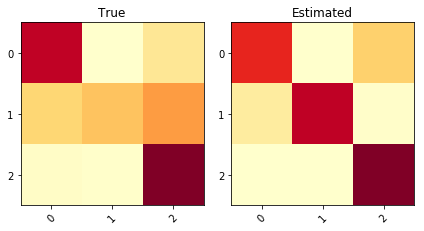

KL divergence: 0.5239	Pearson Correlation between diagonals: 0.1868


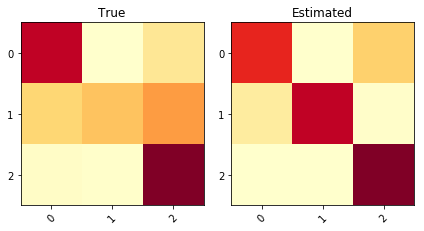

KL divergence: 0.5239	Pearson Correlation between diagonals: 0.1864


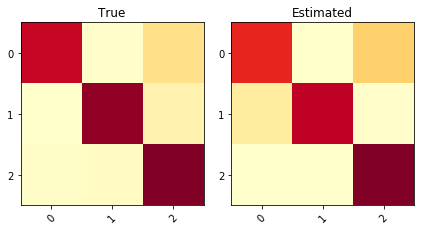

KL divergence: 0.1132	Pearson Correlation between diagonals: 0.9657
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.903578 |     0.903578 |     0.535437 |              0.483006 |      0.0933207 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.664985 |               0.685675 |
+----+-------------------------+------------------------+
Test


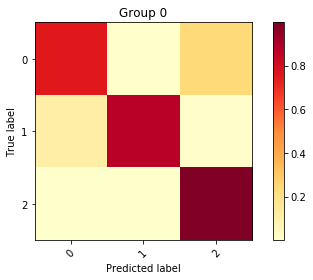

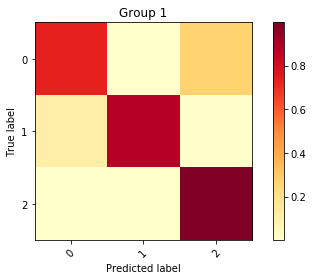

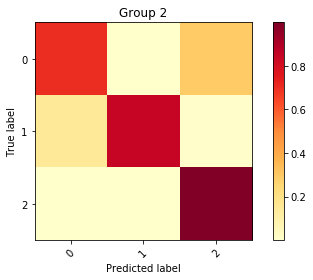

Inertia: 0.0006646502733929083
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.327247 |    0.877618 |  0.136993 |           0.933766 |   0.862745 |     0.862745 |
|  1 |        1 |  0.334756 |    0.869936 |  0.147471 |           0.928997 |   0.853595 |     0.853595 |
|  2 |        2 |  0.363132 |    0.849224 |  0.173523 |           0.916847 |   0.83268  |     0.83268  |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.901961 |     0.901961 |
+----+--------+------------+----------

In [19]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


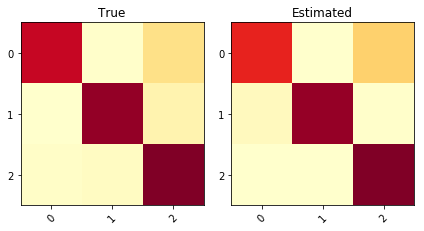

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9949


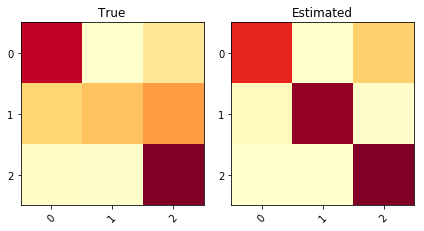

KL divergence: 0.6877	Pearson Correlation between diagonals: -0.1752


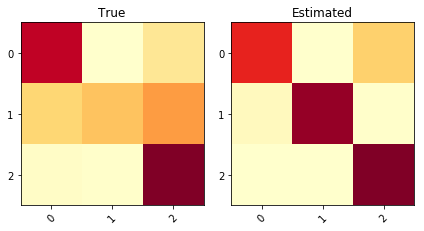

KL divergence: 0.6893	Pearson Correlation between diagonals: -0.1759


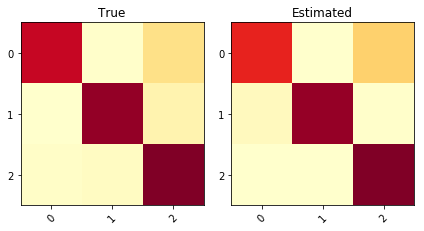

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9949


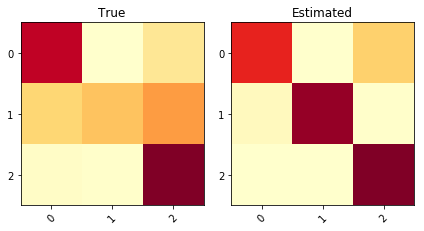

KL divergence: 0.6894	Pearson Correlation between diagonals: -0.1759


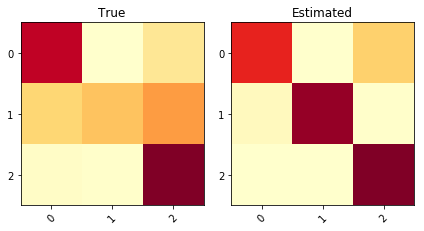

KL divergence: 0.6889	Pearson Correlation between diagonals: -0.1757


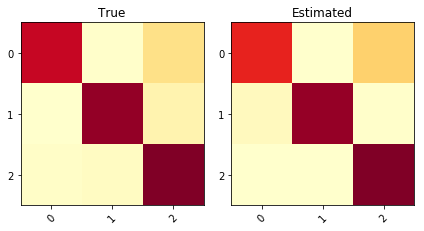

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9949


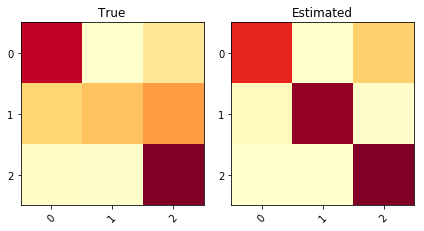

KL divergence: 0.6872	Pearson Correlation between diagonals: -0.1750


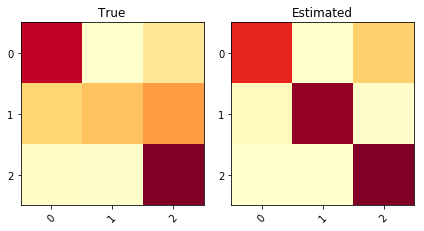

KL divergence: 0.6861	Pearson Correlation between diagonals: -0.1746


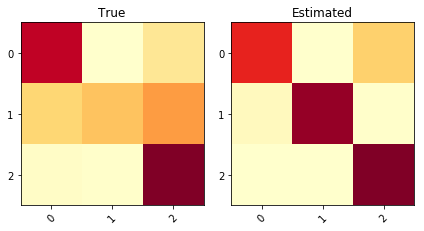

KL divergence: 0.6897	Pearson Correlation between diagonals: -0.1760


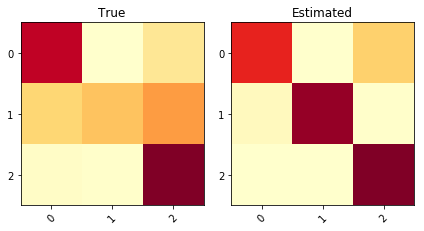

KL divergence: 0.6882	Pearson Correlation between diagonals: -0.1754


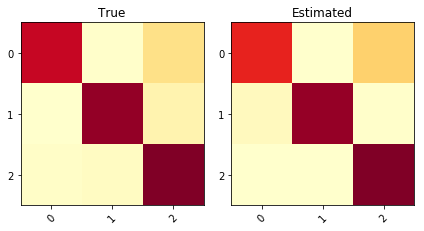

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.9949


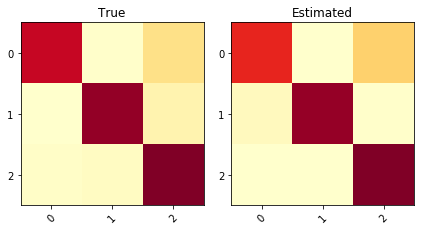

KL divergence: 0.0896	Pearson Correlation between diagonals: 0.9950


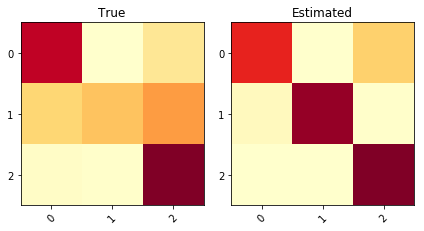

KL divergence: 0.6889	Pearson Correlation between diagonals: -0.1757


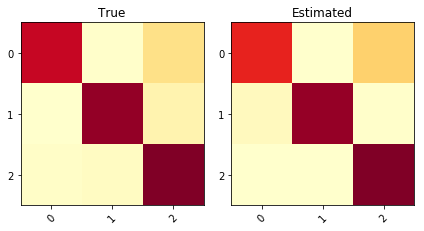

KL divergence: 0.0928	Pearson Correlation between diagonals: 0.9949
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.855148 |     0.855148 |     0.680976 |              0.234342 |      0.0923628 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.66303 |               0.689337 |
+----+-------------------------+------------------------+
Test


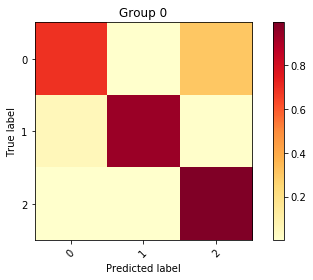

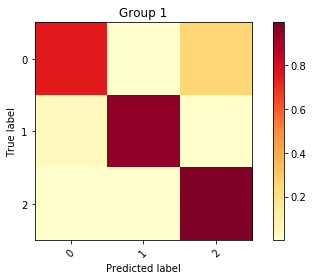

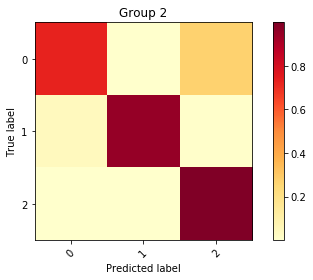

Inertia: 0.0005245272914180532
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.300799 |    0.875978 |  0.144653 |           0.931004 |   0.83268  |     0.83268  |
|  1 |        1 |  0.2637   |    0.899264 |  0.11435  |           0.944965 |   0.854902 |     0.854902 |
|  2 |        2 |  0.267616 |    0.893484 |  0.122003 |           0.941452 |   0.845752 |     0.845752 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.853595 |     0.853595 |
+----+--------+------------+----------

In [20]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


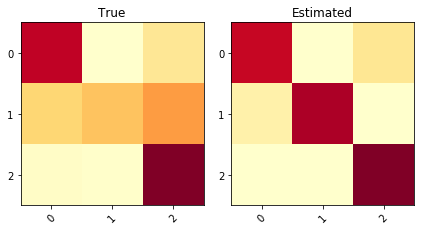

KL divergence: 0.7662	Pearson Correlation between diagonals: 0.2859


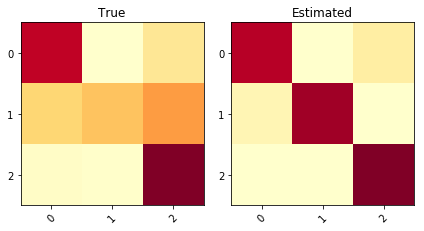

KL divergence: 0.8253	Pearson Correlation between diagonals: 0.3113


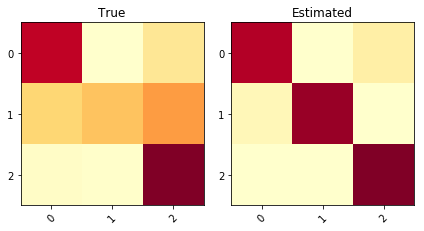

KL divergence: 0.8515	Pearson Correlation between diagonals: 0.2088


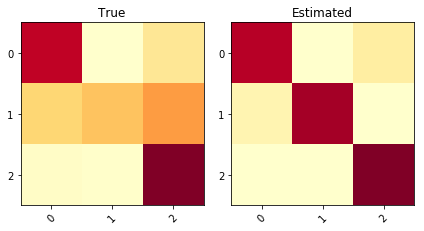

KL divergence: 0.8174	Pearson Correlation between diagonals: 0.3489


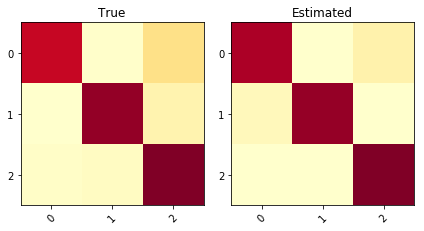

KL divergence: 0.1412	Pearson Correlation between diagonals: 0.9621


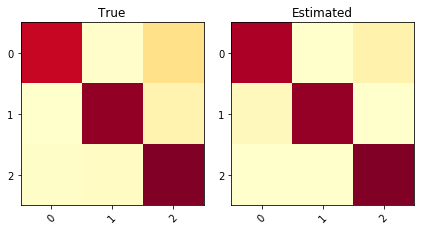

KL divergence: 0.1403	Pearson Correlation between diagonals: 0.9663


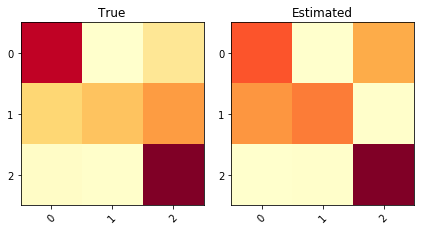

KL divergence: 0.6205	Pearson Correlation between diagonals: 0.7691


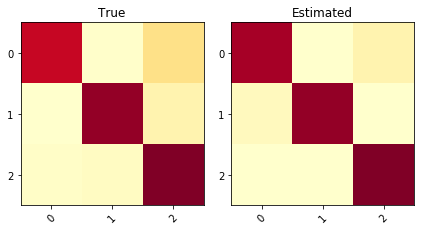

KL divergence: 0.1464	Pearson Correlation between diagonals: 0.9664


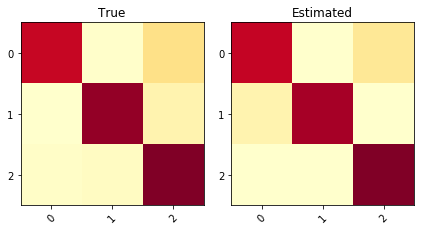

KL divergence: 0.1251	Pearson Correlation between diagonals: 0.9532


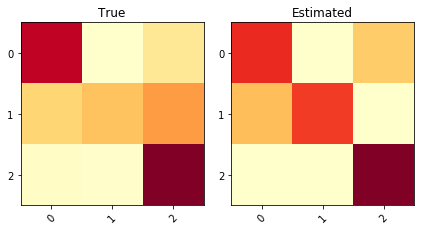

KL divergence: 0.6363	Pearson Correlation between diagonals: 0.7418


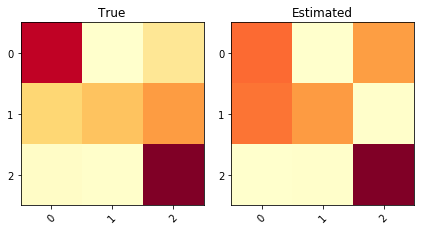

KL divergence: 0.6256	Pearson Correlation between diagonals: 0.7916


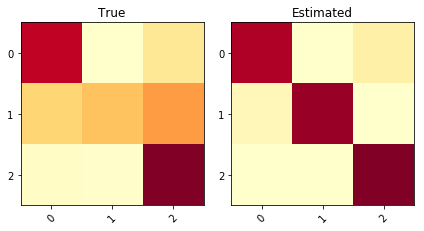

KL divergence: 0.8633	Pearson Correlation between diagonals: 0.2122


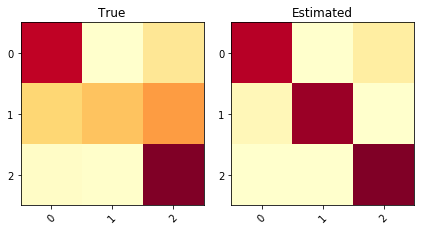

KL divergence: 0.8392	Pearson Correlation between diagonals: 0.1813


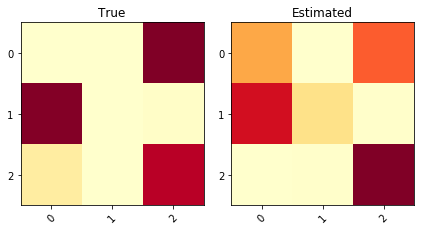

KL divergence: 0.4275	Pearson Correlation between diagonals: 0.9675


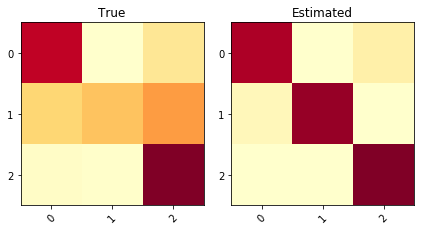

KL divergence: 0.8690	Pearson Correlation between diagonals: 0.2060
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.924956 |     0.924956 |     0.562815 |              0.638957 |       0.150251 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.766692 |                0.58654 |
+----+-------------------------+------------------------+
Test


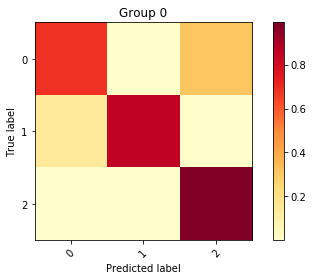

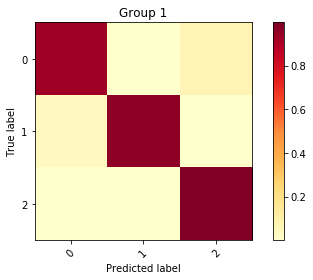

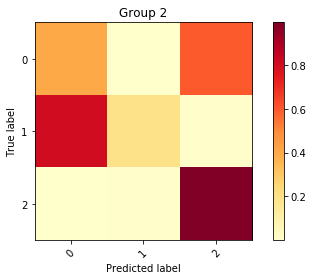

Inertia: 0.1073835778515786
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.368183 |    0.845515 | 0.178813  |           0.914489 |   0.839216 |     0.839216 |
|  1 |        1 |  0.146661 |    0.963101 | 0.0380235 |           0.981149 |   0.920261 |     0.920261 |
|  2 |        2 |  0.41336  |    0.528281 | 0.862691  |           0.65927  |   0.321569 |     0.321569 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.921569 |     0.921569 |
+----+--------+------------+-------------

In [21]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6295811518324608


In [39]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.45288 |      0.45288 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.449673 |     0.449673 |
+----+--------+------------+--------------+


In [40]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.599476 |     0.599476 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.580392 |     0.580392 |
+----+--------+------------+--------------+


In [41]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.938045 |     0.938045 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.946405 |     0.946405 |
+----+--------+------------+--------------+


*** Raykar model ***
Train


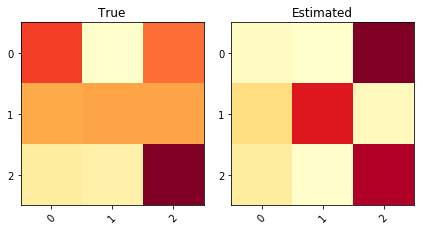

KL divergence: 0.2735	Pearson Correlation between diagonals: 0.2325


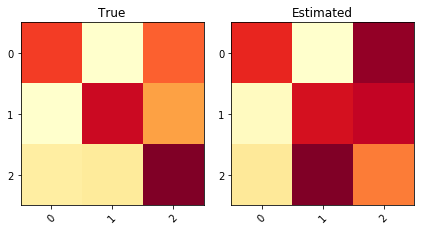

KL divergence: 0.2670	Pearson Correlation between diagonals: -0.7142


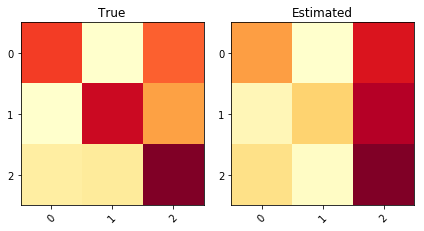

KL divergence: 0.2037	Pearson Correlation between diagonals: 0.7499


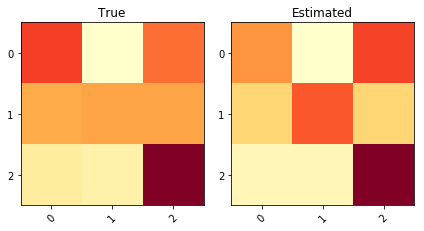

KL divergence: 0.0513	Pearson Correlation between diagonals: 0.7735


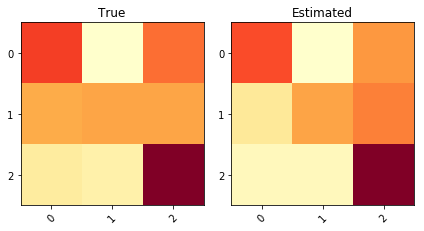

KL divergence: 0.0518	Pearson Correlation between diagonals: 0.9978


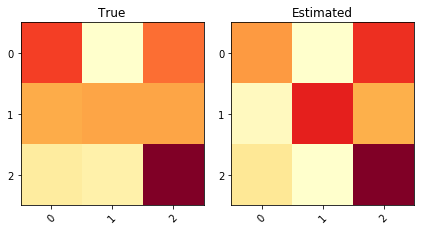

KL divergence: 0.1102	Pearson Correlation between diagonals: 0.5636


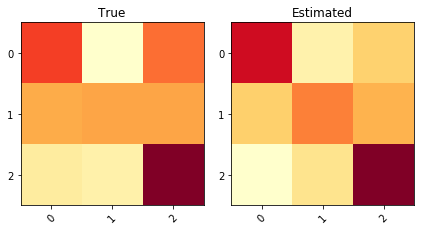

KL divergence: 0.0908	Pearson Correlation between diagonals: 0.9775


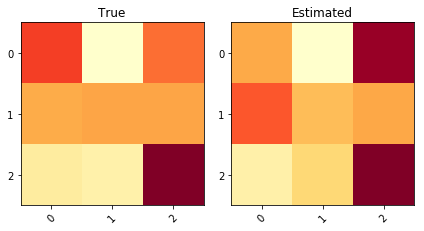

KL divergence: 0.1064	Pearson Correlation between diagonals: 0.9411


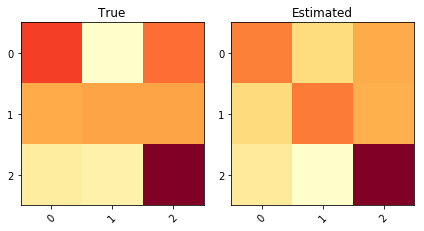

KL divergence: 0.0991	Pearson Correlation between diagonals: 0.9021


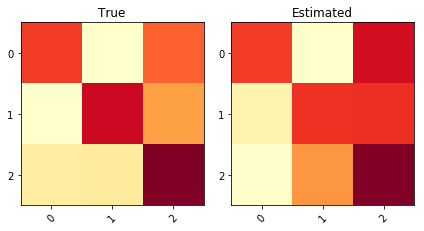

KL divergence: 0.1528	Pearson Correlation between diagonals: 0.9127


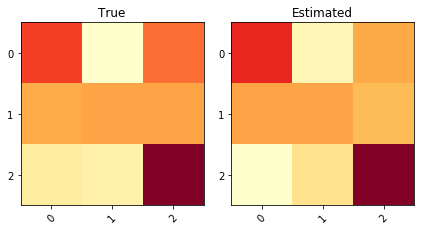

KL divergence: 0.0647	Pearson Correlation between diagonals: 0.9938


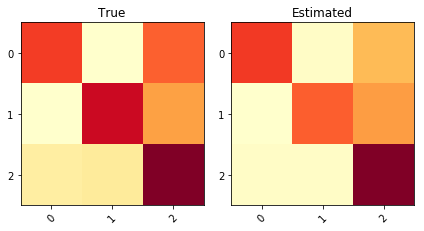

KL divergence: 0.0881	Pearson Correlation between diagonals: 0.7753


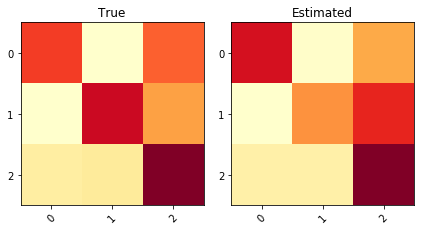

KL divergence: 0.1086	Pearson Correlation between diagonals: 0.4218


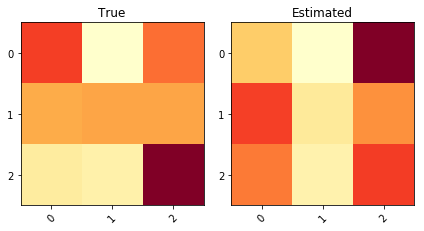

KL divergence: 0.2052	Pearson Correlation between diagonals: 0.9873


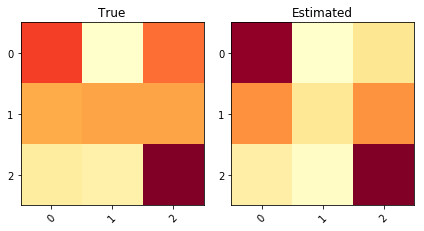

KL divergence: 0.1071	Pearson Correlation between diagonals: 0.8380
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.791012 |     0.791012 |     0.131932 |              0.766229 |       0.159491 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.613166 |                          0.831374 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [39]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


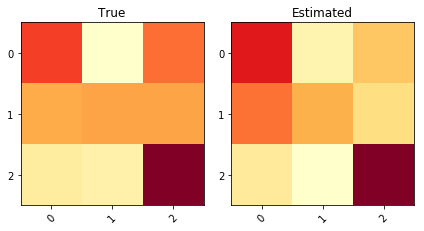

KL divergence: 0.0861	Pearson Correlation between diagonals: 0.9769


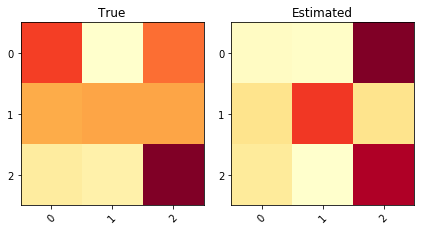

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.3325


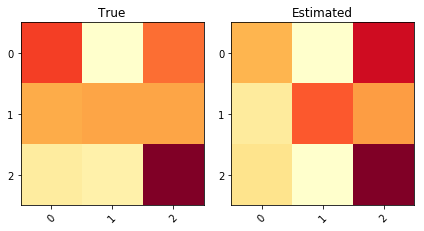

KL divergence: 0.0980	Pearson Correlation between diagonals: 0.6852


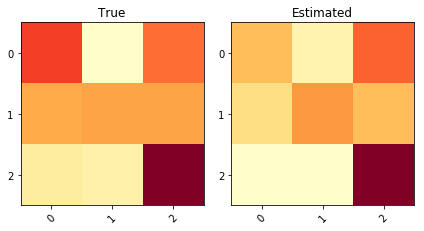

KL divergence: 0.0824	Pearson Correlation between diagonals: 0.8203


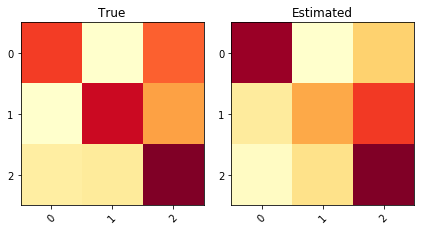

KL divergence: 0.1740	Pearson Correlation between diagonals: 0.1128


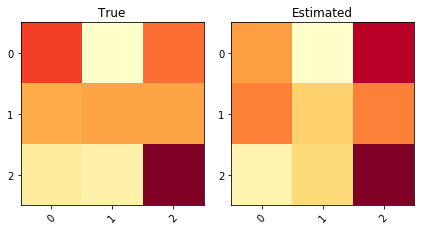

KL divergence: 0.1015	Pearson Correlation between diagonals: 0.9775


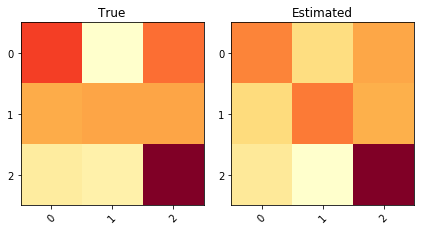

KL divergence: 0.0964	Pearson Correlation between diagonals: 0.8927


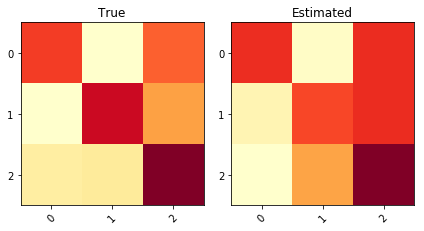

KL divergence: 0.1497	Pearson Correlation between diagonals: 0.7983


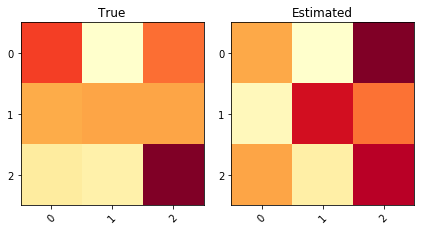

KL divergence: 0.1703	Pearson Correlation between diagonals: 0.2462


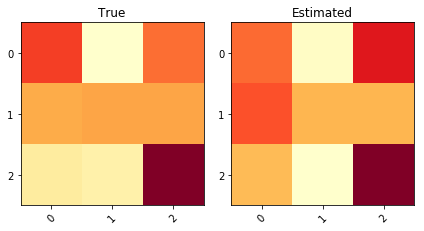

KL divergence: 0.0829	Pearson Correlation between diagonals: 0.9936


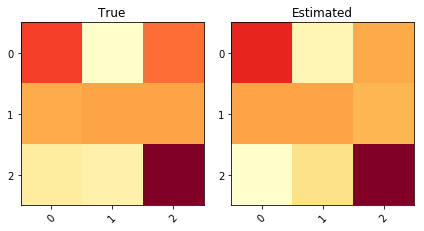

KL divergence: 0.0645	Pearson Correlation between diagonals: 0.9922


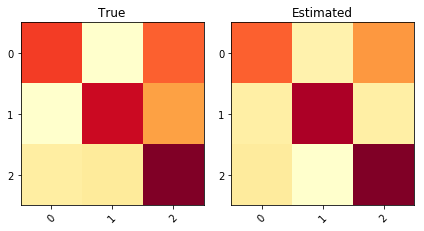

KL divergence: 0.1436	Pearson Correlation between diagonals: 0.9415


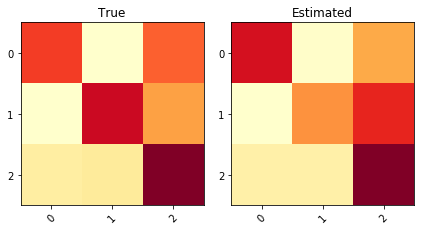

KL divergence: 0.1089	Pearson Correlation between diagonals: 0.4197


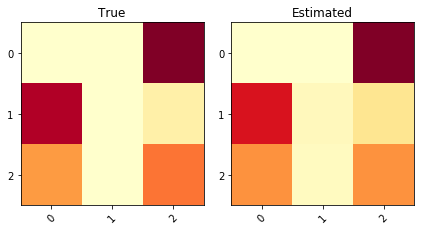

KL divergence: 0.1290	Pearson Correlation between diagonals: 0.9962


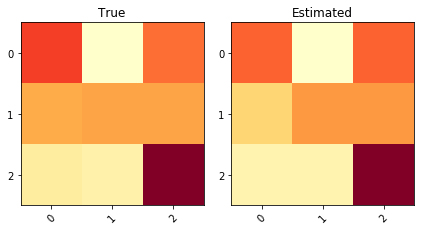

KL divergence: 0.0479	Pearson Correlation between diagonals: 0.9786
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.937173 |     0.937173 |     0.128344 |              0.770268 |       0.165157 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                      0.65944 |                          0.791704 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [37]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


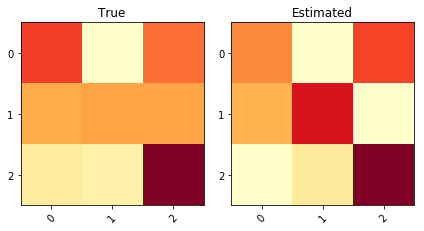

KL divergence: 0.5462	Pearson Correlation between diagonals: 0.5213


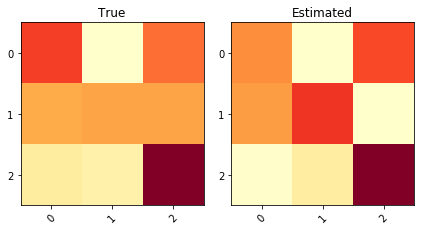

KL divergence: 0.4996	Pearson Correlation between diagonals: 0.6850


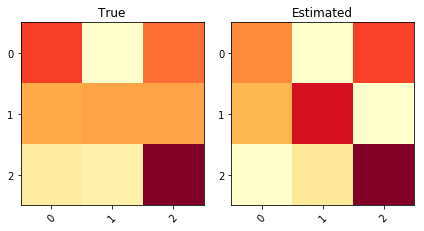

KL divergence: 0.5527	Pearson Correlation between diagonals: 0.4969


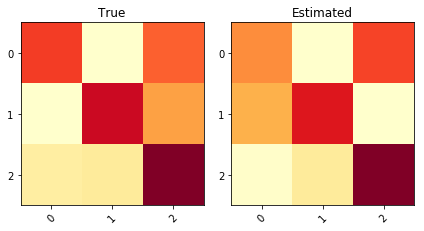

KL divergence: 0.6099	Pearson Correlation between diagonals: 0.9974


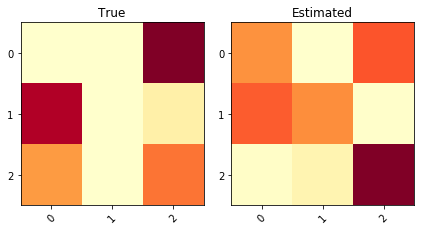

KL divergence: 0.8782	Pearson Correlation between diagonals: 0.9998


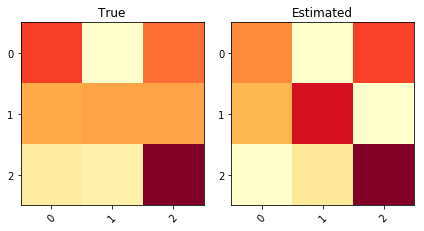

KL divergence: 0.5524	Pearson Correlation between diagonals: 0.4975


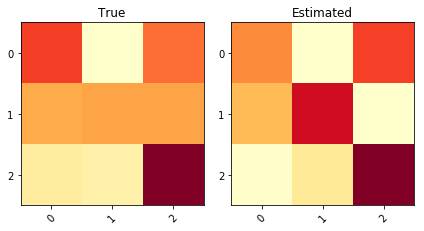

KL divergence: 0.5629	Pearson Correlation between diagonals: 0.4579


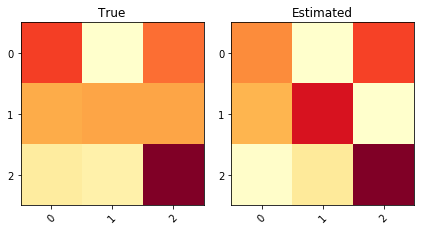

KL divergence: 0.5499	Pearson Correlation between diagonals: 0.5047


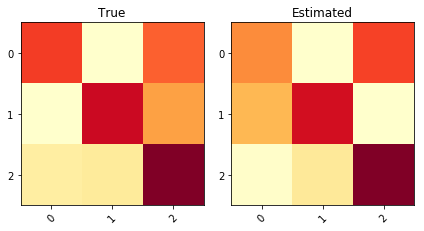

KL divergence: 0.6157	Pearson Correlation between diagonals: 0.9887


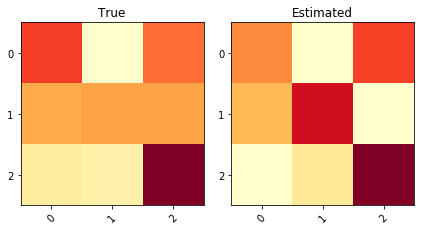

KL divergence: 0.5591	Pearson Correlation between diagonals: 0.4715


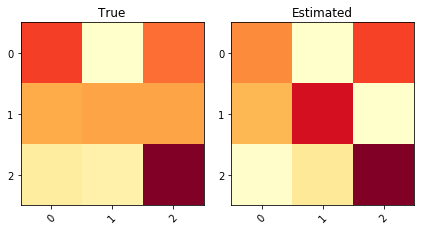

KL divergence: 0.5571	Pearson Correlation between diagonals: 0.4846


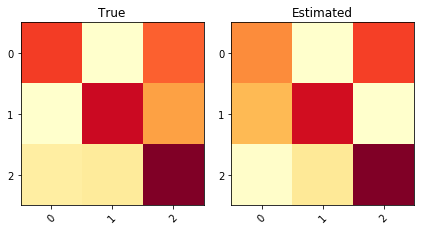

KL divergence: 0.6168	Pearson Correlation between diagonals: 0.9873


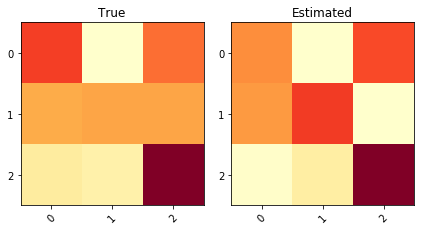

KL divergence: 0.4920	Pearson Correlation between diagonals: 0.7113


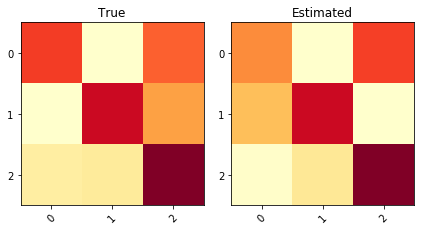

KL divergence: 0.6137	Pearson Correlation between diagonals: 0.9797


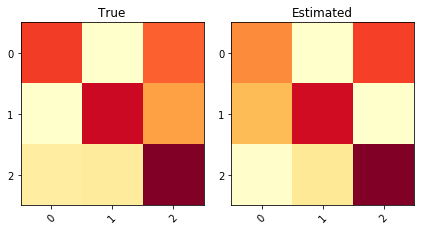

KL divergence: 0.6175	Pearson Correlation between diagonals: 0.9840
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.844677 |     0.844677 |     0.609705 |              0.722313 |       0.167881 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.587833 |               0.826687 |
+----+-------------------------+------------------------+
Test


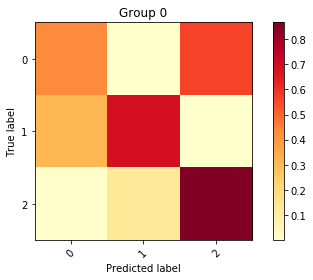

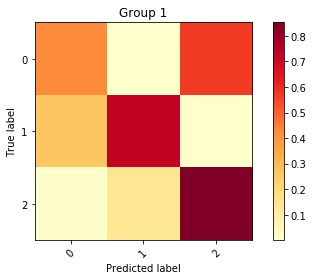

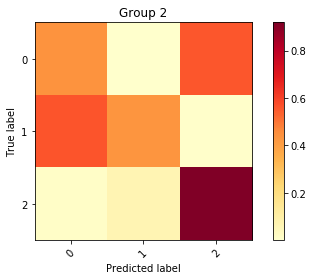

Inertia: 0.010679760947823524
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.579678 |    0.664293 |  0.448067 |           0.796756 |   0.564706 |     0.564706 |
|  1 |        1 |  0.57736  |    0.670741 |  0.439989 |           0.800656 |   0.589542 |     0.589542 |
|  2 |        2 |  0.574555 |    0.597844 |  0.579643 |           0.744088 |   0.317647 |     0.317647 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.835294 |     0.835294 |
+----+--------+------------+-----------

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


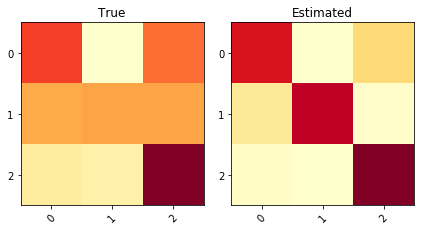

KL divergence: 0.5712	Pearson Correlation between diagonals: 0.6717


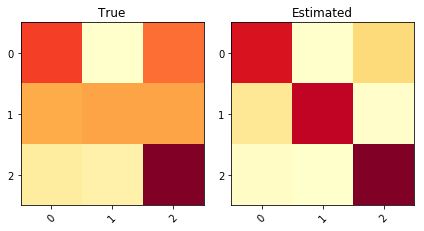

KL divergence: 0.5585	Pearson Correlation between diagonals: 0.7104


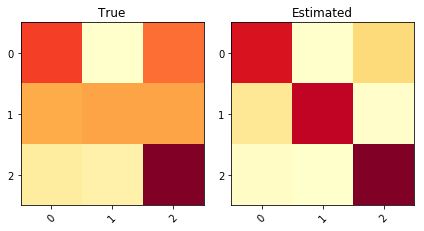

KL divergence: 0.5562	Pearson Correlation between diagonals: 0.7179


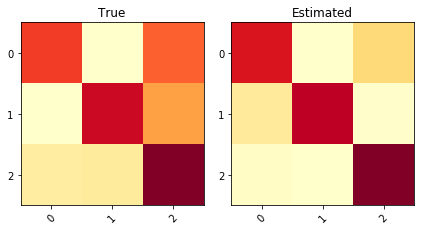

KL divergence: 0.5770	Pearson Correlation between diagonals: 0.9975


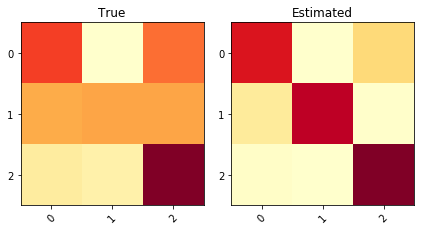

KL divergence: 0.5781	Pearson Correlation between diagonals: 0.6486


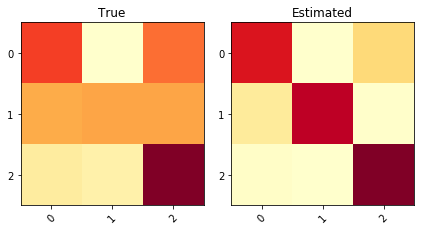

KL divergence: 0.5776	Pearson Correlation between diagonals: 0.6484


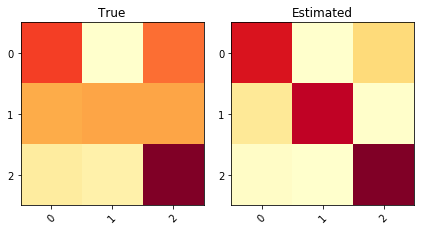

KL divergence: 0.5648	Pearson Correlation between diagonals: 0.6966


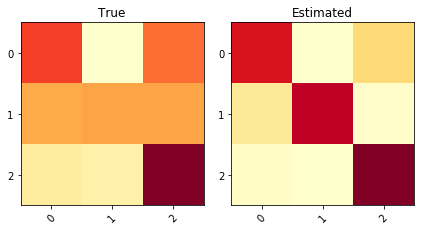

KL divergence: 0.5673	Pearson Correlation between diagonals: 0.6774


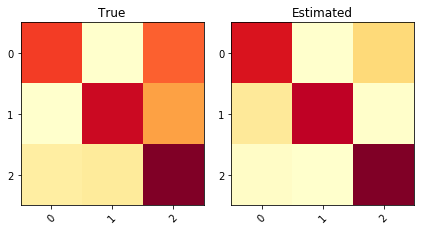

KL divergence: 0.5783	Pearson Correlation between diagonals: 0.9955


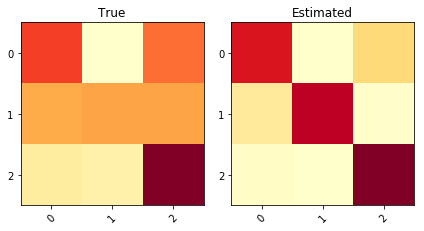

KL divergence: 0.5727	Pearson Correlation between diagonals: 0.6621


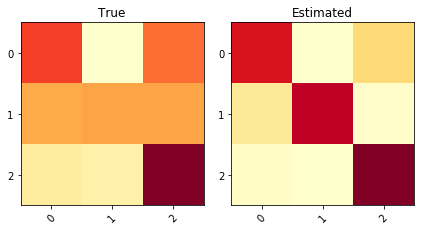

KL divergence: 0.5676	Pearson Correlation between diagonals: 0.6795


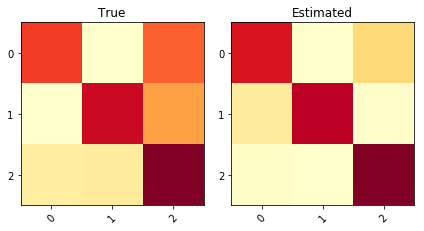

KL divergence: 0.5822	Pearson Correlation between diagonals: 0.9990


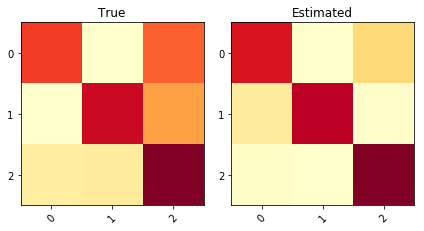

KL divergence: 0.5815	Pearson Correlation between diagonals: 0.9985


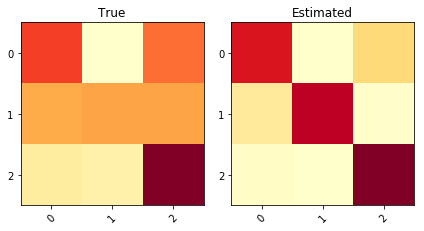

KL divergence: 0.5766	Pearson Correlation between diagonals: 0.6539


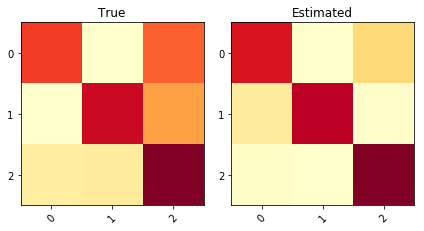

KL divergence: 0.5826	Pearson Correlation between diagonals: 0.9990
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.855585 |     0.855585 |     0.689879 |              0.802338 |         0.1604 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.548121 |               0.848168 |
+----+-------------------------+------------------------+
Test


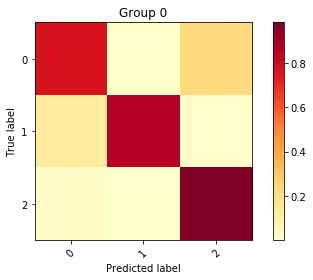

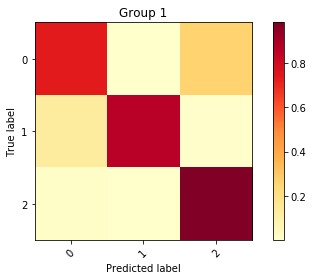

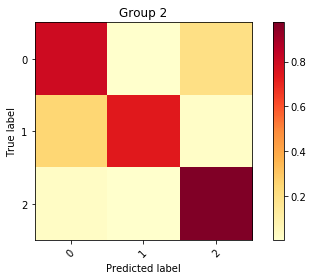

Inertia: 0.003682224778458476
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.346438 |    0.874643 |  0.138874 |           0.932638 |   0.454902 |     0.454902 |
|  1 |        1 |  0.368092 |    0.860909 |  0.15667  |           0.924411 |   0.431373 |     0.431373 |
|  2 |        2 |  0.422893 |    0.83578  |  0.186555 |           0.910214 |   0.366013 |     0.366013 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.830065 |     0.830065 |
+----+--------+------------+-----------

In [19]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") 

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


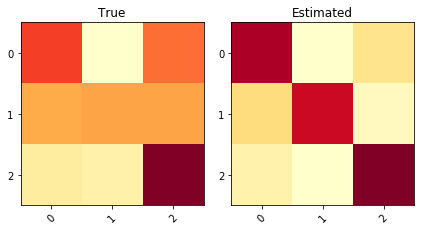

KL divergence: 0.3841	Pearson Correlation between diagonals: 0.9984


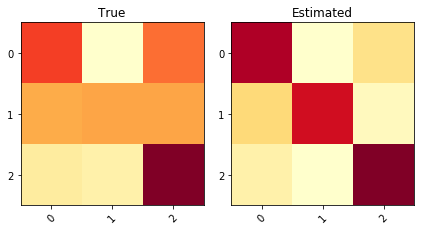

KL divergence: 0.3624	Pearson Correlation between diagonals: 0.9988


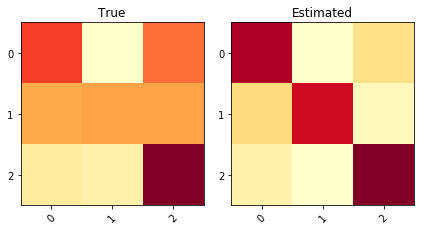

KL divergence: 0.3754	Pearson Correlation between diagonals: 0.9986


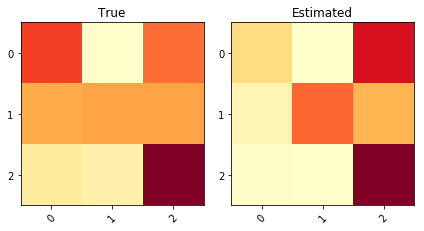

KL divergence: 0.3149	Pearson Correlation between diagonals: 0.6192


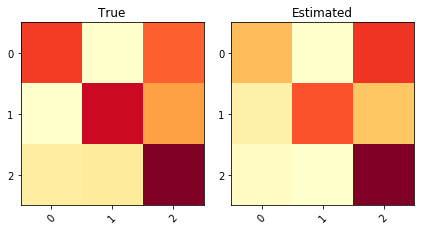

KL divergence: 0.2268	Pearson Correlation between diagonals: 0.9979


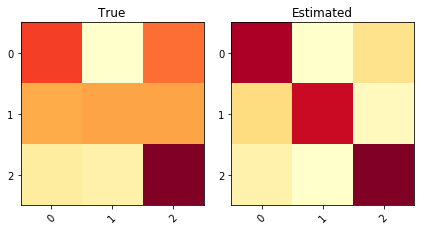

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.9995


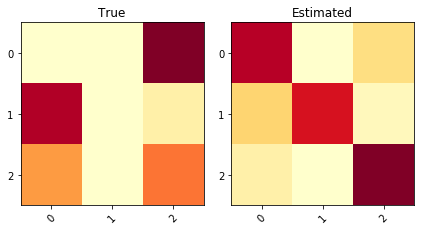

KL divergence: 1.1201	Pearson Correlation between diagonals: 0.8903


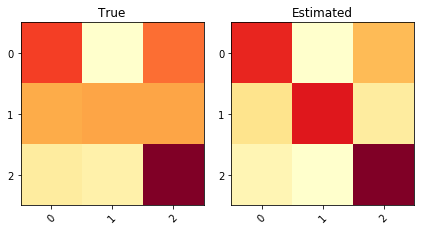

KL divergence: 0.2160	Pearson Correlation between diagonals: 0.8465


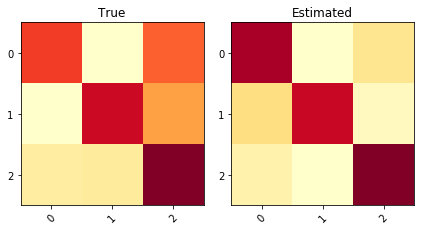

KL divergence: 0.4712	Pearson Correlation between diagonals: 0.5503


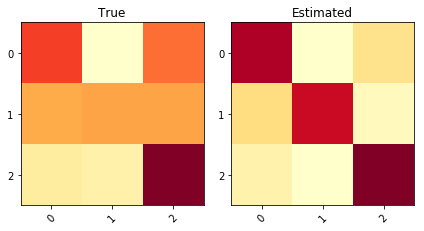

KL divergence: 0.3769	Pearson Correlation between diagonals: 1.0000


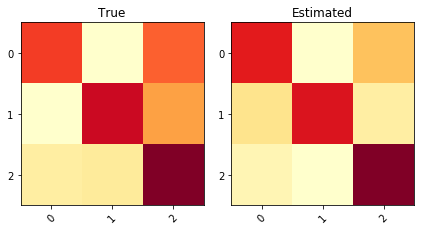

KL divergence: 0.2855	Pearson Correlation between diagonals: 0.9220


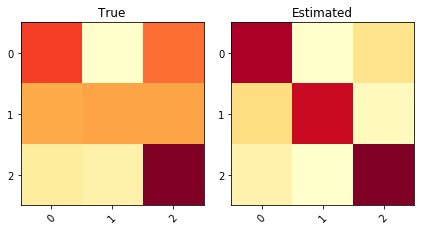

KL divergence: 0.3850	Pearson Correlation between diagonals: 0.9995


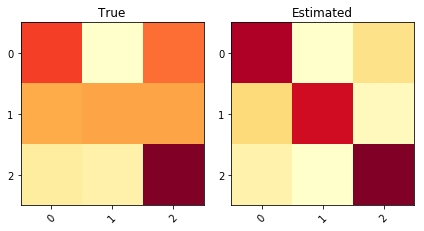

KL divergence: 0.3667	Pearson Correlation between diagonals: 0.9988


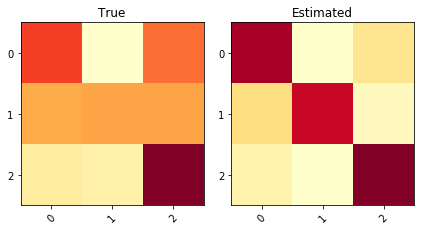

KL divergence: 0.4012	Pearson Correlation between diagonals: 0.9981


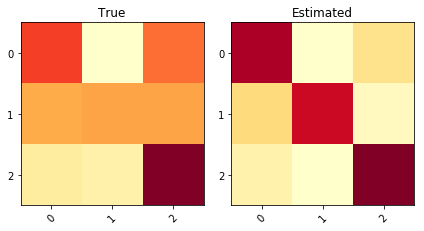

KL divergence: 0.3803	Pearson Correlation between diagonals: 0.9985
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.914485 |     0.914485 |     0.469839 |                0.8883 |       0.142997 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                  0.5825 |               0.840912 |
+----+-------------------------+------------------------+
Test


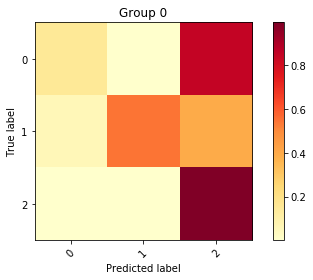

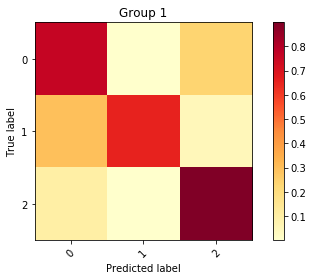

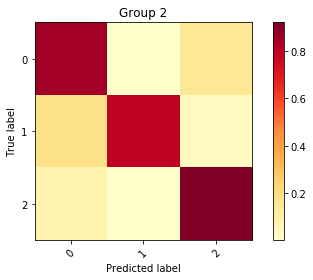

Inertia: 0.09496812196448445
A result
 +----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 |  0.439693 |    0.564239 |  0.835735 |           0.681204 |   0.322876 |     0.322876 |
|  1 |        1 |  0.560135 |    0.770963 |  0.268575 |           0.872117 |   0.394771 |     0.394771 |
|  2 |        2 |  0.4301   |    0.856605 |  0.156664 |           0.923677 |   0.779085 |     0.779085 |
+----+----------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.909804 |     0.909804 |
+----+--------+------------+------------

In [20]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)